# (1) Import Modules and Preprocess Data

In [74]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from progressbar import ProgressBar
from pykalman import KalmanFilter
import math

In [51]:
#create DataFrame for each stock containing stock price, foreign exchange rates, and index levels

stock_list = ['BYD','Cosco','Fosun','Huaneng','ICBC','PetroChina','Shenhua','Tsingtao','Vanke','ZTE']

fx = pd.read_csv('CNYHKD.csv')
fx.Date = pd.to_datetime(fx.Date)
fx = fx.set_index('Date')
csi = pd.read_csv('CSI300.csv')
csi.Date = pd.to_datetime(csi.Date)
csi = csi.set_index('Date')
csi = csi.drop(columns=['PX_VOLUME'])
hsi = pd.read_csv('HSI.csv')
hsi.Date = pd.to_datetime(hsi.Date)
hsi = hsi.set_index('Date')
hsi = hsi.drop(columns=['PX_VOLUME'])

for ticker in stock_list:
    current_fx = fx.copy()
    current_csi = csi.copy()
    current_hsi = hsi.copy()
    a_df = pd.read_csv(ticker+'.A.csv')
    a_df = a_df[a_df['Volume']!=0]
    a_df.Date = pd.to_datetime(a_df.Date)
    a_df = a_df.set_index('Date')
    a_df = a_df.drop(columns=['Open','High','Low','Close','Volume'])
    h_df = pd.read_csv(ticker+'.HK.csv')
    h_df = h_df[h_df['Volume']!=0]
    h_df.Date = pd.to_datetime(h_df.Date)
    h_df = h_df.set_index('Date')
    h_df = h_df.drop(columns=['Open','High','Low','Close','Volume'])
    
    current_df = pd.concat([a_df,h_df,current_fx,current_csi,current_hsi],axis=1)
    current_df = current_df.dropna()
    current_df.columns = ['A Shares','H Shares','CNYHKD','CSI300','Hang Seng Index']
    current_df.to_csv(ticker+'.csv')

# (2) Check Cointegration Relationships

In [90]:
BYD_df = pd.read_csv('BYD.csv')
Cosco_df = pd.read_csv('Cosco.csv')
Fosun_df = pd.read_csv('Fosun.csv')
Huaneng_df = pd.read_csv('Huaneng.csv')
ICBC_df = pd.read_csv('ICBC.csv')
PetroChina_df = pd.read_csv('PetroChina.csv')
Shenhua_df = pd.read_csv('Shenhua.csv')
Tsingtao_df = pd.read_csv('Tsingtao.csv')
Vanke_df = pd.read_csv('Vanke.csv')
ZTE_df = pd.read_csv('ZTE.csv')

BYD_df['Date'] = pd.to_datetime(BYD_df['Date'])
Cosco_df['Date'] = pd.to_datetime(Cosco_df['Date'])
Fosun_df['Date'] = pd.to_datetime(Fosun_df['Date'])
Huaneng_df['Date'] = pd.to_datetime(Huaneng_df['Date'])
ICBC_df['Date'] = pd.to_datetime(ICBC_df['Date'])
PetroChina_df['Date'] = pd.to_datetime(PetroChina_df['Date'])
Shenhua_df['Date'] = pd.to_datetime(Shenhua_df['Date'])
Tsingtao_df['Date'] = pd.to_datetime(Tsingtao_df['Date'])
Vanke_df['Date'] = pd.to_datetime(Vanke_df['Date'])
ZTE_df['Date'] = pd.to_datetime(ZTE_df['Date'])

BYD_df = BYD_df.set_index('Date')
Cosco_df = Cosco_df.set_index('Date')
Fosun_df = Fosun_df.set_index('Date')
Huaneng_df = Huaneng_df.set_index('Date')
ICBC_df = ICBC_df.set_index('Date')
PetroChina_df = PetroChina_df.set_index('Date')
Shenhua_df = Shenhua_df.set_index('Date')
Tsingtao_df = Tsingtao_df.set_index('Date')
Vanke_df = Vanke_df.set_index('Date')
ZTE_df = ZTE_df.set_index('Date')

In [91]:
coint_dic = {}

for ticker in stock_list:
    df = pd.read_csv(ticker+'.csv')
    p_val = coint(df['A Shares'],df['H Shares'])[1]
    coint_dic[ticker] = p_val
    
coint_dic

{'BYD': 0.15348074703996023,
 'Cosco': 0.00023212390705840288,
 'Fosun': 0.4963319079495822,
 'Huaneng': 0.19542322657034328,
 'ICBC': 0.16636677922491416,
 'PetroChina': 1.8450583677639835e-05,
 'Shenhua': 4.285087662617075e-06,
 'Tsingtao': 0.9779572468901945,
 'Vanke': 0.13327376643444666,
 'ZTE': 0.390419645353582}

# (3) Define Drawdown and Strategy Functions

In [3]:
# define drawdown function
def drawdown(array):
    
    depth_pct = []
    
    for i in range(len(array)):
        current_max = max(list(array)[:i+1])
        depth_pct.append((list(array)[i]-current_max)/current_max)
    
    return depth_pct

In [358]:
def pairs_trading(raw_data,method='eg',reg_period=126,band_period=21,std=1,lop_thres=0.3,a_short=False,purpose='validation',notional=100000):
    
    #raw_data: input data from previous step
    #method: either 'eg' (Engle-Granger), 'kf' (Kalman Filter), or 'lop' (Law of One Price)
    #reg_period: number of past days used to calculate hedging ratio and spread
    #band_period: number of past days used to form bollinger bands
    #std: number of standard deviation used for bollinger bands
    #lop thres: law of one price signal threshold
    #a_short: whether short selling in A shares is prohibited
    #purpose: optimize using validation set ('validation') or test out-of-sample set ('test')
    #notional: absolute notional amount for A shares position
    
    data = raw_data.copy()
    
    #exchange rate conversion and log return calculation
    data['H Shares in RMB'] = data['H Shares']/data['CNYHKD']
    data['A Shares Log Return'] = np.log(data['A Shares']/data['A Shares'].shift(1))
    data['H Shares Log Return'] = np.log(data['H Shares in RMB']/data['H Shares in RMB'].shift(1))
    data['CSI300 Log Return'] = np.log(data['CSI300']/data['CSI300'].shift(1))
    data['HSI Log Return'] = np.log(data['Hang Seng Index']/data['Hang Seng Index'].shift(1))
    
    #initialize variables
    inter = np.full(len(data),np.nan)
    slope = np.full(len(data),np.nan)
    error = np.full(len(data),np.nan)
    state_means = 1
    state_covs = 0.01
    transit_cov = 0.01
    obs_cov = 1
    
    for i in range(reg_period-1,len(data)):
        
        #regression with H shares being the independent variable and A shares being the dependent variable
        if method=='eg':
            reg = LinearRegression().fit(np.array(data.iloc[i-(reg_period-1):i+1,5]).reshape(-1,1),data.iloc[i-(reg_period-1):i+1,0])
            inter[i] = reg.intercept_
            slope[i] = reg.coef_[0]
            error[i] = data.iloc[i,0]-inter[i]-slope[i]*data.iloc[i,5]
        
        #kalman filter process
        elif method=='kf':
            kf = KalmanFilter(n_dim_obs=1, n_dim_state=1,
                              initial_state_mean=state_means,
                              initial_state_covariance=state_covs,
                              transition_matrices=1,
                              observation_matrices=data.iloc[i,5],
                              observation_covariance=obs_cov,
                              transition_covariance=transit_cov)
            state_means = float(kf.filter_update(state_means,state_covs,data.iloc[i,0])[0])
            state_covs = float(kf.filter_update(state_means,state_covs,data.iloc[i,0])[1])
            inter[i] = 0
            slope[i] = state_means
            error[i] = data.iloc[i,0]-slope[i]*data.iloc[i,5]
            transit_cov = ((data.iloc[i-(reg_period-1):i+1,0]/data.iloc[i-(reg_period-1):i+1,5]-slope[i-(reg_period-1):i+1]).std(ddof=0))**2
            obs_cov = ((data.iloc[i-(reg_period-1):i+1,0]-slope[i-(reg_period-1):i+1]*data.iloc[i-(reg_period-1):i+1,5]).std(ddof=0))**2
            
        else:
            inter[reg_period-1:] = 0
            slope[reg_period-1:] = 1
            error[reg_period-1:] = 0
        
    data['Intercept'] = inter
    data['Slope'] = slope
    data['Error'] = error
    data = data.dropna()
        
    data['Average Error'] = data['Error'].rolling(band_period).mean()
    data['Error Standard Deviation'] = data['Error'].rolling(band_period).std(ddof=0)
    data['Upper Band'] = data['Average Error']+std*data['Error Standard Deviation']
    data['Lower Band'] = data['Average Error']-std*data['Error Standard Deviation']
    data = data.dropna()
    
    #train-test split
    thres = math.ceil(len(data)*0.75)
    train = data[:thres]
    test = data[thres:]
    if purpose=='validation':
        backtest_data = train
    else:
        backtest_data = test

    #generate signal and perform backtesting
    signal = np.zeros(len(backtest_data)) #1: long A shares; -1: short A shares
    a_position = np.zeros(len(backtest_data))
    h_position = np.zeros(len(backtest_data))
    net_value = np.zeros(len(backtest_data))
    daily_pnl = np.zeros(len(backtest_data))
    net_nav = np.zeros(len(backtest_data))
    net_nav[0] = notional
    
    for i in range(1,len(backtest_data)): #iterate through each day to backtest trading strategy
        
        if method=='lop':
            if signal[i-1]==0:
                if backtest_data.iloc[i,0]/backtest_data.iloc[i,5]>=1+lop_thres:
                    if a_short==False:
                        signal[i] = -1
                        a_position[i] = -notional/backtest_data.iloc[i,0]
                        h_position[i] = notional/backtest_data.iloc[i,5]
                        net_nav[i] = net_nav[i-1]
                    else:
                        net_nav[i] = net_nav[i-1]
                elif backtest_data.iloc[i,0]/backtest_data.iloc[i,5]<=1-lop_thres:
                    signal[i] = 1
                    a_position[i] = notional/backtest_data.iloc[i,0]
                    h_position[i] = -notional/backtest_data.iloc[i,5]
                    net_nav[i] = net_nav[i-1]
                else:
                    net_nav[i] = net_nav[i-1]
            elif signal[i-1]==1:
                if backtest_data.iloc[i,0]/backtest_data.iloc[i,5]>=1:
                    daily_pnl[i] = a_position[i-1]*(backtest_data.iloc[i,0]-backtest_data.iloc[i-1,0])+h_position[i-1]*(backtest_data.iloc[i,5]-backtest_data.iloc[i-1,5])
                    net_nav[i] = net_nav[i-1]+daily_pnl[i]
                else:
                    signal[i] = signal[i-1]
                    a_position[i] = a_position[i-1]
                    h_position[i] = h_position[i-1]
                    net_value[i] = a_position[i]*backtest_data.iloc[i,0]+h_position[i]*backtest_data.iloc[i,5]
                    daily_pnl[i] = net_value[i]-net_value[i-1]
                    net_nav[i] = net_nav[i-1]+daily_pnl[i]
            elif signal[i-1]==-1:
                if backtest_data.iloc[i,0]/backtest_data.iloc[i,5]<=1:
                    daily_pnl[i] = a_position[i-1]*(backtest_data.iloc[i,0]-backtest_data.iloc[i-1,0])+h_position[i-1]*(backtest_data.iloc[i,5]-backtest_data.iloc[i-1,5])
                    net_nav[i] = net_nav[i-1]+daily_pnl[i]
                else:
                    signal[i] = signal[i-1]
                    a_position[i] = a_position[i-1]
                    h_position[i] = h_position[i-1]
                    net_value[i] = a_position[i]*backtest_data.iloc[i,0]+h_position[i]*backtest_data.iloc[i,5]
                    daily_pnl[i] = net_value[i]-net_value[i-1]
                    net_nav[i] = net_nav[i-1]+daily_pnl[i]
        
        else:
            if backtest_data.iloc[i,12]<=backtest_data.iloc[i,15] and backtest_data.iloc[i,12]>=backtest_data.iloc[i,16] and backtest_data.iloc[i-1,12]>backtest_data.iloc[i-1,15]:
                if a_short==False:
                    signal[i] = -1
                    a_position[i] = -notional/backtest_data.iloc[i,0]
                    h_position[i] = notional/backtest_data.iloc[i,5]
                    daily_pnl[i] = a_position[i-1]*(backtest_data.iloc[i,0]-backtest_data.iloc[i-1,0])+h_position[i-1]*(backtest_data.iloc[i,5]-backtest_data.iloc[i-1,5])
                    net_nav[i] = net_nav[i-1]+daily_pnl[i]
                else:
                    daily_pnl[i] = a_position[i-1]*(backtest_data.iloc[i,0]-backtest_data.iloc[i-1,0])+h_position[i-1]*(backtest_data.iloc[i,5]-backtest_data.iloc[i-1,5])
                    net_nav[i] = net_nav[i-1]+daily_pnl[i]
            elif backtest_data.iloc[i,12]<=backtest_data.iloc[i,15] and backtest_data.iloc[i,12]>=backtest_data.iloc[i,16] and backtest_data.iloc[i-1,12]<backtest_data.iloc[i-1,16]:
                signal[i] = 1
                a_position[i] = notional/backtest_data.iloc[i,0]
                h_position[i] = -notional/backtest_data.iloc[i,5]
                daily_pnl[i] = a_position[i-1]*(backtest_data.iloc[i,0]-backtest_data.iloc[i-1,0])+h_position[i-1]*(backtest_data.iloc[i,5]-backtest_data.iloc[i-1,5])
                net_nav[i] = net_nav[i-1]+daily_pnl[i]
            else:
                signal[i] = signal[i-1]
                a_position[i] = a_position[i-1]
                h_position[i] = h_position[i-1]
                net_value[i] = a_position[i]*backtest_data.iloc[i,0]+h_position[i]*backtest_data.iloc[i,5]
                daily_pnl[i] = net_value[i]-net_value[i-1]
                net_nav[i] = net_nav[i-1]+daily_pnl[i]
                
    backtest_data['Signal'] = signal
    backtest_data['A Shares Position'] = a_position
    backtest_data['H Shares Position'] = h_position
    backtest_data['Portfolio Value'] = net_value
    backtest_data['Daily PnL'] = daily_pnl
    backtest_data['NAV'] = net_nav
    backtest_data['Portfolio Log Return'] = np.log(backtest_data['NAV']/backtest_data['NAV'].shift(1))
    backtest_data['Portfolio Log Return'][0] = 0
    if backtest_data['NAV'].values[-1]/backtest_data['NAV'].values[0]>=np.exp(-1):
        backtest_data['Portfolio Cumulative Return'] = backtest_data['Portfolio Log Return'].cumsum()
    else:
        backtest_data['Portfolio Cumulative Return'] = backtest_data['NAV']/backtest_data['NAV'].values[0]-1
    backtest_data['Drawdown'] = drawdown(backtest_data['NAV'])
    max_drawdowns = np.zeros(len(backtest_data))
    for i in range(len(backtest_data)):
        max_drawdowns[i] = min(backtest_data['Drawdown'][:i+1])
    backtest_data['Max Drawdown'] = max_drawdowns
    
    if backtest_data['A Shares'].values[-1]/backtest_data['A Shares'].values[0]>=np.exp(-1):
        backtest_data['A Shares Cumulative Return'] = backtest_data['A Shares Log Return'].cumsum()
    else:
        backtest_data['A Shares Cumulative Return'] = backtest_data['A Shares']/backtest_data['A Shares'].values[0]-1
    if backtest_data['H Shares'].values[-1]/backtest_data['H Shares'].values[0]>=np.exp(-1):
        backtest_data['H Shares Cumulative Return'] = backtest_data['H Shares Log Return'].cumsum()
    else:
        backtest_data['H Shares Cumulative Return'] = backtest_data['H Shares']/backtest_data['H Shares'].values[0]-1
    backtest_data['CSI300 Cumulative Return'] = backtest_data['CSI300 Log Return'].cumsum()
    backtest_data['HSI Cumulative Return'] = backtest_data['HSI Log Return'].cumsum()
    backtest_data['A Shares Drawdown'] = drawdown(backtest_data['A Shares'])
    backtest_data['H Shares Drawdown'] = drawdown(backtest_data['H Shares'])
    backtest_data['CSI300 Drawdown'] = drawdown(backtest_data['CSI300'])
    backtest_data['HSI Drawdown'] = drawdown(backtest_data['Hang Seng Index'])
    a_max_drawdowns = np.zeros(len(backtest_data))
    h_max_drawdowns = np.zeros(len(backtest_data))
    csi_max_drawdowns = np.zeros(len(backtest_data))
    hsi_max_drawdowns = np.zeros(len(backtest_data))
    for i in range(len(backtest_data)):
        a_max_drawdowns[i] = min(backtest_data['A Shares Drawdown'][:i+1])
        h_max_drawdowns[i] = min(backtest_data['H Shares Drawdown'][:i+1])
        csi_max_drawdowns[i] = min(backtest_data['CSI300 Drawdown'][:i+1])
        hsi_max_drawdowns[i] = min(backtest_data['HSI Drawdown'][:i+1])
    backtest_data['A Shares Max Drawdown'] = a_max_drawdowns
    backtest_data['H Shares Max Drawdown'] = h_max_drawdowns
    backtest_data['CSI300 Max Drawdown'] = csi_max_drawdowns
    backtest_data['HSI Max Drawdown'] = hsi_max_drawdowns
    
    return backtest_data
                

# (4) Parameter Optimization

In [256]:
#define parameter range

df_list = [BYD_df,Cosco_df,Fosun_df,Huaneng_df,ICBC_df,PetroChina_df,Shenhua_df,Tsingtao_df,Vanke_df,ZTE_df]
method_selection = ['eg','kf','lop']
reg_per_range = [63 ,126, 252]
band_per_range = [10, 21, 42]
std_range = [1, 1.5, 2]
lop_thres_range = [0.2, 0.3, 0.4]
a_short_range = [False, True]

In [257]:
#create dictionaries for storing results

for ticker in stock_list:
    for met in method_selection:
        for short in a_short_range:
            var_name = ticker+'_'+met+'_'+str(short)
            locals()[var_name] = {}

In [259]:
#optimization process

pbar = ProgressBar()

for i in pbar(range(len(df_list))):
    for met in method_selection:
        for reg in reg_per_range:
            for band in band_per_range:
                for std in std_range:
                    if met!='lop':
                        for short in a_short_range:
                            result = pairs_trading(df_list[i],method=met,reg_period=reg,band_period=band,std=std,a_short=short,purpose='validation',notional=100000)
                            locals()[stock_list[i]+'_'+met+'_'+str(short)][(reg,band,std)] = ((1+result['Portfolio Cumulative Return'].values[-1])**(252/len(result))-1)/(result['Portfolio Log Return'].std(ddof=0)*np.sqrt(252))
                    else:
                        for lop in lop_thres_range:
                            result = pairs_trading(df_list[i],method=met,reg_period=reg,band_period=band,std=std,lop_thres=lop,purpose='validation',notional=100000)
                            locals()[stock_list[i]+'_'+met+'_False'][(reg,band,std,lop)] = ((1+result['Portfolio Cumulative Return'].values[-1])**(252/len(result))-1)/(result['Portfolio Log Return'].std(ddof=0)*np.sqrt(252))

100% |########################################################################|


In [309]:
print('The parameter combination',sorted({k: v for k, v in BYD_eg_False.items() if not math.isnan(v)}, key={k: v for k, v in BYD_eg_False.items() if not math.isnan(v)}.get)[-1],'gives us highest Sharpe Ratio',{k: v for k, v in BYD_eg_False.items() if not math.isnan(v)}[sorted({k: v for k, v in BYD_eg_False.items() if not math.isnan(v)}, key={k: v for k, v in BYD_eg_False.items() if not math.isnan(v)}.get)[-1]],'for BYD_eg_False')
print('The parameter combination',sorted({k: v for k, v in BYD_eg_True.items() if not math.isnan(v)}, key={k: v for k, v in BYD_eg_True.items() if not math.isnan(v)}.get)[-1],'gives us highest Sharpe Ratio',{k: v for k, v in BYD_eg_True.items() if not math.isnan(v)}[sorted({k: v for k, v in BYD_eg_True.items() if not math.isnan(v)}, key={k: v for k, v in BYD_eg_True.items() if not math.isnan(v)}.get)[-1]],'for BYD_eg_True')
print('The parameter combination',sorted({k: v for k, v in BYD_kf_False.items() if not math.isnan(v)}, key={k: v for k, v in BYD_kf_False.items() if not math.isnan(v)}.get)[-1],'gives us highest Sharpe Ratio',{k: v for k, v in BYD_kf_False.items() if not math.isnan(v)}[sorted({k: v for k, v in BYD_kf_False.items() if not math.isnan(v)}, key={k: v for k, v in BYD_kf_False.items() if not math.isnan(v)}.get)[-1]],'for BYD_kf_False')
print('The parameter combination',sorted({k: v for k, v in BYD_kf_True.items() if not math.isnan(v)}, key={k: v for k, v in BYD_kf_True.items() if not math.isnan(v)}.get)[-1],'gives us highest Sharpe Ratio',{k: v for k, v in BYD_kf_True.items() if not math.isnan(v)}[sorted({k: v for k, v in BYD_kf_True.items() if not math.isnan(v)}, key={k: v for k, v in BYD_kf_True.items() if not math.isnan(v)}.get)[-1]],'for BYD_kf_True')
print('The parameter combination',sorted({k: v for k, v in BYD_lop_False.items() if not math.isnan(v)}, key={k: v for k, v in BYD_lop_False.items() if not math.isnan(v)}.get)[-1],'gives us highest Sharpe Ratio',{k: v for k, v in BYD_lop_False.items() if not math.isnan(v)}[sorted({k: v for k, v in BYD_lop_False.items() if not math.isnan(v)}, key={k: v for k, v in BYD_lop_False.items() if not math.isnan(v)}.get)[-1]],'for BYD_lop_False')


The parameter combination (126, 42, 2) gives us highest Sharpe Ratio 0.43720999833426366 for BYD_eg_False
The parameter combination (252, 10, 1) gives us highest Sharpe Ratio 0.41457364847396916 for BYD_eg_True
The parameter combination (126, 21, 2) gives us highest Sharpe Ratio 0.6025594624228899 for BYD_kf_False
The parameter combination (126, 21, 2) gives us highest Sharpe Ratio 0.36444037839814575 for BYD_kf_True
The parameter combination (252, 21, 2, 0.4) gives us highest Sharpe Ratio 0.2185670642495127 for BYD_lop_False


In [310]:
print('The parameter combination',sorted({k: v for k, v in Cosco_eg_False.items() if not math.isnan(v)}, key={k: v for k, v in Cosco_eg_False.items() if not math.isnan(v)}.get)[-1],'gives us highest Sharpe Ratio',{k: v for k, v in Cosco_eg_False.items() if not math.isnan(v)}[sorted({k: v for k, v in Cosco_eg_False.items() if not math.isnan(v)}, key={k: v for k, v in Cosco_eg_False.items() if not math.isnan(v)}.get)[-1]],'for Cosco_eg_False')
print('The parameter combination',sorted({k: v for k, v in Cosco_eg_True.items() if not math.isnan(v)}, key={k: v for k, v in Cosco_eg_True.items() if not math.isnan(v)}.get)[-1],'gives us highest Sharpe Ratio',{k: v for k, v in Cosco_eg_True.items() if not math.isnan(v)}[sorted({k: v for k, v in Cosco_eg_True.items() if not math.isnan(v)}, key={k: v for k, v in Cosco_eg_True.items() if not math.isnan(v)}.get)[-1]],'for Cosco_eg_True')
print('The parameter combination',sorted({k: v for k, v in Cosco_kf_False.items() if not math.isnan(v)}, key={k: v for k, v in Cosco_kf_False.items() if not math.isnan(v)}.get)[-1],'gives us highest Sharpe Ratio',{k: v for k, v in Cosco_kf_False.items() if not math.isnan(v)}[sorted({k: v for k, v in Cosco_kf_False.items() if not math.isnan(v)}, key={k: v for k, v in Cosco_kf_False.items() if not math.isnan(v)}.get)[-1]],'for Cosco_kf_False')
print('The parameter combination',sorted({k: v for k, v in Cosco_kf_True.items() if not math.isnan(v)}, key={k: v for k, v in Cosco_kf_True.items() if not math.isnan(v)}.get)[-1],'gives us highest Sharpe Ratio',{k: v for k, v in Cosco_kf_True.items() if not math.isnan(v)}[sorted({k: v for k, v in Cosco_kf_True.items() if not math.isnan(v)}, key={k: v for k, v in Cosco_kf_True.items() if not math.isnan(v)}.get)[-1]],'for Cosco_kf_True')
print('The parameter combination',sorted({k: v for k, v in Cosco_lop_False.items() if not math.isnan(v)}, key={k: v for k, v in Cosco_lop_False.items() if not math.isnan(v)}.get)[-1],'gives us highest Sharpe Ratio',{k: v for k, v in Cosco_lop_False.items() if not math.isnan(v)}[sorted({k: v for k, v in Cosco_lop_False.items() if not math.isnan(v)}, key={k: v for k, v in Cosco_lop_False.items() if not math.isnan(v)}.get)[-1]],'for Cosco_lop_False')


The parameter combination (252, 21, 2) gives us highest Sharpe Ratio 0.5096674748938222 for Cosco_eg_False
The parameter combination (252, 21, 2) gives us highest Sharpe Ratio 0.37622105455911325 for Cosco_eg_True
The parameter combination (252, 10, 1.5) gives us highest Sharpe Ratio 0.5117720828543315 for Cosco_kf_False
The parameter combination (252, 10, 1.5) gives us highest Sharpe Ratio 0.2950883703118051 for Cosco_kf_True
The parameter combination (252, 42, 2, 0.4) gives us highest Sharpe Ratio 0.05905170646236309 for Cosco_lop_False


In [311]:
print('The parameter combination',sorted({k: v for k, v in Fosun_eg_False.items() if not math.isnan(v)}, key={k: v for k, v in Fosun_eg_False.items() if not math.isnan(v)}.get)[-1],'gives us highest Sharpe Ratio',{k: v for k, v in Fosun_eg_False.items() if not math.isnan(v)}[sorted({k: v for k, v in Fosun_eg_False.items() if not math.isnan(v)}, key={k: v for k, v in Fosun_eg_False.items() if not math.isnan(v)}.get)[-1]],'for Fosun_eg_False')
print('The parameter combination',sorted({k: v for k, v in Fosun_eg_True.items() if not math.isnan(v)}, key={k: v for k, v in Fosun_eg_True.items() if not math.isnan(v)}.get)[-1],'gives us highest Sharpe Ratio',{k: v for k, v in Fosun_eg_True.items() if not math.isnan(v)}[sorted({k: v for k, v in Fosun_eg_True.items() if not math.isnan(v)}, key={k: v for k, v in Fosun_eg_True.items() if not math.isnan(v)}.get)[-1]],'for Fosun_eg_True')
print('The parameter combination',sorted({k: v for k, v in Fosun_kf_False.items() if not math.isnan(v)}, key={k: v for k, v in Fosun_kf_False.items() if not math.isnan(v)}.get)[-1],'gives us highest Sharpe Ratio',{k: v for k, v in Fosun_kf_False.items() if not math.isnan(v)}[sorted({k: v for k, v in Fosun_kf_False.items() if not math.isnan(v)}, key={k: v for k, v in Fosun_kf_False.items() if not math.isnan(v)}.get)[-1]],'for Fosun_kf_False')
print('The parameter combination',sorted({k: v for k, v in Fosun_kf_True.items() if not math.isnan(v)}, key={k: v for k, v in Fosun_kf_True.items() if not math.isnan(v)}.get)[-1],'gives us highest Sharpe Ratio',{k: v for k, v in Fosun_kf_True.items() if not math.isnan(v)}[sorted({k: v for k, v in Fosun_kf_True.items() if not math.isnan(v)}, key={k: v for k, v in Fosun_kf_True.items() if not math.isnan(v)}.get)[-1]],'for Fosun_kf_True')
print('The parameter combination',sorted({k: v for k, v in Fosun_lop_False.items() if not math.isnan(v)}, key={k: v for k, v in Fosun_lop_False.items() if not math.isnan(v)}.get)[-1],'gives us highest Sharpe Ratio',{k: v for k, v in Fosun_lop_False.items() if not math.isnan(v)}[sorted({k: v for k, v in Fosun_lop_False.items() if not math.isnan(v)}, key={k: v for k, v in Fosun_lop_False.items() if not math.isnan(v)}.get)[-1]],'for Fosun_lop_False')


The parameter combination (252, 10, 1) gives us highest Sharpe Ratio 0.19639000452138491 for Fosun_eg_False
The parameter combination (252, 21, 1.5) gives us highest Sharpe Ratio 0.20847842401664896 for Fosun_eg_True
The parameter combination (252, 42, 1) gives us highest Sharpe Ratio 0.49048076650503597 for Fosun_kf_False
The parameter combination (252, 10, 2) gives us highest Sharpe Ratio 0.5266431015317918 for Fosun_kf_True
The parameter combination (63, 21, 2, 0.3) gives us highest Sharpe Ratio 0.31184324076811887 for Fosun_lop_False


In [312]:
print('The parameter combination',sorted({k: v for k, v in Huaneng_eg_False.items() if not math.isnan(v)}, key={k: v for k, v in Huaneng_eg_False.items() if not math.isnan(v)}.get)[-1],'gives us highest Sharpe Ratio',{k: v for k, v in Huaneng_eg_False.items() if not math.isnan(v)}[sorted({k: v for k, v in Huaneng_eg_False.items() if not math.isnan(v)}, key={k: v for k, v in Huaneng_eg_False.items() if not math.isnan(v)}.get)[-1]],'for Huaneng_eg_False')
print('The parameter combination',sorted({k: v for k, v in Huaneng_eg_True.items() if not math.isnan(v)}, key={k: v for k, v in Huaneng_eg_True.items() if not math.isnan(v)}.get)[-1],'gives us highest Sharpe Ratio',{k: v for k, v in Huaneng_eg_True.items() if not math.isnan(v)}[sorted({k: v for k, v in Huaneng_eg_True.items() if not math.isnan(v)}, key={k: v for k, v in Huaneng_eg_True.items() if not math.isnan(v)}.get)[-1]],'for Huaneng_eg_True')
print('The parameter combination',sorted({k: v for k, v in Huaneng_kf_False.items() if not math.isnan(v)}, key={k: v for k, v in Huaneng_kf_False.items() if not math.isnan(v)}.get)[-1],'gives us highest Sharpe Ratio',{k: v for k, v in Huaneng_kf_False.items() if not math.isnan(v)}[sorted({k: v for k, v in Huaneng_kf_False.items() if not math.isnan(v)}, key={k: v for k, v in Huaneng_kf_False.items() if not math.isnan(v)}.get)[-1]],'for Huaneng_kf_False')
print('The parameter combination',sorted({k: v for k, v in Huaneng_kf_True.items() if not math.isnan(v)}, key={k: v for k, v in Huaneng_kf_True.items() if not math.isnan(v)}.get)[-1],'gives us highest Sharpe Ratio',{k: v for k, v in Huaneng_kf_True.items() if not math.isnan(v)}[sorted({k: v for k, v in Huaneng_kf_True.items() if not math.isnan(v)}, key={k: v for k, v in Huaneng_kf_True.items() if not math.isnan(v)}.get)[-1]],'for Huaneng_kf_True')
print('The parameter combination',sorted({k: v for k, v in Huaneng_lop_False.items() if not math.isnan(v)}, key={k: v for k, v in Huaneng_lop_False.items() if not math.isnan(v)}.get)[-1],'gives us highest Sharpe Ratio',{k: v for k, v in Huaneng_lop_False.items() if not math.isnan(v)}[sorted({k: v for k, v in Huaneng_lop_False.items() if not math.isnan(v)}, key={k: v for k, v in Huaneng_lop_False.items() if not math.isnan(v)}.get)[-1]],'for Huaneng_lop_False')


The parameter combination (252, 42, 1.5) gives us highest Sharpe Ratio 0.2636993944845212 for Huaneng_eg_False
The parameter combination (252, 42, 1.5) gives us highest Sharpe Ratio 0.30990397950779935 for Huaneng_eg_True
The parameter combination (63, 42, 2) gives us highest Sharpe Ratio 0.3215618106974061 for Huaneng_kf_False
The parameter combination (63, 42, 2) gives us highest Sharpe Ratio 0.3389728497409296 for Huaneng_kf_True
The parameter combination (63, 10, 2, 0.2) gives us highest Sharpe Ratio 0.04791009868316214 for Huaneng_lop_False


In [313]:
print('The parameter combination',sorted({k: v for k, v in ICBC_eg_False.items() if not math.isnan(v)}, key={k: v for k, v in ICBC_eg_False.items() if not math.isnan(v)}.get)[-1],'gives us highest Sharpe Ratio',{k: v for k, v in ICBC_eg_False.items() if not math.isnan(v)}[sorted({k: v for k, v in ICBC_eg_False.items() if not math.isnan(v)}, key={k: v for k, v in ICBC_eg_False.items() if not math.isnan(v)}.get)[-1]],'for ICBC_eg_False')
print('The parameter combination',sorted({k: v for k, v in ICBC_eg_True.items() if not math.isnan(v)}, key={k: v for k, v in ICBC_eg_True.items() if not math.isnan(v)}.get)[-1],'gives us highest Sharpe Ratio',{k: v for k, v in ICBC_eg_True.items() if not math.isnan(v)}[sorted({k: v for k, v in ICBC_eg_True.items() if not math.isnan(v)}, key={k: v for k, v in ICBC_eg_True.items() if not math.isnan(v)}.get)[-1]],'for ICBC_eg_True')
print('The parameter combination',sorted({k: v for k, v in ICBC_kf_False.items() if not math.isnan(v)}, key={k: v for k, v in ICBC_kf_False.items() if not math.isnan(v)}.get)[-1],'gives us highest Sharpe Ratio',{k: v for k, v in ICBC_kf_False.items() if not math.isnan(v)}[sorted({k: v for k, v in ICBC_kf_False.items() if not math.isnan(v)}, key={k: v for k, v in ICBC_kf_False.items() if not math.isnan(v)}.get)[-1]],'for ICBC_kf_False')
print('The parameter combination',sorted({k: v for k, v in ICBC_kf_True.items() if not math.isnan(v)}, key={k: v for k, v in ICBC_kf_True.items() if not math.isnan(v)}.get)[-1],'gives us highest Sharpe Ratio',{k: v for k, v in ICBC_kf_True.items() if not math.isnan(v)}[sorted({k: v for k, v in ICBC_kf_True.items() if not math.isnan(v)}, key={k: v for k, v in ICBC_kf_True.items() if not math.isnan(v)}.get)[-1]],'for ICBC_kf_True')
print('The parameter combination',sorted({k: v for k, v in ICBC_lop_False.items() if not math.isnan(v)}, key={k: v for k, v in ICBC_lop_False.items() if not math.isnan(v)}.get)[-1],'gives us highest Sharpe Ratio',{k: v for k, v in ICBC_lop_False.items() if not math.isnan(v)}[sorted({k: v for k, v in ICBC_lop_False.items() if not math.isnan(v)}, key={k: v for k, v in ICBC_lop_False.items() if not math.isnan(v)}.get)[-1]],'for ICBC_lop_False')


The parameter combination (63, 10, 2) gives us highest Sharpe Ratio 0.27705767103469525 for ICBC_eg_False
The parameter combination (63, 10, 2) gives us highest Sharpe Ratio 0.28442105927102046 for ICBC_eg_True
The parameter combination (252, 42, 1.5) gives us highest Sharpe Ratio 0.4960744104430968 for ICBC_kf_False
The parameter combination (252, 42, 1.5) gives us highest Sharpe Ratio 0.36736912740686534 for ICBC_kf_True
The parameter combination (252, 21, 2, 0.4) gives us highest Sharpe Ratio 0.6078720304964205 for ICBC_lop_False


In [314]:
print('The parameter combination',sorted({k: v for k, v in PetroChina_eg_False.items() if not math.isnan(v)}, key={k: v for k, v in PetroChina_eg_False.items() if not math.isnan(v)}.get)[-1],'gives us highest Sharpe Ratio',{k: v for k, v in PetroChina_eg_False.items() if not math.isnan(v)}[sorted({k: v for k, v in PetroChina_eg_False.items() if not math.isnan(v)}, key={k: v for k, v in PetroChina_eg_False.items() if not math.isnan(v)}.get)[-1]],'for PetroChina_eg_False')
print('The parameter combination',sorted({k: v for k, v in PetroChina_eg_True.items() if not math.isnan(v)}, key={k: v for k, v in PetroChina_eg_True.items() if not math.isnan(v)}.get)[-1],'gives us highest Sharpe Ratio',{k: v for k, v in PetroChina_eg_True.items() if not math.isnan(v)}[sorted({k: v for k, v in PetroChina_eg_True.items() if not math.isnan(v)}, key={k: v for k, v in PetroChina_eg_True.items() if not math.isnan(v)}.get)[-1]],'for PetroChina_eg_True')
print('The parameter combination',sorted({k: v for k, v in PetroChina_kf_False.items() if not math.isnan(v)}, key={k: v for k, v in PetroChina_kf_False.items() if not math.isnan(v)}.get)[-1],'gives us highest Sharpe Ratio',{k: v for k, v in PetroChina_kf_False.items() if not math.isnan(v)}[sorted({k: v for k, v in PetroChina_kf_False.items() if not math.isnan(v)}, key={k: v for k, v in PetroChina_kf_False.items() if not math.isnan(v)}.get)[-1]],'for PetroChina_kf_False')
print('The parameter combination',sorted({k: v for k, v in PetroChina_kf_True.items() if not math.isnan(v)}, key={k: v for k, v in PetroChina_kf_True.items() if not math.isnan(v)}.get)[-1],'gives us highest Sharpe Ratio',{k: v for k, v in PetroChina_kf_True.items() if not math.isnan(v)}[sorted({k: v for k, v in PetroChina_kf_True.items() if not math.isnan(v)}, key={k: v for k, v in PetroChina_kf_True.items() if not math.isnan(v)}.get)[-1]],'for PetroChina_kf_True')
print('The parameter combination',sorted({k: v for k, v in PetroChina_lop_False.items() if not math.isnan(v)}, key={k: v for k, v in PetroChina_lop_False.items() if not math.isnan(v)}.get)[-1],'gives us highest Sharpe Ratio',{k: v for k, v in PetroChina_lop_False.items() if not math.isnan(v)}[sorted({k: v for k, v in PetroChina_lop_False.items() if not math.isnan(v)}, key={k: v for k, v in PetroChina_lop_False.items() if not math.isnan(v)}.get)[-1]],'for PetroChina_lop_False')


The parameter combination (63, 21, 1) gives us highest Sharpe Ratio 0.4536820651719854 for PetroChina_eg_False
The parameter combination (63, 21, 1) gives us highest Sharpe Ratio 0.31539299302403295 for PetroChina_eg_True
The parameter combination (63, 10, 1) gives us highest Sharpe Ratio 0.46852723489119175 for PetroChina_kf_False
The parameter combination (126, 10, 1) gives us highest Sharpe Ratio 0.32102890317898247 for PetroChina_kf_True
The parameter combination (252, 42, 2, 0.4) gives us highest Sharpe Ratio 0.24772430041432314 for PetroChina_lop_False


In [315]:
print('The parameter combination',sorted({k: v for k, v in Shenhua_eg_False.items() if not math.isnan(v)}, key={k: v for k, v in Shenhua_eg_False.items() if not math.isnan(v)}.get)[-1],'gives us highest Sharpe Ratio',{k: v for k, v in Shenhua_eg_False.items() if not math.isnan(v)}[sorted({k: v for k, v in Shenhua_eg_False.items() if not math.isnan(v)}, key={k: v for k, v in Shenhua_eg_False.items() if not math.isnan(v)}.get)[-1]],'for Shenhua_eg_False')
print('The parameter combination',sorted({k: v for k, v in Shenhua_eg_True.items() if not math.isnan(v)}, key={k: v for k, v in Shenhua_eg_True.items() if not math.isnan(v)}.get)[-1],'gives us highest Sharpe Ratio',{k: v for k, v in Shenhua_eg_True.items() if not math.isnan(v)}[sorted({k: v for k, v in Shenhua_eg_True.items() if not math.isnan(v)}, key={k: v for k, v in Shenhua_eg_True.items() if not math.isnan(v)}.get)[-1]],'for Shenhua_eg_True')
print('The parameter combination',sorted({k: v for k, v in Shenhua_kf_False.items() if not math.isnan(v)}, key={k: v for k, v in Shenhua_kf_False.items() if not math.isnan(v)}.get)[-1],'gives us highest Sharpe Ratio',{k: v for k, v in Shenhua_kf_False.items() if not math.isnan(v)}[sorted({k: v for k, v in Shenhua_kf_False.items() if not math.isnan(v)}, key={k: v for k, v in Shenhua_kf_False.items() if not math.isnan(v)}.get)[-1]],'for Shenhua_kf_False')
print('The parameter combination',sorted({k: v for k, v in Shenhua_kf_True.items() if not math.isnan(v)}, key={k: v for k, v in Shenhua_kf_True.items() if not math.isnan(v)}.get)[-1],'gives us highest Sharpe Ratio',{k: v for k, v in Shenhua_kf_True.items() if not math.isnan(v)}[sorted({k: v for k, v in Shenhua_kf_True.items() if not math.isnan(v)}, key={k: v for k, v in Shenhua_kf_True.items() if not math.isnan(v)}.get)[-1]],'for Shenhua_kf_True')
print('The parameter combination',sorted({k: v for k, v in Shenhua_lop_False.items() if not math.isnan(v)}, key={k: v for k, v in Shenhua_lop_False.items() if not math.isnan(v)}.get)[-1],'gives us highest Sharpe Ratio',{k: v for k, v in Shenhua_lop_False.items() if not math.isnan(v)}[sorted({k: v for k, v in Shenhua_lop_False.items() if not math.isnan(v)}, key={k: v for k, v in Shenhua_lop_False.items() if not math.isnan(v)}.get)[-1]],'for Shenhua_lop_False')


The parameter combination (63, 10, 2) gives us highest Sharpe Ratio 0.5572148553334056 for Shenhua_eg_False
The parameter combination (63, 10, 1.5) gives us highest Sharpe Ratio 0.4441790926232256 for Shenhua_eg_True
The parameter combination (126, 42, 1) gives us highest Sharpe Ratio 0.47144001993049683 for Shenhua_kf_False
The parameter combination (126, 42, 2) gives us highest Sharpe Ratio 0.47857066840194945 for Shenhua_kf_True
The parameter combination (252, 10, 2, 0.4) gives us highest Sharpe Ratio 0.1798549207758243 for Shenhua_lop_False


In [316]:
print('The parameter combination',sorted({k: v for k, v in Tsingtao_eg_False.items() if not math.isnan(v)}, key={k: v for k, v in Tsingtao_eg_False.items() if not math.isnan(v)}.get)[-1],'gives us highest Sharpe Ratio',{k: v for k, v in Tsingtao_eg_False.items() if not math.isnan(v)}[sorted({k: v for k, v in Tsingtao_eg_False.items() if not math.isnan(v)}, key={k: v for k, v in Tsingtao_eg_False.items() if not math.isnan(v)}.get)[-1]],'for Tsingtao_eg_False')
print('The parameter combination',sorted({k: v for k, v in Tsingtao_eg_True.items() if not math.isnan(v)}, key={k: v for k, v in Tsingtao_eg_True.items() if not math.isnan(v)}.get)[-1],'gives us highest Sharpe Ratio',{k: v for k, v in Tsingtao_eg_True.items() if not math.isnan(v)}[sorted({k: v for k, v in Tsingtao_eg_True.items() if not math.isnan(v)}, key={k: v for k, v in Tsingtao_eg_True.items() if not math.isnan(v)}.get)[-1]],'for Tsingtao_eg_True')
print('The parameter combination',sorted({k: v for k, v in Tsingtao_kf_False.items() if not math.isnan(v)}, key={k: v for k, v in Tsingtao_kf_False.items() if not math.isnan(v)}.get)[-1],'gives us highest Sharpe Ratio',{k: v for k, v in Tsingtao_kf_False.items() if not math.isnan(v)}[sorted({k: v for k, v in Tsingtao_kf_False.items() if not math.isnan(v)}, key={k: v for k, v in Tsingtao_kf_False.items() if not math.isnan(v)}.get)[-1]],'for Tsingtao_kf_False')
print('The parameter combination',sorted({k: v for k, v in Tsingtao_kf_True.items() if not math.isnan(v)}, key={k: v for k, v in Tsingtao_kf_True.items() if not math.isnan(v)}.get)[-1],'gives us highest Sharpe Ratio',{k: v for k, v in Tsingtao_kf_True.items() if not math.isnan(v)}[sorted({k: v for k, v in Tsingtao_kf_True.items() if not math.isnan(v)}, key={k: v for k, v in Tsingtao_kf_True.items() if not math.isnan(v)}.get)[-1]],'for Tsingtao_kf_True')
print('The parameter combination',sorted({k: v for k, v in Tsingtao_lop_False.items() if not math.isnan(v)}, key={k: v for k, v in Tsingtao_lop_False.items() if not math.isnan(v)}.get)[-1],'gives us highest Sharpe Ratio',{k: v for k, v in Tsingtao_lop_False.items() if not math.isnan(v)}[sorted({k: v for k, v in Tsingtao_lop_False.items() if not math.isnan(v)}, key={k: v for k, v in Tsingtao_lop_False.items() if not math.isnan(v)}.get)[-1]],'for Tsingtao_lop_False')


The parameter combination (126, 42, 1) gives us highest Sharpe Ratio 0.3705216861557405 for Tsingtao_eg_False
The parameter combination (63, 42, 2) gives us highest Sharpe Ratio 0.3565425182904089 for Tsingtao_eg_True
The parameter combination (252, 21, 2) gives us highest Sharpe Ratio 0.3387292093183956 for Tsingtao_kf_False
The parameter combination (252, 21, 2) gives us highest Sharpe Ratio 0.35108379661927047 for Tsingtao_kf_True
The parameter combination (126, 42, 2, 0.2) gives us highest Sharpe Ratio 0.18530430099595427 for Tsingtao_lop_False


In [317]:
print('The parameter combination',sorted({k: v for k, v in Vanke_eg_False.items() if not math.isnan(v)}, key={k: v for k, v in Vanke_eg_False.items() if not math.isnan(v)}.get)[-1],'gives us highest Sharpe Ratio',{k: v for k, v in Vanke_eg_False.items() if not math.isnan(v)}[sorted({k: v for k, v in Vanke_eg_False.items() if not math.isnan(v)}, key={k: v for k, v in Vanke_eg_False.items() if not math.isnan(v)}.get)[-1]],'for Vanke_eg_False')
print('The parameter combination',sorted({k: v for k, v in Vanke_eg_True.items() if not math.isnan(v)}, key={k: v for k, v in Vanke_eg_True.items() if not math.isnan(v)}.get)[-1],'gives us highest Sharpe Ratio',{k: v for k, v in Vanke_eg_True.items() if not math.isnan(v)}[sorted({k: v for k, v in Vanke_eg_True.items() if not math.isnan(v)}, key={k: v for k, v in Vanke_eg_True.items() if not math.isnan(v)}.get)[-1]],'for Vanke_eg_True')
print('The parameter combination',sorted({k: v for k, v in Vanke_kf_False.items() if not math.isnan(v)}, key={k: v for k, v in Vanke_kf_False.items() if not math.isnan(v)}.get)[-1],'gives us highest Sharpe Ratio',{k: v for k, v in Vanke_kf_False.items() if not math.isnan(v)}[sorted({k: v for k, v in Vanke_kf_False.items() if not math.isnan(v)}, key={k: v for k, v in Vanke_kf_False.items() if not math.isnan(v)}.get)[-1]],'for Vanke_kf_False')
print('The parameter combination',sorted({k: v for k, v in Vanke_kf_True.items() if not math.isnan(v)}, key={k: v for k, v in Vanke_kf_True.items() if not math.isnan(v)}.get)[-1],'gives us highest Sharpe Ratio',{k: v for k, v in Vanke_kf_True.items() if not math.isnan(v)}[sorted({k: v for k, v in Vanke_kf_True.items() if not math.isnan(v)}, key={k: v for k, v in Vanke_kf_True.items() if not math.isnan(v)}.get)[-1]],'for Vanke_kf_True')
print('The parameter combination',sorted({k: v for k, v in Vanke_lop_False.items() if not math.isnan(v)}, key={k: v for k, v in Vanke_lop_False.items() if not math.isnan(v)}.get)[-1],'gives us highest Sharpe Ratio',{k: v for k, v in Vanke_lop_False.items() if not math.isnan(v)}[sorted({k: v for k, v in Vanke_lop_False.items() if not math.isnan(v)}, key={k: v for k, v in Vanke_lop_False.items() if not math.isnan(v)}.get)[-1]],'for Vanke_lop_False')


The parameter combination (252, 21, 1.5) gives us highest Sharpe Ratio 0.5811804704915687 for Vanke_eg_False
The parameter combination (63, 10, 2) gives us highest Sharpe Ratio 0.577822306420771 for Vanke_eg_True
The parameter combination (126, 10, 1.5) gives us highest Sharpe Ratio 0.8052428341139457 for Vanke_kf_False
The parameter combination (126, 10, 1.5) gives us highest Sharpe Ratio 0.7502564026000568 for Vanke_kf_True
The parameter combination (252, 10, 2, 0.4) gives us highest Sharpe Ratio 0.4057157389093981 for Vanke_lop_False


In [318]:
print('The parameter combination',sorted({k: v for k, v in ZTE_eg_False.items() if not math.isnan(v)}, key={k: v for k, v in ZTE_eg_False.items() if not math.isnan(v)}.get)[-1],'gives us highest Sharpe Ratio',{k: v for k, v in ZTE_eg_False.items() if not math.isnan(v)}[sorted({k: v for k, v in ZTE_eg_False.items() if not math.isnan(v)}, key={k: v for k, v in ZTE_eg_False.items() if not math.isnan(v)}.get)[-1]],'for ZTE_eg_False')
print('The parameter combination',sorted({k: v for k, v in ZTE_eg_True.items() if not math.isnan(v)}, key={k: v for k, v in ZTE_eg_True.items() if not math.isnan(v)}.get)[-1],'gives us highest Sharpe Ratio',{k: v for k, v in ZTE_eg_True.items() if not math.isnan(v)}[sorted({k: v for k, v in ZTE_eg_True.items() if not math.isnan(v)}, key={k: v for k, v in ZTE_eg_True.items() if not math.isnan(v)}.get)[-1]],'for ZTE_eg_True')
print('The parameter combination',sorted({k: v for k, v in ZTE_kf_False.items() if not math.isnan(v)}, key={k: v for k, v in ZTE_kf_False.items() if not math.isnan(v)}.get)[-1],'gives us highest Sharpe Ratio',{k: v for k, v in ZTE_kf_False.items() if not math.isnan(v)}[sorted({k: v for k, v in ZTE_kf_False.items() if not math.isnan(v)}, key={k: v for k, v in ZTE_kf_False.items() if not math.isnan(v)}.get)[-1]],'for ZTE_kf_False')
print('The parameter combination',sorted({k: v for k, v in ZTE_kf_True.items() if not math.isnan(v)}, key={k: v for k, v in ZTE_kf_True.items() if not math.isnan(v)}.get)[-1],'gives us highest Sharpe Ratio',{k: v for k, v in ZTE_kf_True.items() if not math.isnan(v)}[sorted({k: v for k, v in ZTE_kf_True.items() if not math.isnan(v)}, key={k: v for k, v in ZTE_kf_True.items() if not math.isnan(v)}.get)[-1]],'for ZTE_kf_True')
print('The parameter combination',sorted({k: v for k, v in ZTE_lop_False.items() if not math.isnan(v)}, key={k: v for k, v in ZTE_lop_False.items() if not math.isnan(v)}.get)[-1],'gives us highest Sharpe Ratio',{k: v for k, v in ZTE_lop_False.items() if not math.isnan(v)}[sorted({k: v for k, v in ZTE_lop_False.items() if not math.isnan(v)}, key={k: v for k, v in ZTE_lop_False.items() if not math.isnan(v)}.get)[-1]],'for ZTE_lop_False')


The parameter combination (252, 21, 2) gives us highest Sharpe Ratio 0.3118505015367506 for ZTE_eg_False
The parameter combination (252, 21, 2) gives us highest Sharpe Ratio 0.288065734678167 for ZTE_eg_True
The parameter combination (126, 42, 1.5) gives us highest Sharpe Ratio 0.5874503516584448 for ZTE_kf_False
The parameter combination (63, 42, 1.5) gives us highest Sharpe Ratio 0.5255259616120644 for ZTE_kf_True
The parameter combination (252, 42, 2, 0.4) gives us highest Sharpe Ratio 0.3736383656085382 for ZTE_lop_False


# (5) Out-of-sample Strategy Backtesting

### BYD Company without A Share Short Selling Restriction

In [359]:
BYD_eg_False_res = pairs_trading(BYD_df,method='eg',reg_period=126,band_period=42,std=2,lop_thres=0.3,a_short=False,purpose='test',notional=100000)
BYD_kf_False_res = pairs_trading(BYD_df,method='kf',reg_period=126,band_period=21,std=2,lop_thres=0.3,a_short=False,purpose='test',notional=100000)
BYD_lop_False_res = pairs_trading(BYD_df,method='lop',reg_period=252,band_period=21,std=2,lop_thres=0.4,a_short=False,purpose='test',notional=100000)
BYD_market_res = pairs_trading(BYD_df)

BYD_False_res = {'Engle-Granger Strategy':[(1+BYD_eg_False_res['Portfolio Cumulative Return'].values[-1])**(252/len(BYD_eg_False_res))-1,BYD_eg_False_res['Portfolio Log Return'].std(ddof=0)*np.sqrt(252),((1+BYD_eg_False_res['Portfolio Cumulative Return'].values[-1])**(252/len(BYD_eg_False_res))-1)/(BYD_eg_False_res['Portfolio Log Return'].std(ddof=0)*np.sqrt(252)),BYD_eg_False_res['Max Drawdown'].values[-1],np.mean(sorted(BYD_eg_False_res['Portfolio Log Return'])[:math.ceil(0.05*len(BYD_eg_False))])],
                'Kalman Filter Strategy':[(1+BYD_kf_False_res['Portfolio Cumulative Return'].values[-1])**(252/len(BYD_kf_False_res))-1,BYD_kf_False_res['Portfolio Log Return'].std(ddof=0)*np.sqrt(252),((1+BYD_kf_False_res['Portfolio Cumulative Return'].values[-1])**(252/len(BYD_kf_False_res))-1)/(BYD_kf_False_res['Portfolio Log Return'].std(ddof=0)*np.sqrt(252)),BYD_kf_False_res['Max Drawdown'].values[-1],np.mean(sorted(BYD_kf_False_res['Portfolio Log Return'])[:math.ceil(0.05*len(BYD_kf_False))])],
                'Law of One Price Strategy':[(1+BYD_lop_False_res['Portfolio Cumulative Return'].values[-1])**(252/len(BYD_lop_False_res))-1,BYD_lop_False_res['Portfolio Log Return'].std(ddof=0)*np.sqrt(252),((1+BYD_lop_False_res['Portfolio Cumulative Return'].values[-1])**(252/len(BYD_lop_False_res))-1)/(BYD_lop_False_res['Portfolio Log Return'].std(ddof=0)*np.sqrt(252)),BYD_lop_False_res['Max Drawdown'].values[-1],np.mean(sorted(BYD_lop_False_res['Portfolio Log Return'])[:math.ceil(0.05*len(BYD_lop_False))])],
                'BYD A Share':[(1+BYD_market_res['A Shares Cumulative Return'].values[-1])**(252/len(BYD_market_res))-1,BYD_market_res['A Shares Log Return'].std(ddof=0)*np.sqrt(252),((1+BYD_market_res['A Shares Cumulative Return'].values[-1])**(252/len(BYD_market_res))-1)/(BYD_lop_False_res['A Shares Log Return'].std(ddof=0)*np.sqrt(252)),BYD_market_res['A Shares Max Drawdown'].values[-1],np.mean(sorted(BYD_market_res['A Shares Log Return'])[:math.ceil(0.05*len(BYD_market_res))])],
                'BYD H Share':[(1+BYD_market_res['H Shares Cumulative Return'].values[-1])**(252/len(BYD_market_res))-1,BYD_market_res['H Shares Log Return'].std(ddof=0)*np.sqrt(252),((1+BYD_market_res['H Shares Cumulative Return'].values[-1])**(252/len(BYD_market_res))-1)/(BYD_lop_False_res['H Shares Log Return'].std(ddof=0)*np.sqrt(252)),BYD_market_res['H Shares Max Drawdown'].values[-1],np.mean(sorted(BYD_market_res['H Shares Log Return'])[:math.ceil(0.05*len(BYD_market_res))])],
                'CSI300 Index':[(1+BYD_market_res['CSI300 Cumulative Return'].values[-1])**(252/len(BYD_market_res))-1,BYD_market_res['CSI300 Log Return'].std(ddof=0)*np.sqrt(252),((1+BYD_market_res['CSI300 Cumulative Return'].values[-1])**(252/len(BYD_market_res))-1)/(BYD_lop_False_res['CSI300 Log Return'].std(ddof=0)*np.sqrt(252)),BYD_market_res['CSI300 Max Drawdown'].values[-1],np.mean(sorted(BYD_market_res['CSI300 Log Return'])[:math.ceil(0.05*len(BYD_market_res))])],
                'Hang Seng Index':[(1+BYD_market_res['HSI Cumulative Return'].values[-1])**(252/len(BYD_market_res))-1,BYD_market_res['HSI Log Return'].std(ddof=0)*np.sqrt(252),((1+BYD_market_res['HSI Cumulative Return'].values[-1])**(252/len(BYD_market_res))-1)/(BYD_lop_False_res['HSI Log Return'].std(ddof=0)*np.sqrt(252)),BYD_market_res['HSI Max Drawdown'].values[-1],np.mean(sorted(BYD_market_res['HSI Log Return'])[:math.ceil(0.05*len(BYD_market_res))])]}

BYD_False_res = pd.DataFrame(BYD_False_res)
BYD_False_res.index = ['Annualized Return','Annualized Volatility','Sharpe Ratio','Max Drawdown','95% CVaR']
BYD_False_res


,Engle-Granger Strategy,Kalman Filter Strategy,Law of One Price Strategy,BYD A Share,BYD H Share,CSI300 Index,Hang Seng Index
Annualized Return,0.047714,0.206994,0.202807,0.080267,0.081137,0.028214,0.032583
Annualized Volatility,0.360002,0.273767,0.604046,0.471077,0.491733,0.239446,0.174816
Sharpe Ratio,0.132539,0.756096,0.335747,0.156946,0.134462,0.129007,0.156120
Max Drawdown,-0.283699,-0.146261,-0.372546,-0.554459,-0.560526,-0.466961,-0.348089
95% CVaR,-0.105196,-0.061182,-0.133153,-0.068661,-0.070080,-0.038554,-0.025723


### BYD Company with A Share Short Selling Restriction

In [360]:
BYD_eg_True_res = pairs_trading(BYD_df,method='eg',reg_period=252,band_period=10,std=1,lop_thres=0.3,a_short=True,purpose='test',notional=100000)
BYD_kf_True_res = pairs_trading(BYD_df,method='kf',reg_period=126,band_period=21,std=2,lop_thres=0.3,a_short=True,purpose='test',notional=100000)

BYD_True_res = {'Engle-Granger Strategy':[(1+BYD_eg_True_res['Portfolio Cumulative Return'].values[-1])**(252/len(BYD_eg_True_res))-1,BYD_eg_True_res['Portfolio Log Return'].std(ddof=0)*np.sqrt(252),((1+BYD_eg_True_res['Portfolio Cumulative Return'].values[-1])**(252/len(BYD_eg_True_res))-1)/(BYD_eg_True_res['Portfolio Log Return'].std(ddof=0)*np.sqrt(252)),BYD_eg_True_res['Max Drawdown'].values[-1],np.mean(sorted(BYD_eg_True_res['Portfolio Log Return'])[:math.ceil(0.05*len(BYD_eg_True))])],
                'Kalman Filter Strategy':[(1+BYD_kf_True_res['Portfolio Cumulative Return'].values[-1])**(252/len(BYD_kf_True_res))-1,BYD_kf_True_res['Portfolio Log Return'].std(ddof=0)*np.sqrt(252),((1+BYD_kf_True_res['Portfolio Cumulative Return'].values[-1])**(252/len(BYD_kf_True_res))-1)/(BYD_kf_True_res['Portfolio Log Return'].std(ddof=0)*np.sqrt(252)),BYD_kf_True_res['Max Drawdown'].values[-1],np.mean(sorted(BYD_kf_True_res['Portfolio Log Return'])[:math.ceil(0.05*len(BYD_kf_True))])],
                'BYD A Share':[(1+BYD_market_res['A Shares Cumulative Return'].values[-1])**(252/len(BYD_market_res))-1,BYD_market_res['A Shares Log Return'].std(ddof=0)*np.sqrt(252),((1+BYD_market_res['A Shares Cumulative Return'].values[-1])**(252/len(BYD_market_res))-1)/(BYD_lop_False_res['A Shares Log Return'].std(ddof=0)*np.sqrt(252)),BYD_market_res['A Shares Max Drawdown'].values[-1],np.mean(sorted(BYD_market_res['A Shares Log Return'])[:math.ceil(0.05*len(BYD_market_res))])],
                'BYD H Share':[(1+BYD_market_res['H Shares Cumulative Return'].values[-1])**(252/len(BYD_market_res))-1,BYD_market_res['H Shares Log Return'].std(ddof=0)*np.sqrt(252),((1+BYD_market_res['H Shares Cumulative Return'].values[-1])**(252/len(BYD_market_res))-1)/(BYD_lop_False_res['H Shares Log Return'].std(ddof=0)*np.sqrt(252)),BYD_market_res['H Shares Max Drawdown'].values[-1],np.mean(sorted(BYD_market_res['H Shares Log Return'])[:math.ceil(0.05*len(BYD_market_res))])],
                'CSI300 Index':[(1+BYD_market_res['CSI300 Cumulative Return'].values[-1])**(252/len(BYD_market_res))-1,BYD_market_res['CSI300 Log Return'].std(ddof=0)*np.sqrt(252),((1+BYD_market_res['CSI300 Cumulative Return'].values[-1])**(252/len(BYD_market_res))-1)/(BYD_lop_False_res['CSI300 Log Return'].std(ddof=0)*np.sqrt(252)),BYD_market_res['CSI300 Max Drawdown'].values[-1],np.mean(sorted(BYD_market_res['CSI300 Log Return'])[:math.ceil(0.05*len(BYD_market_res))])],
                'Hang Seng Index':[(1+BYD_market_res['HSI Cumulative Return'].values[-1])**(252/len(BYD_market_res))-1,BYD_market_res['HSI Log Return'].std(ddof=0)*np.sqrt(252),((1+BYD_market_res['HSI Cumulative Return'].values[-1])**(252/len(BYD_market_res))-1)/(BYD_lop_False_res['HSI Log Return'].std(ddof=0)*np.sqrt(252)),BYD_market_res['HSI Max Drawdown'].values[-1],np.mean(sorted(BYD_market_res['HSI Log Return'])[:math.ceil(0.05*len(BYD_market_res))])]}

BYD_True_res = pd.DataFrame(BYD_True_res)
BYD_True_res.index = ['Annualized Return','Annualized Volatility','Sharpe Ratio','Max Drawdown','95% CVaR']
BYD_True_res


,Engle-Granger Strategy,Kalman Filter Strategy,BYD A Share,BYD H Share,CSI300 Index,Hang Seng Index
Annualized Return,-0.225020,0.081354,0.080267,0.081137,0.028214,0.032583
Annualized Volatility,0.324673,0.182534,0.471077,0.491733,0.239446,0.174816
Sharpe Ratio,-0.693065,0.445694,0.156946,0.134462,0.129007,0.156120
Max Drawdown,-0.418386,-0.110233,-0.554459,-0.560526,-0.466961,-0.348089
95% CVaR,-0.089641,-0.054488,-0.068661,-0.070080,-0.038554,-0.025723


### COSCO Shipping without A Share Short Selling Restriction

In [361]:
Cosco_eg_False_res = pairs_trading(Cosco_df,method='eg',reg_period=252,band_period=21,std=2,lop_thres=0.3,a_short=False,purpose='test',notional=100000)
Cosco_kf_False_res = pairs_trading(Cosco_df,method='kf',reg_period=252,band_period=10,std=1.5,lop_thres=0.3,a_short=False,purpose='test',notional=100000)
Cosco_lop_False_res = pairs_trading(Cosco_df,method='lop',reg_period=252,band_period=42,std=2,lop_thres=0.4,a_short=False,purpose='test',notional=100000)
Cosco_market_res = pairs_trading(Cosco_df)

Cosco_False_res = {'Engle-Granger Strategy':[(1+Cosco_eg_False_res['Portfolio Cumulative Return'].values[-1])**(252/len(Cosco_eg_False_res))-1,Cosco_eg_False_res['Portfolio Log Return'].std(ddof=0)*np.sqrt(252),((1+Cosco_eg_False_res['Portfolio Cumulative Return'].values[-1])**(252/len(Cosco_eg_False_res))-1)/(Cosco_eg_False_res['Portfolio Log Return'].std(ddof=0)*np.sqrt(252)),Cosco_eg_False_res['Max Drawdown'].values[-1],np.mean(sorted(Cosco_eg_False_res['Portfolio Log Return'])[:math.ceil(0.05*len(Cosco_eg_False))])],
                'Kalman Filter Strategy':[(1+Cosco_kf_False_res['Portfolio Cumulative Return'].values[-1])**(252/len(Cosco_kf_False_res))-1,Cosco_kf_False_res['Portfolio Log Return'].std(ddof=0)*np.sqrt(252),((1+Cosco_kf_False_res['Portfolio Cumulative Return'].values[-1])**(252/len(Cosco_kf_False_res))-1)/(Cosco_kf_False_res['Portfolio Log Return'].std(ddof=0)*np.sqrt(252)),Cosco_kf_False_res['Max Drawdown'].values[-1],np.mean(sorted(Cosco_kf_False_res['Portfolio Log Return'])[:math.ceil(0.05*len(Cosco_kf_False))])],
                'Law of One Price Strategy':[(1+Cosco_lop_False_res['Portfolio Cumulative Return'].values[-1])**(252/len(Cosco_lop_False_res))-1,Cosco_lop_False_res['Portfolio Log Return'].std(ddof=0)*np.sqrt(252),((1+Cosco_lop_False_res['Portfolio Cumulative Return'].values[-1])**(252/len(Cosco_lop_False_res))-1)/(Cosco_lop_False_res['Portfolio Log Return'].std(ddof=0)*np.sqrt(252)),Cosco_lop_False_res['Max Drawdown'].values[-1],np.mean(sorted(Cosco_lop_False_res['Portfolio Log Return'])[:math.ceil(0.05*len(Cosco_lop_False))])],
                'Cosco A Share':[(Cosco_market_res['A Shares'].values[-1]/Cosco_market_res['A Shares'].values[0])**(252/len(Cosco_market_res))-1,Cosco_market_res['A Shares Log Return'].std(ddof=0)*np.sqrt(252),((Cosco_market_res['A Shares'].values[-1]/Cosco_market_res['A Shares'].values[0])**(252/len(Cosco_market_res))-1)/(Cosco_lop_False_res['A Shares Log Return'].std(ddof=0)*np.sqrt(252)),Cosco_market_res['A Shares Max Drawdown'].values[-1],np.mean(sorted(Cosco_market_res['A Shares Log Return'])[:math.ceil(0.05*len(Cosco_market_res))])],
                'Cosco H Share':[(Cosco_market_res['H Shares'].values[-1]/Cosco_market_res['H Shares'].values[0])**(252/len(Cosco_market_res))-1,Cosco_market_res['H Shares Log Return'].std(ddof=0)*np.sqrt(252),((Cosco_market_res['H Shares'].values[-1]/Cosco_market_res['H Shares'].values[0])**(252/len(Cosco_market_res))-1)/(Cosco_lop_False_res['H Shares Log Return'].std(ddof=0)*np.sqrt(252)),Cosco_market_res['H Shares Max Drawdown'].values[-1],np.mean(sorted(Cosco_market_res['H Shares Log Return'])[:math.ceil(0.05*len(Cosco_market_res))])],
                'CSI300 Index':[(1+Cosco_market_res['CSI300 Cumulative Return'].values[-1])**(252/len(Cosco_market_res))-1,Cosco_market_res['CSI300 Log Return'].std(ddof=0)*np.sqrt(252),((1+Cosco_market_res['CSI300 Cumulative Return'].values[-1])**(252/len(Cosco_market_res))-1)/(Cosco_lop_False_res['CSI300 Log Return'].std(ddof=0)*np.sqrt(252)),Cosco_market_res['CSI300 Max Drawdown'].values[-1],np.mean(sorted(Cosco_market_res['CSI300 Log Return'])[:math.ceil(0.05*len(Cosco_market_res))])],
                'Hang Seng Index':[(1+Cosco_market_res['HSI Cumulative Return'].values[-1])**(252/len(Cosco_market_res))-1,Cosco_market_res['HSI Log Return'].std(ddof=0)*np.sqrt(252),((1+Cosco_market_res['HSI Cumulative Return'].values[-1])**(252/len(Cosco_market_res))-1)/(Cosco_lop_False_res['HSI Log Return'].std(ddof=0)*np.sqrt(252)),Cosco_market_res['HSI Max Drawdown'].values[-1],np.mean(sorted(Cosco_market_res['HSI Log Return'])[:math.ceil(0.05*len(Cosco_market_res))])]}

Cosco_False_res = pd.DataFrame(Cosco_False_res)
Cosco_False_res.index = ['Annualized Return','Annualized Volatility','Sharpe Ratio','Max Drawdown','95% CVaR']
Cosco_False_res


,Engle-Granger Strategy,Kalman Filter Strategy,Law of One Price Strategy,Cosco A Share,Cosco H Share,CSI300 Index,Hang Seng Index
Annualized Return,0.045394,0.157740,0.129767,-0.150017,-0.153822,0.002924,0.029535
Annualized Volatility,0.324784,0.280256,0.534973,0.482972,0.609480,0.283877,0.252831
Sharpe Ratio,0.139768,0.562842,0.242567,-0.298967,-0.270150,0.013056,0.143435
Max Drawdown,-0.255966,-0.201136,-0.426797,-0.912501,-0.906093,-0.598657,-0.580543
95% CVaR,-0.126731,-0.067610,-0.155282,-0.075125,-0.085829,-0.045981,-0.038024


### COSCO Shipping with A Share Short Selling Restriction

In [362]:
Cosco_eg_True_res = pairs_trading(Cosco_df,method='eg',reg_period=252,band_period=21,std=2,lop_thres=0.3,a_short=True,purpose='test',notional=100000)
Cosco_kf_True_res = pairs_trading(Cosco_df,method='kf',reg_period=252,band_period=10,std=1.5,lop_thres=0.3,a_short=True,purpose='test',notional=100000)

Cosco_True_res = {'Engle-Granger Strategy':[(1+Cosco_eg_True_res['Portfolio Cumulative Return'].values[-1])**(252/len(Cosco_eg_True_res))-1,Cosco_eg_True_res['Portfolio Log Return'].std(ddof=0)*np.sqrt(252),((1+Cosco_eg_True_res['Portfolio Cumulative Return'].values[-1])**(252/len(Cosco_eg_True_res))-1)/(Cosco_eg_True_res['Portfolio Log Return'].std(ddof=0)*np.sqrt(252)),Cosco_eg_True_res['Max Drawdown'].values[-1],np.mean(sorted(Cosco_eg_True_res['Portfolio Log Return'])[:math.ceil(0.05*len(Cosco_eg_True))])],
                'Kalman Filter Strategy':[(1+Cosco_kf_True_res['Portfolio Cumulative Return'].values[-1])**(252/len(Cosco_kf_True_res))-1,Cosco_kf_True_res['Portfolio Log Return'].std(ddof=0)*np.sqrt(252),((1+Cosco_kf_True_res['Portfolio Cumulative Return'].values[-1])**(252/len(Cosco_kf_True_res))-1)/(Cosco_kf_True_res['Portfolio Log Return'].std(ddof=0)*np.sqrt(252)),Cosco_kf_True_res['Max Drawdown'].values[-1],np.mean(sorted(Cosco_kf_True_res['Portfolio Log Return'])[:math.ceil(0.05*len(Cosco_kf_True))])],
                'Cosco A Share':[(Cosco_market_res['A Shares'].values[-1]/Cosco_market_res['A Shares'].values[0])**(252/len(Cosco_market_res))-1,Cosco_market_res['A Shares Log Return'].std(ddof=0)*np.sqrt(252),((Cosco_market_res['A Shares'].values[-1]/Cosco_market_res['A Shares'].values[0])**(252/len(Cosco_market_res))-1)/(Cosco_lop_False_res['A Shares Log Return'].std(ddof=0)*np.sqrt(252)),Cosco_market_res['A Shares Max Drawdown'].values[-1],np.mean(sorted(Cosco_market_res['A Shares Log Return'])[:math.ceil(0.05*len(Cosco_market_res))])],
                'Cosco H Share':[(Cosco_market_res['H Shares'].values[-1]/Cosco_market_res['H Shares'].values[0])**(252/len(Cosco_market_res))-1,Cosco_market_res['H Shares Log Return'].std(ddof=0)*np.sqrt(252),((Cosco_market_res['H Shares'].values[-1]/Cosco_market_res['H Shares'].values[0])**(252/len(Cosco_market_res))-1)/(Cosco_lop_False_res['H Shares Log Return'].std(ddof=0)*np.sqrt(252)),Cosco_market_res['H Shares Max Drawdown'].values[-1],np.mean(sorted(Cosco_market_res['H Shares Log Return'])[:math.ceil(0.05*len(Cosco_market_res))])],
                'CSI300 Index':[(1+Cosco_market_res['CSI300 Cumulative Return'].values[-1])**(252/len(Cosco_market_res))-1,Cosco_market_res['CSI300 Log Return'].std(ddof=0)*np.sqrt(252),((1+Cosco_market_res['CSI300 Cumulative Return'].values[-1])**(252/len(Cosco_market_res))-1)/(Cosco_lop_False_res['CSI300 Log Return'].std(ddof=0)*np.sqrt(252)),Cosco_market_res['CSI300 Max Drawdown'].values[-1],np.mean(sorted(Cosco_market_res['CSI300 Log Return'])[:math.ceil(0.05*len(Cosco_market_res))])],
                'Hang Seng Index':[(1+Cosco_market_res['HSI Cumulative Return'].values[-1])**(252/len(Cosco_market_res))-1,Cosco_market_res['HSI Log Return'].std(ddof=0)*np.sqrt(252),((1+Cosco_market_res['HSI Cumulative Return'].values[-1])**(252/len(Cosco_market_res))-1)/(Cosco_lop_False_res['HSI Log Return'].std(ddof=0)*np.sqrt(252)),Cosco_market_res['HSI Max Drawdown'].values[-1],np.mean(sorted(Cosco_market_res['HSI Log Return'])[:math.ceil(0.05*len(Cosco_market_res))])]}

Cosco_True_res = pd.DataFrame(Cosco_True_res)
Cosco_True_res.index = ['Annualized Return','Annualized Volatility','Sharpe Ratio','Max Drawdown','95% CVaR']
Cosco_True_res


,Engle-Granger Strategy,Kalman Filter Strategy,Cosco A Share,Cosco H Share,CSI300 Index,Hang Seng Index
Annualized Return,-0.000268,0.072706,-0.150017,-0.153822,0.002924,0.029535
Annualized Volatility,0.258447,0.226875,0.482972,0.609480,0.283877,0.252831
Sharpe Ratio,-0.001038,0.320464,-0.298967,-0.270150,0.013056,0.143435
Max Drawdown,-0.239668,-0.164630,-0.912501,-0.906093,-0.598657,-0.580543
95% CVaR,-0.144552,-0.062238,-0.075125,-0.085829,-0.045981,-0.038024


### Fosun Pharma without A Share Short Selling Restriction

In [363]:
Fosun_eg_False_res = pairs_trading(Fosun_df,method='eg',reg_period=252,band_period=10,std=1,lop_thres=0.3,a_short=False,purpose='test',notional=100000)
Fosun_kf_False_res = pairs_trading(Fosun_df,method='kf',reg_period=252,band_period=42,std=1,lop_thres=0.3,a_short=False,purpose='test',notional=100000)
Fosun_lop_False_res = pairs_trading(Fosun_df,method='lop',reg_period=63,band_period=21,std=2,lop_thres=0.3,a_short=False,purpose='test',notional=100000)
Fosun_market_res = pairs_trading(Fosun_df)

Fosun_False_res = {'Engle-Granger Strategy':[(1+Fosun_eg_False_res['Portfolio Cumulative Return'].values[-1])**(252/len(Fosun_eg_False_res))-1,Fosun_eg_False_res['Portfolio Log Return'].std(ddof=0)*np.sqrt(252),((1+Fosun_eg_False_res['Portfolio Cumulative Return'].values[-1])**(252/len(Fosun_eg_False_res))-1)/(Fosun_eg_False_res['Portfolio Log Return'].std(ddof=0)*np.sqrt(252)),Fosun_eg_False_res['Max Drawdown'].values[-1],np.mean(sorted(Fosun_eg_False_res['Portfolio Log Return'])[:math.ceil(0.05*len(Fosun_eg_False))])],
                'Kalman Filter Strategy':[(1+Fosun_kf_False_res['Portfolio Cumulative Return'].values[-1])**(252/len(Fosun_kf_False_res))-1,Fosun_kf_False_res['Portfolio Log Return'].std(ddof=0)*np.sqrt(252),((1+Fosun_kf_False_res['Portfolio Cumulative Return'].values[-1])**(252/len(Fosun_kf_False_res))-1)/(Fosun_kf_False_res['Portfolio Log Return'].std(ddof=0)*np.sqrt(252)),Fosun_kf_False_res['Max Drawdown'].values[-1],np.mean(sorted(Fosun_kf_False_res['Portfolio Log Return'])[:math.ceil(0.05*len(Fosun_kf_False))])],
                'Law of One Price Strategy':[(1+Fosun_lop_False_res['Portfolio Cumulative Return'].values[-1])**(252/len(Fosun_lop_False_res))-1,Fosun_lop_False_res['Portfolio Log Return'].std(ddof=0)*np.sqrt(252),((1+Fosun_lop_False_res['Portfolio Cumulative Return'].values[-1])**(252/len(Fosun_lop_False_res))-1)/(Fosun_lop_False_res['Portfolio Log Return'].std(ddof=0)*np.sqrt(252)),Fosun_lop_False_res['Max Drawdown'].values[-1],np.mean(sorted(Fosun_lop_False_res['Portfolio Log Return'])[:math.ceil(0.05*len(Fosun_lop_False))])],
                'Fosun A Share':[(1+Fosun_market_res['A Shares Cumulative Return'].values[-1])**(252/len(Fosun_market_res))-1,Fosun_market_res['A Shares Log Return'].std(ddof=0)*np.sqrt(252),((1+Fosun_market_res['A Shares Cumulative Return'].values[-1])**(252/len(Fosun_market_res))-1)/(Fosun_lop_False_res['A Shares Log Return'].std(ddof=0)*np.sqrt(252)),Fosun_market_res['A Shares Max Drawdown'].values[-1],np.mean(sorted(Fosun_market_res['A Shares Log Return'])[:math.ceil(0.05*len(Fosun_market_res))])],
                'Fosun H Share':[(1+Fosun_market_res['H Shares Cumulative Return'].values[-1])**(252/len(Fosun_market_res))-1,Fosun_market_res['H Shares Log Return'].std(ddof=0)*np.sqrt(252),((1+Fosun_market_res['H Shares Cumulative Return'].values[-1])**(252/len(Fosun_market_res))-1)/(Fosun_lop_False_res['H Shares Log Return'].std(ddof=0)*np.sqrt(252)),Fosun_market_res['H Shares Max Drawdown'].values[-1],np.mean(sorted(Fosun_market_res['H Shares Log Return'])[:math.ceil(0.05*len(Fosun_market_res))])],
                'CSI300 Index':[(1+Fosun_market_res['CSI300 Cumulative Return'].values[-1])**(252/len(Fosun_market_res))-1,Fosun_market_res['CSI300 Log Return'].std(ddof=0)*np.sqrt(252),((1+Fosun_market_res['CSI300 Cumulative Return'].values[-1])**(252/len(Fosun_market_res))-1)/(Fosun_lop_False_res['CSI300 Log Return'].std(ddof=0)*np.sqrt(252)),Fosun_market_res['CSI300 Max Drawdown'].values[-1],np.mean(sorted(Fosun_market_res['CSI300 Log Return'])[:math.ceil(0.05*len(Fosun_market_res))])],
                'Hang Seng Index':[(1+Fosun_market_res['HSI Cumulative Return'].values[-1])**(252/len(Fosun_market_res))-1,Fosun_market_res['HSI Log Return'].std(ddof=0)*np.sqrt(252),((1+Fosun_market_res['HSI Cumulative Return'].values[-1])**(252/len(Fosun_market_res))-1)/(Fosun_lop_False_res['HSI Log Return'].std(ddof=0)*np.sqrt(252)),Fosun_market_res['HSI Max Drawdown'].values[-1],np.mean(sorted(Fosun_market_res['HSI Log Return'])[:math.ceil(0.05*len(Fosun_market_res))])]}

Fosun_False_res = pd.DataFrame(Fosun_False_res)
Fosun_False_res.index = ['Annualized Return','Annualized Volatility','Sharpe Ratio','Max Drawdown','95% CVaR']
Fosun_False_res


,Engle-Granger Strategy,Kalman Filter Strategy,Law of One Price Strategy,Fosun A Share,Fosun H Share,CSI300 Index,Hang Seng Index
Annualized Return,0.262617,0.128767,1.018463,0.124764,0.108984,0.068350,0.048143
Annualized Volatility,0.271036,0.333600,2.030681,0.425011,0.415169,0.257962,0.181315
Sharpe Ratio,0.968936,0.385992,0.501538,0.260440,0.238022,0.316213,0.225457
Max Drawdown,-0.233926,-0.401286,-1.098242,-0.556999,-0.616234,-0.466961,-0.348089
95% CVaR,-0.063724,-0.093013,-0.359010,-0.063119,-0.058422,-0.041086,-0.025627


### Fosun Pharma with A Share Short Selling Restriction

In [364]:
Fosun_eg_True_res = pairs_trading(Fosun_df,method='eg',reg_period=252,band_period=21,std=1.5,lop_thres=0.3,a_short=True,purpose='test',notional=100000)
Fosun_kf_True_res = pairs_trading(Fosun_df,method='kf',reg_period=252,band_period=10,std=2,lop_thres=0.3,a_short=True,purpose='test',notional=100000)

Fosun_True_res = {'Engle-Granger Strategy':[(1+Fosun_eg_True_res['Portfolio Cumulative Return'].values[-1])**(252/len(Fosun_eg_True_res))-1,Fosun_eg_True_res['Portfolio Log Return'].std(ddof=0)*np.sqrt(252),((1+Fosun_eg_True_res['Portfolio Cumulative Return'].values[-1])**(252/len(Fosun_eg_True_res))-1)/(Fosun_eg_True_res['Portfolio Log Return'].std(ddof=0)*np.sqrt(252)),Fosun_eg_True_res['Max Drawdown'].values[-1],np.mean(sorted(Fosun_eg_True_res['Portfolio Log Return'])[:math.ceil(0.05*len(Fosun_eg_True))])],
                'Kalman Filter Strategy':[(1+Fosun_kf_True_res['Portfolio Cumulative Return'].values[-1])**(252/len(Fosun_kf_True_res))-1,Fosun_kf_True_res['Portfolio Log Return'].std(ddof=0)*np.sqrt(252),((1+Fosun_kf_True_res['Portfolio Cumulative Return'].values[-1])**(252/len(Fosun_kf_True_res))-1)/(Fosun_kf_True_res['Portfolio Log Return'].std(ddof=0)*np.sqrt(252)),Fosun_kf_True_res['Max Drawdown'].values[-1],np.mean(sorted(Fosun_kf_True_res['Portfolio Log Return'])[:math.ceil(0.05*len(Fosun_kf_True))])],
                'Fosun A Share':[(1+Fosun_market_res['A Shares Cumulative Return'].values[-1])**(252/len(Fosun_market_res))-1,Fosun_market_res['A Shares Log Return'].std(ddof=0)*np.sqrt(252),((1+Fosun_market_res['A Shares Cumulative Return'].values[-1])**(252/len(Fosun_market_res))-1)/(Fosun_lop_False_res['A Shares Log Return'].std(ddof=0)*np.sqrt(252)),Fosun_market_res['A Shares Max Drawdown'].values[-1],np.mean(sorted(Fosun_market_res['A Shares Log Return'])[:math.ceil(0.05*len(Fosun_market_res))])],
                'Fosun H Share':[(1+Fosun_market_res['H Shares Cumulative Return'].values[-1])**(252/len(Fosun_market_res))-1,Fosun_market_res['H Shares Log Return'].std(ddof=0)*np.sqrt(252),((1+Fosun_market_res['H Shares Cumulative Return'].values[-1])**(252/len(Fosun_market_res))-1)/(Fosun_lop_False_res['H Shares Log Return'].std(ddof=0)*np.sqrt(252)),Fosun_market_res['H Shares Max Drawdown'].values[-1],np.mean(sorted(Fosun_market_res['H Shares Log Return'])[:math.ceil(0.05*len(Fosun_market_res))])],
                'CSI300 Index':[(1+Fosun_market_res['CSI300 Cumulative Return'].values[-1])**(252/len(Fosun_market_res))-1,Fosun_market_res['CSI300 Log Return'].std(ddof=0)*np.sqrt(252),((1+Fosun_market_res['CSI300 Cumulative Return'].values[-1])**(252/len(Fosun_market_res))-1)/(Fosun_lop_False_res['CSI300 Log Return'].std(ddof=0)*np.sqrt(252)),Fosun_market_res['CSI300 Max Drawdown'].values[-1],np.mean(sorted(Fosun_market_res['CSI300 Log Return'])[:math.ceil(0.05*len(Fosun_market_res))])],
                'Hang Seng Index':[(1+Fosun_market_res['HSI Cumulative Return'].values[-1])**(252/len(Fosun_market_res))-1,Fosun_market_res['HSI Log Return'].std(ddof=0)*np.sqrt(252),((1+Fosun_market_res['HSI Cumulative Return'].values[-1])**(252/len(Fosun_market_res))-1)/(Fosun_lop_False_res['HSI Log Return'].std(ddof=0)*np.sqrt(252)),Fosun_market_res['HSI Max Drawdown'].values[-1],np.mean(sorted(Fosun_market_res['HSI Log Return'])[:math.ceil(0.05*len(Fosun_market_res))])]}

Fosun_True_res = pd.DataFrame(Fosun_True_res)
Fosun_True_res.index = ['Annualized Return','Annualized Volatility','Sharpe Ratio','Max Drawdown','95% CVaR']
Fosun_True_res


,Engle-Granger Strategy,Kalman Filter Strategy,Fosun A Share,Fosun H Share,CSI300 Index,Hang Seng Index
Annualized Return,0.148930,0.157042,0.124764,0.108984,0.068350,0.048143
Annualized Volatility,0.203381,0.139873,0.425011,0.415169,0.257962,0.181315
Sharpe Ratio,0.732274,1.122745,0.260440,0.238022,0.316213,0.225457
Max Drawdown,-0.244836,-0.060832,-0.556999,-0.616234,-0.466961,-0.348089
95% CVaR,-0.061132,-0.038776,-0.063119,-0.058422,-0.041086,-0.025627


### Huaneng Power International without A Share Short Selling Restriction

In [370]:
Huaneng_eg_False_res = pairs_trading(Huaneng_df,method='eg',reg_period=252,band_period=42,std=1.5,lop_thres=0.3,a_short=False,purpose='test',notional=100000)
Huaneng_kf_False_res = pairs_trading(Huaneng_df,method='kf',reg_period=63,band_period=42,std=2,lop_thres=0.3,a_short=False,purpose='test',notional=100000)
Huaneng_lop_False_res = pairs_trading(Huaneng_df,method='lop',reg_period=63,band_period=10,std=2,lop_thres=0.2,a_short=False,purpose='test',notional=100000)
Huaneng_market_res = pairs_trading(Huaneng_df)

Huaneng_False_res = {'Engle-Granger Strategy':[(1+Huaneng_eg_False_res['Portfolio Cumulative Return'].values[-1])**(252/len(Huaneng_eg_False_res))-1,Huaneng_eg_False_res['Portfolio Log Return'].std(ddof=0)*np.sqrt(252),((1+Huaneng_eg_False_res['Portfolio Cumulative Return'].values[-1])**(252/len(Huaneng_eg_False_res))-1)/(Huaneng_eg_False_res['Portfolio Log Return'].std(ddof=0)*np.sqrt(252)),Huaneng_eg_False_res['Max Drawdown'].values[-1],np.mean(sorted(Huaneng_eg_False_res['Portfolio Log Return'])[:math.ceil(0.05*len(Huaneng_eg_False))])],
                'Kalman Filter Strategy':[(1+Huaneng_kf_False_res['Portfolio Cumulative Return'].values[-1])**(252/len(Huaneng_kf_False_res))-1,Huaneng_kf_False_res['Portfolio Log Return'].std(ddof=0)*np.sqrt(252),((1+Huaneng_kf_False_res['Portfolio Cumulative Return'].values[-1])**(252/len(Huaneng_kf_False_res))-1)/(Huaneng_kf_False_res['Portfolio Log Return'].std(ddof=0)*np.sqrt(252)),Huaneng_kf_False_res['Max Drawdown'].values[-1],np.mean(sorted(Huaneng_kf_False_res['Portfolio Log Return'])[:math.ceil(0.05*len(Huaneng_kf_False))])],
                'Law of One Price Strategy':[(1+Huaneng_lop_False_res['Portfolio Cumulative Return'].values[-1])**(252/len(Huaneng_lop_False_res))-1,Huaneng_lop_False_res['Portfolio Log Return'].std(ddof=0)*np.sqrt(252),((1+Huaneng_lop_False_res['Portfolio Cumulative Return'].values[-1])**(252/len(Huaneng_lop_False_res))-1)/(Huaneng_lop_False_res['Portfolio Log Return'].std(ddof=0)*np.sqrt(252)),Huaneng_lop_False_res['Max Drawdown'].values[-1],np.mean(sorted(Huaneng_lop_False_res['Portfolio Log Return'])[:math.ceil(0.05*len(Huaneng_lop_False))])],
                'Huaneng A Share':[(1+Huaneng_market_res['A Shares Cumulative Return'].values[-1])**(252/len(Huaneng_market_res))-1,Huaneng_market_res['A Shares Log Return'].std(ddof=0)*np.sqrt(252),((1+Huaneng_market_res['A Shares Cumulative Return'].values[-1])**(252/len(Huaneng_market_res))-1)/(Huaneng_lop_False_res['A Shares Log Return'].std(ddof=0)*np.sqrt(252)),Huaneng_market_res['A Shares Max Drawdown'].values[-1],np.mean(sorted(Huaneng_market_res['A Shares Log Return'])[:math.ceil(0.05*len(Huaneng_market_res))])],
                'Huaneng H Share':[(1+Huaneng_market_res['H Shares Cumulative Return'].values[-1])**(252/len(Huaneng_market_res))-1,Huaneng_market_res['H Shares Log Return'].std(ddof=0)*np.sqrt(252),((1+Huaneng_market_res['H Shares Cumulative Return'].values[-1])**(252/len(Huaneng_market_res))-1)/(Huaneng_lop_False_res['H Shares Log Return'].std(ddof=0)*np.sqrt(252)),Huaneng_market_res['H Shares Max Drawdown'].values[-1],np.mean(sorted(Huaneng_market_res['H Shares Log Return'])[:math.ceil(0.05*len(Huaneng_market_res))])],
                'CSI300 Index':[(1+Huaneng_market_res['CSI300 Cumulative Return'].values[-1])**(252/len(Huaneng_market_res))-1,Huaneng_market_res['CSI300 Log Return'].std(ddof=0)*np.sqrt(252),((1+Huaneng_market_res['CSI300 Cumulative Return'].values[-1])**(252/len(Huaneng_market_res))-1)/(Huaneng_lop_False_res['CSI300 Log Return'].std(ddof=0)*np.sqrt(252)),Huaneng_market_res['CSI300 Max Drawdown'].values[-1],np.mean(sorted(Huaneng_market_res['CSI300 Log Return'])[:math.ceil(0.05*len(Huaneng_market_res))])],
                'Hang Seng Index':[(1+Huaneng_market_res['HSI Cumulative Return'].values[-1])**(252/len(Huaneng_market_res))-1,Huaneng_market_res['HSI Log Return'].std(ddof=0)*np.sqrt(252),((1+Huaneng_market_res['HSI Cumulative Return'].values[-1])**(252/len(Huaneng_market_res))-1)/(Huaneng_lop_False_res['HSI Log Return'].std(ddof=0)*np.sqrt(252)),Huaneng_market_res['HSI Max Drawdown'].values[-1],np.mean(sorted(Huaneng_market_res['HSI Log Return'])[:math.ceil(0.05*len(Huaneng_market_res))])]}

Huaneng_False_res = pd.DataFrame(Huaneng_False_res)
Huaneng_False_res.index = ['Annualized Return','Annualized Volatility','Sharpe Ratio','Max Drawdown','95% CVaR']
Huaneng_False_res


,Engle-Granger Strategy,Kalman Filter Strategy,Law of One Price Strategy,Huaneng A Share,Huaneng H Share,CSI300 Index,Hang Seng Index
Annualized Return,0.100682,-0.318747,-0.013842,0.059460,0.025502,0.083367,0.039999
Annualized Volatility,0.315835,0.675601,0.234177,0.403436,0.391776,0.304540,0.255092
Sharpe Ratio,0.318780,-0.471797,-0.059111,0.196198,0.082313,0.403164,0.204705
Max Drawdown,-0.366046,-0.868251,-0.277624,-0.755513,-0.681175,-0.723038,-0.651819
95% CVaR,-0.088362,-0.304496,-0.053702,-0.062951,-0.057240,-0.049668,-0.038445


### Huaneng Power International with A Share Short Selling Restriction

In [371]:
Huaneng_eg_True_res = pairs_trading(Huaneng_df,method='eg',reg_period=252,band_period=42,std=1.5,lop_thres=0.3,a_short=True,purpose='test',notional=100000)
Huaneng_kf_True_res = pairs_trading(Huaneng_df,method='kf',reg_period=63,band_period=42,std=2,lop_thres=0.3,a_short=True,purpose='test',notional=100000)

Huaneng_True_res = {'Engle-Granger Strategy':[(1+Huaneng_eg_True_res['Portfolio Cumulative Return'].values[-1])**(252/len(Huaneng_eg_True_res))-1,Huaneng_eg_True_res['Portfolio Log Return'].std(ddof=0)*np.sqrt(252),((1+Huaneng_eg_True_res['Portfolio Cumulative Return'].values[-1])**(252/len(Huaneng_eg_True_res))-1)/(Huaneng_eg_True_res['Portfolio Log Return'].std(ddof=0)*np.sqrt(252)),Huaneng_eg_True_res['Max Drawdown'].values[-1],np.mean(sorted(Huaneng_eg_True_res['Portfolio Log Return'])[:math.ceil(0.05*len(Huaneng_eg_True))])],
                'Kalman Filter Strategy':[(1+Huaneng_kf_True_res['Portfolio Cumulative Return'].values[-1])**(252/len(Huaneng_kf_True_res))-1,Huaneng_kf_True_res['Portfolio Log Return'].std(ddof=0)*np.sqrt(252),((1+Huaneng_kf_True_res['Portfolio Cumulative Return'].values[-1])**(252/len(Huaneng_kf_True_res))-1)/(Huaneng_kf_True_res['Portfolio Log Return'].std(ddof=0)*np.sqrt(252)),Huaneng_kf_True_res['Max Drawdown'].values[-1],np.mean(sorted(Huaneng_kf_True_res['Portfolio Log Return'])[:math.ceil(0.05*len(Huaneng_kf_True))])],
                'Huaneng A Share':[(1+Huaneng_market_res['A Shares Cumulative Return'].values[-1])**(252/len(Huaneng_market_res))-1,Huaneng_market_res['A Shares Log Return'].std(ddof=0)*np.sqrt(252),((1+Huaneng_market_res['A Shares Cumulative Return'].values[-1])**(252/len(Huaneng_market_res))-1)/(Huaneng_lop_False_res['A Shares Log Return'].std(ddof=0)*np.sqrt(252)),Huaneng_market_res['A Shares Max Drawdown'].values[-1],np.mean(sorted(Huaneng_market_res['A Shares Log Return'])[:math.ceil(0.05*len(Huaneng_market_res))])],
                'Huaneng H Share':[(1+Huaneng_market_res['H Shares Cumulative Return'].values[-1])**(252/len(Huaneng_market_res))-1,Huaneng_market_res['H Shares Log Return'].std(ddof=0)*np.sqrt(252),((1+Huaneng_market_res['H Shares Cumulative Return'].values[-1])**(252/len(Huaneng_market_res))-1)/(Huaneng_lop_False_res['H Shares Log Return'].std(ddof=0)*np.sqrt(252)),Huaneng_market_res['H Shares Max Drawdown'].values[-1],np.mean(sorted(Huaneng_market_res['H Shares Log Return'])[:math.ceil(0.05*len(Huaneng_market_res))])],
                'CSI300 Index':[(1+Huaneng_market_res['CSI300 Cumulative Return'].values[-1])**(252/len(Huaneng_market_res))-1,Huaneng_market_res['CSI300 Log Return'].std(ddof=0)*np.sqrt(252),((1+Huaneng_market_res['CSI300 Cumulative Return'].values[-1])**(252/len(Huaneng_market_res))-1)/(Huaneng_lop_False_res['CSI300 Log Return'].std(ddof=0)*np.sqrt(252)),Huaneng_market_res['CSI300 Max Drawdown'].values[-1],np.mean(sorted(Huaneng_market_res['CSI300 Log Return'])[:math.ceil(0.05*len(Huaneng_market_res))])],
                'Hang Seng Index':[(1+Huaneng_market_res['HSI Cumulative Return'].values[-1])**(252/len(Huaneng_market_res))-1,Huaneng_market_res['HSI Log Return'].std(ddof=0)*np.sqrt(252),((1+Huaneng_market_res['HSI Cumulative Return'].values[-1])**(252/len(Huaneng_market_res))-1)/(Huaneng_lop_False_res['HSI Log Return'].std(ddof=0)*np.sqrt(252)),Huaneng_market_res['HSI Max Drawdown'].values[-1],np.mean(sorted(Huaneng_market_res['HSI Log Return'])[:math.ceil(0.05*len(Huaneng_market_res))])]}

Huaneng_True_res = pd.DataFrame(Huaneng_True_res)
Huaneng_True_res.index = ['Annualized Return','Annualized Volatility','Sharpe Ratio','Max Drawdown','95% CVaR']
Huaneng_True_res


,Engle-Granger Strategy,Kalman Filter Strategy,Huaneng A Share,Huaneng H Share,CSI300 Index,Hang Seng Index
Annualized Return,0.062500,-0.195183,0.059460,0.025502,0.083367,0.039999
Annualized Volatility,0.235314,0.325473,0.403436,0.391776,0.304540,0.255092
Sharpe Ratio,0.265602,-0.599691,0.196198,0.082313,0.403164,0.204705
Max Drawdown,-0.221997,-0.485812,-0.755513,-0.681175,-0.723038,-0.651819
95% CVaR,-0.074411,-0.129963,-0.062951,-0.057240,-0.049668,-0.038445


### ICBC without A Share Short Selling Restriction

In [372]:
ICBC_eg_False_res = pairs_trading(ICBC_df,method='eg',reg_period=63,band_period=10,std=2,lop_thres=0.3,a_short=False,purpose='test',notional=100000)
ICBC_kf_False_res = pairs_trading(ICBC_df,method='kf',reg_period=252,band_period=42,std=1.5,lop_thres=0.3,a_short=False,purpose='test',notional=100000)
ICBC_lop_False_res = pairs_trading(ICBC_df,method='lop',reg_period=252,band_period=21,std=2,lop_thres=0.4,a_short=False,purpose='test',notional=100000)
ICBC_market_res = pairs_trading(ICBC_df)

ICBC_False_res = {'Engle-Granger Strategy':[(1+ICBC_eg_False_res['Portfolio Cumulative Return'].values[-1])**(252/len(ICBC_eg_False_res))-1,ICBC_eg_False_res['Portfolio Log Return'].std(ddof=0)*np.sqrt(252),((1+ICBC_eg_False_res['Portfolio Cumulative Return'].values[-1])**(252/len(ICBC_eg_False_res))-1)/(ICBC_eg_False_res['Portfolio Log Return'].std(ddof=0)*np.sqrt(252)),ICBC_eg_False_res['Max Drawdown'].values[-1],np.mean(sorted(ICBC_eg_False_res['Portfolio Log Return'])[:math.ceil(0.05*len(ICBC_eg_False))])],
                'Kalman Filter Strategy':[(1+ICBC_kf_False_res['Portfolio Cumulative Return'].values[-1])**(252/len(ICBC_kf_False_res))-1,ICBC_kf_False_res['Portfolio Log Return'].std(ddof=0)*np.sqrt(252),((1+ICBC_kf_False_res['Portfolio Cumulative Return'].values[-1])**(252/len(ICBC_kf_False_res))-1)/(ICBC_kf_False_res['Portfolio Log Return'].std(ddof=0)*np.sqrt(252)),ICBC_kf_False_res['Max Drawdown'].values[-1],np.mean(sorted(ICBC_kf_False_res['Portfolio Log Return'])[:math.ceil(0.05*len(ICBC_kf_False))])],
                'Law of One Price Strategy':[(1+ICBC_lop_False_res['Portfolio Cumulative Return'].values[-1])**(252/len(ICBC_lop_False_res))-1,ICBC_lop_False_res['Portfolio Log Return'].std(ddof=0)*np.sqrt(252),((1+ICBC_lop_False_res['Portfolio Cumulative Return'].values[-1])**(252/len(ICBC_lop_False_res))-1)/(ICBC_lop_False_res['Portfolio Log Return'].std(ddof=0)*np.sqrt(252)),ICBC_lop_False_res['Max Drawdown'].values[-1],np.mean(sorted(ICBC_lop_False_res['Portfolio Log Return'])[:math.ceil(0.05*len(ICBC_lop_False))])],
                'ICBC A Share':[(1+ICBC_market_res['A Shares Cumulative Return'].values[-1])**(252/len(ICBC_market_res))-1,ICBC_market_res['A Shares Log Return'].std(ddof=0)*np.sqrt(252),((1+ICBC_market_res['A Shares Cumulative Return'].values[-1])**(252/len(ICBC_market_res))-1)/(ICBC_lop_False_res['A Shares Log Return'].std(ddof=0)*np.sqrt(252)),ICBC_market_res['A Shares Max Drawdown'].values[-1],np.mean(sorted(ICBC_market_res['A Shares Log Return'])[:math.ceil(0.05*len(ICBC_market_res))])],
                'ICBC H Share':[(1+ICBC_market_res['H Shares Cumulative Return'].values[-1])**(252/len(ICBC_market_res))-1,ICBC_market_res['H Shares Log Return'].std(ddof=0)*np.sqrt(252),((1+ICBC_market_res['H Shares Cumulative Return'].values[-1])**(252/len(ICBC_market_res))-1)/(ICBC_lop_False_res['H Shares Log Return'].std(ddof=0)*np.sqrt(252)),ICBC_market_res['H Shares Max Drawdown'].values[-1],np.mean(sorted(ICBC_market_res['H Shares Log Return'])[:math.ceil(0.05*len(ICBC_market_res))])],
                'CSI300 Index':[(1+ICBC_market_res['CSI300 Cumulative Return'].values[-1])**(252/len(ICBC_market_res))-1,ICBC_market_res['CSI300 Log Return'].std(ddof=0)*np.sqrt(252),((1+ICBC_market_res['CSI300 Cumulative Return'].values[-1])**(252/len(ICBC_market_res))-1)/(ICBC_lop_False_res['CSI300 Log Return'].std(ddof=0)*np.sqrt(252)),ICBC_market_res['CSI300 Max Drawdown'].values[-1],np.mean(sorted(ICBC_market_res['CSI300 Log Return'])[:math.ceil(0.05*len(ICBC_market_res))])],
                'Hang Seng Index':[(1+ICBC_market_res['HSI Cumulative Return'].values[-1])**(252/len(ICBC_market_res))-1,ICBC_market_res['HSI Log Return'].std(ddof=0)*np.sqrt(252),((1+ICBC_market_res['HSI Cumulative Return'].values[-1])**(252/len(ICBC_market_res))-1)/(ICBC_lop_False_res['HSI Log Return'].std(ddof=0)*np.sqrt(252)),ICBC_market_res['HSI Max Drawdown'].values[-1],np.mean(sorted(ICBC_market_res['HSI Log Return'])[:math.ceil(0.05*len(ICBC_market_res))])]}

ICBC_False_res = pd.DataFrame(ICBC_False_res)
ICBC_False_res.index = ['Annualized Return','Annualized Volatility','Sharpe Ratio','Max Drawdown','95% CVaR']
ICBC_False_res


,Engle-Granger Strategy,Kalman Filter Strategy,Law of One Price Strategy,ICBC A Share,ICBC H Share,CSI300 Index,Hang Seng Index
Annualized Return,0.015659,-0.078865,0.041993,0.049880,0.054255,-0.003126,0.029724
Annualized Volatility,0.225386,0.239897,0.104804,0.277535,0.339369,0.294915,0.255252
Sharpe Ratio,0.069478,-0.328744,0.400677,0.248244,0.230424,-0.014161,0.144328
Max Drawdown,-0.349873,-0.405718,-0.086014,-0.602907,-0.582740,-0.723038,-0.641428
95% CVaR,-0.050019,-0.060446,-0.028048,-0.040632,-0.048888,-0.048103,-0.038759


### ICBC with A Share Short Selling Restriction

In [373]:
ICBC_eg_True_res = pairs_trading(ICBC_df,method='eg',reg_period=63,band_period=10,std=2,lop_thres=0.3,a_short=True,purpose='test',notional=100000)
ICBC_kf_True_res = pairs_trading(ICBC_df,method='kf',reg_period=252,band_period=42,std=1.5,lop_thres=0.3,a_short=True,purpose='test',notional=100000)

ICBC_True_res = {'Engle-Granger Strategy':[(1+ICBC_eg_True_res['Portfolio Cumulative Return'].values[-1])**(252/len(ICBC_eg_True_res))-1,ICBC_eg_True_res['Portfolio Log Return'].std(ddof=0)*np.sqrt(252),((1+ICBC_eg_True_res['Portfolio Cumulative Return'].values[-1])**(252/len(ICBC_eg_True_res))-1)/(ICBC_eg_True_res['Portfolio Log Return'].std(ddof=0)*np.sqrt(252)),ICBC_eg_True_res['Max Drawdown'].values[-1],np.mean(sorted(ICBC_eg_True_res['Portfolio Log Return'])[:math.ceil(0.05*len(ICBC_eg_True))])],
                'Kalman Filter Strategy':[(1+ICBC_kf_True_res['Portfolio Cumulative Return'].values[-1])**(252/len(ICBC_kf_True_res))-1,ICBC_kf_True_res['Portfolio Log Return'].std(ddof=0)*np.sqrt(252),((1+ICBC_kf_True_res['Portfolio Cumulative Return'].values[-1])**(252/len(ICBC_kf_True_res))-1)/(ICBC_kf_True_res['Portfolio Log Return'].std(ddof=0)*np.sqrt(252)),ICBC_kf_True_res['Max Drawdown'].values[-1],np.mean(sorted(ICBC_kf_True_res['Portfolio Log Return'])[:math.ceil(0.05*len(ICBC_kf_True))])],
                'ICBC A Share':[(1+ICBC_market_res['A Shares Cumulative Return'].values[-1])**(252/len(ICBC_market_res))-1,ICBC_market_res['A Shares Log Return'].std(ddof=0)*np.sqrt(252),((1+ICBC_market_res['A Shares Cumulative Return'].values[-1])**(252/len(ICBC_market_res))-1)/(ICBC_lop_False_res['A Shares Log Return'].std(ddof=0)*np.sqrt(252)),ICBC_market_res['A Shares Max Drawdown'].values[-1],np.mean(sorted(ICBC_market_res['A Shares Log Return'])[:math.ceil(0.05*len(ICBC_market_res))])],
                'ICBC H Share':[(1+ICBC_market_res['H Shares Cumulative Return'].values[-1])**(252/len(ICBC_market_res))-1,ICBC_market_res['H Shares Log Return'].std(ddof=0)*np.sqrt(252),((1+ICBC_market_res['H Shares Cumulative Return'].values[-1])**(252/len(ICBC_market_res))-1)/(ICBC_lop_False_res['H Shares Log Return'].std(ddof=0)*np.sqrt(252)),ICBC_market_res['H Shares Max Drawdown'].values[-1],np.mean(sorted(ICBC_market_res['H Shares Log Return'])[:math.ceil(0.05*len(ICBC_market_res))])],
                'CSI300 Index':[(1+ICBC_market_res['CSI300 Cumulative Return'].values[-1])**(252/len(ICBC_market_res))-1,ICBC_market_res['CSI300 Log Return'].std(ddof=0)*np.sqrt(252),((1+ICBC_market_res['CSI300 Cumulative Return'].values[-1])**(252/len(ICBC_market_res))-1)/(ICBC_lop_False_res['CSI300 Log Return'].std(ddof=0)*np.sqrt(252)),ICBC_market_res['CSI300 Max Drawdown'].values[-1],np.mean(sorted(ICBC_market_res['CSI300 Log Return'])[:math.ceil(0.05*len(ICBC_market_res))])],
                'Hang Seng Index':[(1+ICBC_market_res['HSI Cumulative Return'].values[-1])**(252/len(ICBC_market_res))-1,ICBC_market_res['HSI Log Return'].std(ddof=0)*np.sqrt(252),((1+ICBC_market_res['HSI Cumulative Return'].values[-1])**(252/len(ICBC_market_res))-1)/(ICBC_lop_False_res['HSI Log Return'].std(ddof=0)*np.sqrt(252)),ICBC_market_res['HSI Max Drawdown'].values[-1],np.mean(sorted(ICBC_market_res['HSI Log Return'])[:math.ceil(0.05*len(ICBC_market_res))])]}

ICBC_True_res = pd.DataFrame(ICBC_True_res)
ICBC_True_res.index = ['Annualized Return','Annualized Volatility','Sharpe Ratio','Max Drawdown','95% CVaR']
ICBC_True_res


,Engle-Granger Strategy,Kalman Filter Strategy,ICBC A Share,ICBC H Share,CSI300 Index,Hang Seng Index
Annualized Return,0.017567,-0.040431,0.049880,0.054255,-0.003126,0.029724
Annualized Volatility,0.142953,0.184390,0.277535,0.339369,0.294915,0.255252
Sharpe Ratio,0.122886,-0.219270,0.248244,0.230424,-0.014161,0.144328
Max Drawdown,-0.211983,-0.277543,-0.602907,-0.582740,-0.723038,-0.641428
95% CVaR,-0.045034,-0.057854,-0.040632,-0.048888,-0.048103,-0.038759


### PetroChina without A Share Short Selling Restriction

In [374]:
PetroChina_eg_False_res = pairs_trading(PetroChina_df,method='eg',reg_period=63,band_period=21,std=1,lop_thres=0.3,a_short=False,purpose='test',notional=100000)
PetroChina_kf_False_res = pairs_trading(PetroChina_df,method='kf',reg_period=63,band_period=10,std=1,lop_thres=0.3,a_short=False,purpose='test',notional=100000)
PetroChina_lop_False_res = pairs_trading(PetroChina_df,method='lop',reg_period=252,band_period=42,std=2,lop_thres=0.4,a_short=False,purpose='test',notional=100000)
PetroChina_market_res = pairs_trading(PetroChina_df)

PetroChina_False_res = {'Engle-Granger Strategy':[(1+PetroChina_eg_False_res['Portfolio Cumulative Return'].values[-1])**(252/len(PetroChina_eg_False_res))-1,PetroChina_eg_False_res['Portfolio Log Return'].std(ddof=0)*np.sqrt(252),((1+PetroChina_eg_False_res['Portfolio Cumulative Return'].values[-1])**(252/len(PetroChina_eg_False_res))-1)/(PetroChina_eg_False_res['Portfolio Log Return'].std(ddof=0)*np.sqrt(252)),PetroChina_eg_False_res['Max Drawdown'].values[-1],np.mean(sorted(PetroChina_eg_False_res['Portfolio Log Return'])[:math.ceil(0.05*len(PetroChina_eg_False))])],
                'Kalman Filter Strategy':[(1+PetroChina_kf_False_res['Portfolio Cumulative Return'].values[-1])**(252/len(PetroChina_kf_False_res))-1,PetroChina_kf_False_res['Portfolio Log Return'].std(ddof=0)*np.sqrt(252),((1+PetroChina_kf_False_res['Portfolio Cumulative Return'].values[-1])**(252/len(PetroChina_kf_False_res))-1)/(PetroChina_kf_False_res['Portfolio Log Return'].std(ddof=0)*np.sqrt(252)),PetroChina_kf_False_res['Max Drawdown'].values[-1],np.mean(sorted(PetroChina_kf_False_res['Portfolio Log Return'])[:math.ceil(0.05*len(PetroChina_kf_False))])],
                'Law of One Price Strategy':[(1+PetroChina_lop_False_res['Portfolio Cumulative Return'].values[-1])**(252/len(PetroChina_lop_False_res))-1,PetroChina_lop_False_res['Portfolio Log Return'].std(ddof=0)*np.sqrt(252),((1+PetroChina_lop_False_res['Portfolio Cumulative Return'].values[-1])**(252/len(PetroChina_lop_False_res))-1)/(PetroChina_lop_False_res['Portfolio Log Return'].std(ddof=0)*np.sqrt(252)),PetroChina_lop_False_res['Max Drawdown'].values[-1],np.mean(sorted(PetroChina_lop_False_res['Portfolio Log Return'])[:math.ceil(0.05*len(PetroChina_lop_False))])],
                'PetroChina A Share':[(1+PetroChina_market_res['A Shares Cumulative Return'].values[-1])**(252/len(PetroChina_market_res))-1,PetroChina_market_res['A Shares Log Return'].std(ddof=0)*np.sqrt(252),((1+PetroChina_market_res['A Shares Cumulative Return'].values[-1])**(252/len(PetroChina_market_res))-1)/(PetroChina_lop_False_res['A Shares Log Return'].std(ddof=0)*np.sqrt(252)),PetroChina_market_res['A Shares Max Drawdown'].values[-1],np.mean(sorted(PetroChina_market_res['A Shares Log Return'])[:math.ceil(0.05*len(PetroChina_market_res))])],
                'PetroChina H Share':[(1+PetroChina_market_res['H Shares Cumulative Return'].values[-1])**(252/len(PetroChina_market_res))-1,PetroChina_market_res['H Shares Log Return'].std(ddof=0)*np.sqrt(252),((1+PetroChina_market_res['H Shares Cumulative Return'].values[-1])**(252/len(PetroChina_market_res))-1)/(PetroChina_lop_False_res['H Shares Log Return'].std(ddof=0)*np.sqrt(252)),PetroChina_market_res['H Shares Max Drawdown'].values[-1],np.mean(sorted(PetroChina_market_res['H Shares Log Return'])[:math.ceil(0.05*len(PetroChina_market_res))])],
                'CSI300 Index':[(1+PetroChina_market_res['CSI300 Cumulative Return'].values[-1])**(252/len(PetroChina_market_res))-1,PetroChina_market_res['CSI300 Log Return'].std(ddof=0)*np.sqrt(252),((1+PetroChina_market_res['CSI300 Cumulative Return'].values[-1])**(252/len(PetroChina_market_res))-1)/(PetroChina_lop_False_res['CSI300 Log Return'].std(ddof=0)*np.sqrt(252)),PetroChina_market_res['CSI300 Max Drawdown'].values[-1],np.mean(sorted(PetroChina_market_res['CSI300 Log Return'])[:math.ceil(0.05*len(PetroChina_market_res))])],
                'Hang Seng Index':[(1+PetroChina_market_res['HSI Cumulative Return'].values[-1])**(252/len(PetroChina_market_res))-1,PetroChina_market_res['HSI Log Return'].std(ddof=0)*np.sqrt(252),((1+PetroChina_market_res['HSI Cumulative Return'].values[-1])**(252/len(PetroChina_market_res))-1)/(PetroChina_lop_False_res['HSI Log Return'].std(ddof=0)*np.sqrt(252)),PetroChina_market_res['HSI Max Drawdown'].values[-1],np.mean(sorted(PetroChina_market_res['HSI Log Return'])[:math.ceil(0.05*len(PetroChina_market_res))])]}

PetroChina_False_res = pd.DataFrame(PetroChina_False_res)
PetroChina_False_res.index = ['Annualized Return','Annualized Volatility','Sharpe Ratio','Max Drawdown','95% CVaR']
PetroChina_False_res


,Engle-Granger Strategy,Kalman Filter Strategy,Law of One Price Strategy,PetroChina A Share,PetroChina H Share,CSI300 Index,Hang Seng Index
Annualized Return,-0.235338,-0.338865,-0.001696,-0.056505,-0.066971,0.032620,0.027954
Annualized Volatility,0.318664,0.400608,0.193615,0.271520,0.349436,0.277298,0.248047
Sharpe Ratio,-0.738516,-0.845879,-0.008759,-0.284257,-0.205996,0.146708,0.136473
Max Drawdown,-0.479994,-0.687765,-0.293318,-0.509354,-0.623547,-0.466961,-0.527740
95% CVaR,-0.096037,-0.155150,-0.041975,-0.042006,-0.050287,-0.045179,-0.036982


### PetroChina with A Share Short Selling Restriction

In [375]:
PetroChina_eg_True_res = pairs_trading(PetroChina_df,method='eg',reg_period=63,band_period=21,std=1,lop_thres=0.3,a_short=True,purpose='test',notional=100000)
PetroChina_kf_True_res = pairs_trading(PetroChina_df,method='kf',reg_period=126,band_period=10,std=1,lop_thres=0.3,a_short=True,purpose='test',notional=100000)

PetroChina_True_res = {'Engle-Granger Strategy':[(1+PetroChina_eg_True_res['Portfolio Cumulative Return'].values[-1])**(252/len(PetroChina_eg_True_res))-1,PetroChina_eg_True_res['Portfolio Log Return'].std(ddof=0)*np.sqrt(252),((1+PetroChina_eg_True_res['Portfolio Cumulative Return'].values[-1])**(252/len(PetroChina_eg_True_res))-1)/(PetroChina_eg_True_res['Portfolio Log Return'].std(ddof=0)*np.sqrt(252)),PetroChina_eg_True_res['Max Drawdown'].values[-1],np.mean(sorted(PetroChina_eg_True_res['Portfolio Log Return'])[:math.ceil(0.05*len(PetroChina_eg_True))])],
                'Kalman Filter Strategy':[(1+PetroChina_kf_True_res['Portfolio Cumulative Return'].values[-1])**(252/len(PetroChina_kf_True_res))-1,PetroChina_kf_True_res['Portfolio Log Return'].std(ddof=0)*np.sqrt(252),((1+PetroChina_kf_True_res['Portfolio Cumulative Return'].values[-1])**(252/len(PetroChina_kf_True_res))-1)/(PetroChina_kf_True_res['Portfolio Log Return'].std(ddof=0)*np.sqrt(252)),PetroChina_kf_True_res['Max Drawdown'].values[-1],np.mean(sorted(PetroChina_kf_True_res['Portfolio Log Return'])[:math.ceil(0.05*len(PetroChina_kf_True))])],
                'PetroChina A Share':[(1+PetroChina_market_res['A Shares Cumulative Return'].values[-1])**(252/len(PetroChina_market_res))-1,PetroChina_market_res['A Shares Log Return'].std(ddof=0)*np.sqrt(252),((1+PetroChina_market_res['A Shares Cumulative Return'].values[-1])**(252/len(PetroChina_market_res))-1)/(PetroChina_lop_False_res['A Shares Log Return'].std(ddof=0)*np.sqrt(252)),PetroChina_market_res['A Shares Max Drawdown'].values[-1],np.mean(sorted(PetroChina_market_res['A Shares Log Return'])[:math.ceil(0.05*len(PetroChina_market_res))])],
                'PetroChina H Share':[(1+PetroChina_market_res['H Shares Cumulative Return'].values[-1])**(252/len(PetroChina_market_res))-1,PetroChina_market_res['H Shares Log Return'].std(ddof=0)*np.sqrt(252),((1+PetroChina_market_res['H Shares Cumulative Return'].values[-1])**(252/len(PetroChina_market_res))-1)/(PetroChina_lop_False_res['H Shares Log Return'].std(ddof=0)*np.sqrt(252)),PetroChina_market_res['H Shares Max Drawdown'].values[-1],np.mean(sorted(PetroChina_market_res['H Shares Log Return'])[:math.ceil(0.05*len(PetroChina_market_res))])],
                'CSI300 Index':[(1+PetroChina_market_res['CSI300 Cumulative Return'].values[-1])**(252/len(PetroChina_market_res))-1,PetroChina_market_res['CSI300 Log Return'].std(ddof=0)*np.sqrt(252),((1+PetroChina_market_res['CSI300 Cumulative Return'].values[-1])**(252/len(PetroChina_market_res))-1)/(PetroChina_lop_False_res['CSI300 Log Return'].std(ddof=0)*np.sqrt(252)),PetroChina_market_res['CSI300 Max Drawdown'].values[-1],np.mean(sorted(PetroChina_market_res['CSI300 Log Return'])[:math.ceil(0.05*len(PetroChina_market_res))])],
                'Hang Seng Index':[(1+PetroChina_market_res['HSI Cumulative Return'].values[-1])**(252/len(PetroChina_market_res))-1,PetroChina_market_res['HSI Log Return'].std(ddof=0)*np.sqrt(252),((1+PetroChina_market_res['HSI Cumulative Return'].values[-1])**(252/len(PetroChina_market_res))-1)/(PetroChina_lop_False_res['HSI Log Return'].std(ddof=0)*np.sqrt(252)),PetroChina_market_res['HSI Max Drawdown'].values[-1],np.mean(sorted(PetroChina_market_res['HSI Log Return'])[:math.ceil(0.05*len(PetroChina_market_res))])]}

PetroChina_True_res = pd.DataFrame(PetroChina_True_res)
PetroChina_True_res.index = ['Annualized Return','Annualized Volatility','Sharpe Ratio','Max Drawdown','95% CVaR']
PetroChina_True_res


,Engle-Granger Strategy,Kalman Filter Strategy,PetroChina A Share,PetroChina H Share,CSI300 Index,Hang Seng Index
Annualized Return,-0.150299,-0.180326,-0.056505,-0.066971,0.032620,0.027954
Annualized Volatility,0.179146,0.222182,0.271520,0.349436,0.277298,0.248047
Sharpe Ratio,-0.838975,-0.811615,-0.284257,-0.205996,0.146708,0.136473
Max Drawdown,-0.343605,-0.415315,-0.509354,-0.623547,-0.466961,-0.527740
95% CVaR,-0.081030,-0.106316,-0.042006,-0.050287,-0.045179,-0.036982


### China Shenhua Energy without A Share Short Selling Restriction

In [376]:
Shenhua_eg_False_res = pairs_trading(Shenhua_df,method='eg',reg_period=63,band_period=10,std=2,lop_thres=0.3,a_short=False,purpose='test',notional=100000)
Shenhua_kf_False_res = pairs_trading(Shenhua_df,method='kf',reg_period=126,band_period=42,std=1,lop_thres=0.3,a_short=False,purpose='test',notional=100000)
Shenhua_lop_False_res = pairs_trading(Shenhua_df,method='lop',reg_period=252,band_period=10,std=2,lop_thres=0.4,a_short=False,purpose='test',notional=100000)
Shenhua_market_res = pairs_trading(Shenhua_df)

Shenhua_False_res = {'Engle-Granger Strategy':[(1+Shenhua_eg_False_res['Portfolio Cumulative Return'].values[-1])**(252/len(Shenhua_eg_False_res))-1,Shenhua_eg_False_res['Portfolio Log Return'].std(ddof=0)*np.sqrt(252),((1+Shenhua_eg_False_res['Portfolio Cumulative Return'].values[-1])**(252/len(Shenhua_eg_False_res))-1)/(Shenhua_eg_False_res['Portfolio Log Return'].std(ddof=0)*np.sqrt(252)),Shenhua_eg_False_res['Max Drawdown'].values[-1],np.mean(sorted(Shenhua_eg_False_res['Portfolio Log Return'])[:math.ceil(0.05*len(Shenhua_eg_False))])],
                'Kalman Filter Strategy':[(1+Shenhua_kf_False_res['Portfolio Cumulative Return'].values[-1])**(252/len(Shenhua_kf_False_res))-1,Shenhua_kf_False_res['Portfolio Log Return'].std(ddof=0)*np.sqrt(252),((1+Shenhua_kf_False_res['Portfolio Cumulative Return'].values[-1])**(252/len(Shenhua_kf_False_res))-1)/(Shenhua_kf_False_res['Portfolio Log Return'].std(ddof=0)*np.sqrt(252)),Shenhua_kf_False_res['Max Drawdown'].values[-1],np.mean(sorted(Shenhua_kf_False_res['Portfolio Log Return'])[:math.ceil(0.05*len(Shenhua_kf_False))])],
                'Law of One Price Strategy':[(1+Shenhua_lop_False_res['Portfolio Cumulative Return'].values[-1])**(252/len(Shenhua_lop_False_res))-1,Shenhua_lop_False_res['Portfolio Log Return'].std(ddof=0)*np.sqrt(252),((1+Shenhua_lop_False_res['Portfolio Cumulative Return'].values[-1])**(252/len(Shenhua_lop_False_res))-1)/(Shenhua_lop_False_res['Portfolio Log Return'].std(ddof=0)*np.sqrt(252)),Shenhua_lop_False_res['Max Drawdown'].values[-1],np.mean(sorted(Shenhua_lop_False_res['Portfolio Log Return'])[:math.ceil(0.05*len(Shenhua_lop_False))])],
                'Shenhua A Share':[(1+Shenhua_market_res['A Shares Cumulative Return'].values[-1])**(252/len(Shenhua_market_res))-1,Shenhua_market_res['A Shares Log Return'].std(ddof=0)*np.sqrt(252),((1+Shenhua_market_res['A Shares Cumulative Return'].values[-1])**(252/len(Shenhua_market_res))-1)/(Shenhua_lop_False_res['A Shares Log Return'].std(ddof=0)*np.sqrt(252)),Shenhua_market_res['A Shares Max Drawdown'].values[-1],np.mean(sorted(Shenhua_market_res['A Shares Log Return'])[:math.ceil(0.05*len(Shenhua_market_res))])],
                'Shenhua H Share':[(1+Shenhua_market_res['H Shares Cumulative Return'].values[-1])**(252/len(Shenhua_market_res))-1,Shenhua_market_res['H Shares Log Return'].std(ddof=0)*np.sqrt(252),((1+Shenhua_market_res['H Shares Cumulative Return'].values[-1])**(252/len(Shenhua_market_res))-1)/(Shenhua_lop_False_res['H Shares Log Return'].std(ddof=0)*np.sqrt(252)),Shenhua_market_res['H Shares Max Drawdown'].values[-1],np.mean(sorted(Shenhua_market_res['H Shares Log Return'])[:math.ceil(0.05*len(Shenhua_market_res))])],
                'CSI300 Index':[(1+Shenhua_market_res['CSI300 Cumulative Return'].values[-1])**(252/len(Shenhua_market_res))-1,Shenhua_market_res['CSI300 Log Return'].std(ddof=0)*np.sqrt(252),((1+Shenhua_market_res['CSI300 Cumulative Return'].values[-1])**(252/len(Shenhua_market_res))-1)/(Shenhua_lop_False_res['CSI300 Log Return'].std(ddof=0)*np.sqrt(252)),Shenhua_market_res['CSI300 Max Drawdown'].values[-1],np.mean(sorted(Shenhua_market_res['CSI300 Log Return'])[:math.ceil(0.05*len(Shenhua_market_res))])],
                'Hang Seng Index':[(1+Shenhua_market_res['HSI Cumulative Return'].values[-1])**(252/len(Shenhua_market_res))-1,Shenhua_market_res['HSI Log Return'].std(ddof=0)*np.sqrt(252),((1+Shenhua_market_res['HSI Cumulative Return'].values[-1])**(252/len(Shenhua_market_res))-1)/(Shenhua_lop_False_res['HSI Log Return'].std(ddof=0)*np.sqrt(252)),Shenhua_market_res['HSI Max Drawdown'].values[-1],np.mean(sorted(Shenhua_market_res['HSI Log Return'])[:math.ceil(0.05*len(Shenhua_market_res))])]}

Shenhua_False_res = pd.DataFrame(Shenhua_False_res)
Shenhua_False_res.index = ['Annualized Return','Annualized Volatility','Sharpe Ratio','Max Drawdown','95% CVaR']
Shenhua_False_res


,Engle-Granger Strategy,Kalman Filter Strategy,Law of One Price Strategy,Shenhua A Share,Shenhua H Share,CSI300 Index,Hang Seng Index
Annualized Return,0.108622,0.020075,0.048324,-0.053085,-0.028482,0.008233,0.019502
Annualized Volatility,0.200743,0.237970,0.216324,0.381329,0.436661,0.284151,0.251757
Sharpe Ratio,0.541101,0.084358,0.223386,-0.194031,-0.098610,0.036977,0.095349
Max Drawdown,-0.121113,-0.325993,-0.170695,-0.708003,-0.768638,-0.561421,-0.560125
95% CVaR,-0.057669,-0.095403,-0.041355,-0.058258,-0.060259,-0.046149,-0.037277


### China Shenhua Energy with A Share Short Selling Restriction

In [377]:
Shenhua_eg_True_res = pairs_trading(Shenhua_df,method='eg',reg_period=63,band_period=10,std=1.5,lop_thres=0.3,a_short=True,purpose='test',notional=100000)
Shenhua_kf_True_res = pairs_trading(Shenhua_df,method='kf',reg_period=126,band_period=42,std=2,lop_thres=0.3,a_short=True,purpose='test',notional=100000)

Shenhua_True_res = {'Engle-Granger Strategy':[(1+Shenhua_eg_True_res['Portfolio Cumulative Return'].values[-1])**(252/len(Shenhua_eg_True_res))-1,Shenhua_eg_True_res['Portfolio Log Return'].std(ddof=0)*np.sqrt(252),((1+Shenhua_eg_True_res['Portfolio Cumulative Return'].values[-1])**(252/len(Shenhua_eg_True_res))-1)/(Shenhua_eg_True_res['Portfolio Log Return'].std(ddof=0)*np.sqrt(252)),Shenhua_eg_True_res['Max Drawdown'].values[-1],np.mean(sorted(Shenhua_eg_True_res['Portfolio Log Return'])[:math.ceil(0.05*len(Shenhua_eg_True))])],
                'Kalman Filter Strategy':[(1+Shenhua_kf_True_res['Portfolio Cumulative Return'].values[-1])**(252/len(Shenhua_kf_True_res))-1,Shenhua_kf_True_res['Portfolio Log Return'].std(ddof=0)*np.sqrt(252),((1+Shenhua_kf_True_res['Portfolio Cumulative Return'].values[-1])**(252/len(Shenhua_kf_True_res))-1)/(Shenhua_kf_True_res['Portfolio Log Return'].std(ddof=0)*np.sqrt(252)),Shenhua_kf_True_res['Max Drawdown'].values[-1],np.mean(sorted(Shenhua_kf_True_res['Portfolio Log Return'])[:math.ceil(0.05*len(Shenhua_kf_True))])],
                'Shenhua A Share':[(1+Shenhua_market_res['A Shares Cumulative Return'].values[-1])**(252/len(Shenhua_market_res))-1,Shenhua_market_res['A Shares Log Return'].std(ddof=0)*np.sqrt(252),((1+Shenhua_market_res['A Shares Cumulative Return'].values[-1])**(252/len(Shenhua_market_res))-1)/(Shenhua_lop_False_res['A Shares Log Return'].std(ddof=0)*np.sqrt(252)),Shenhua_market_res['A Shares Max Drawdown'].values[-1],np.mean(sorted(Shenhua_market_res['A Shares Log Return'])[:math.ceil(0.05*len(Shenhua_market_res))])],
                'Shenhua H Share':[(1+Shenhua_market_res['H Shares Cumulative Return'].values[-1])**(252/len(Shenhua_market_res))-1,Shenhua_market_res['H Shares Log Return'].std(ddof=0)*np.sqrt(252),((1+Shenhua_market_res['H Shares Cumulative Return'].values[-1])**(252/len(Shenhua_market_res))-1)/(Shenhua_lop_False_res['H Shares Log Return'].std(ddof=0)*np.sqrt(252)),Shenhua_market_res['H Shares Max Drawdown'].values[-1],np.mean(sorted(Shenhua_market_res['H Shares Log Return'])[:math.ceil(0.05*len(Shenhua_market_res))])],
                'CSI300 Index':[(1+Shenhua_market_res['CSI300 Cumulative Return'].values[-1])**(252/len(Shenhua_market_res))-1,Shenhua_market_res['CSI300 Log Return'].std(ddof=0)*np.sqrt(252),((1+Shenhua_market_res['CSI300 Cumulative Return'].values[-1])**(252/len(Shenhua_market_res))-1)/(Shenhua_lop_False_res['CSI300 Log Return'].std(ddof=0)*np.sqrt(252)),Shenhua_market_res['CSI300 Max Drawdown'].values[-1],np.mean(sorted(Shenhua_market_res['CSI300 Log Return'])[:math.ceil(0.05*len(Shenhua_market_res))])],
                'Hang Seng Index':[(1+Shenhua_market_res['HSI Cumulative Return'].values[-1])**(252/len(Shenhua_market_res))-1,Shenhua_market_res['HSI Log Return'].std(ddof=0)*np.sqrt(252),((1+Shenhua_market_res['HSI Cumulative Return'].values[-1])**(252/len(Shenhua_market_res))-1)/(Shenhua_lop_False_res['HSI Log Return'].std(ddof=0)*np.sqrt(252)),Shenhua_market_res['HSI Max Drawdown'].values[-1],np.mean(sorted(Shenhua_market_res['HSI Log Return'])[:math.ceil(0.05*len(Shenhua_market_res))])]}

Shenhua_True_res = pd.DataFrame(Shenhua_True_res)
Shenhua_True_res.index = ['Annualized Return','Annualized Volatility','Sharpe Ratio','Max Drawdown','95% CVaR']
Shenhua_True_res


,Engle-Granger Strategy,Kalman Filter Strategy,Shenhua A Share,Shenhua H Share,CSI300 Index,Hang Seng Index
Annualized Return,0.018379,0.045656,-0.053085,-0.028482,0.008233,0.019502
Annualized Volatility,0.184342,0.148704,0.381329,0.436661,0.284151,0.251757
Sharpe Ratio,0.099702,0.307029,-0.194031,-0.098610,0.036977,0.095349
Max Drawdown,-0.194906,-0.150738,-0.708003,-0.768638,-0.561421,-0.560125
95% CVaR,-0.072322,-0.062908,-0.058258,-0.060259,-0.046149,-0.037277


### Tsingtao Brewery without A Share Short Selling Restriction

In [378]:
Tsingtao_eg_False_res = pairs_trading(Tsingtao_df,method='eg',reg_period=126,band_period=42,std=1,lop_thres=0.3,a_short=False,purpose='test',notional=100000)
Tsingtao_kf_False_res = pairs_trading(Tsingtao_df,method='kf',reg_period=252,band_period=21,std=2,lop_thres=0.3,a_short=False,purpose='test',notional=100000)
Tsingtao_lop_False_res = pairs_trading(Tsingtao_df,method='lop',reg_period=126,band_period=42,std=2,lop_thres=0.2,a_short=False,purpose='test',notional=100000)
Tsingtao_market_res = pairs_trading(Tsingtao_df)

Tsingtao_False_res = {'Engle-Granger Strategy':[(1+Tsingtao_eg_False_res['Portfolio Cumulative Return'].values[-1])**(252/len(Tsingtao_eg_False_res))-1,Tsingtao_eg_False_res['Portfolio Log Return'].std(ddof=0)*np.sqrt(252),((1+Tsingtao_eg_False_res['Portfolio Cumulative Return'].values[-1])**(252/len(Tsingtao_eg_False_res))-1)/(Tsingtao_eg_False_res['Portfolio Log Return'].std(ddof=0)*np.sqrt(252)),Tsingtao_eg_False_res['Max Drawdown'].values[-1],np.mean(sorted(Tsingtao_eg_False_res['Portfolio Log Return'])[:math.ceil(0.05*len(Tsingtao_eg_False))])],
                'Kalman Filter Strategy':[(1+Tsingtao_kf_False_res['Portfolio Cumulative Return'].values[-1])**(252/len(Tsingtao_kf_False_res))-1,Tsingtao_kf_False_res['Portfolio Log Return'].std(ddof=0)*np.sqrt(252),((1+Tsingtao_kf_False_res['Portfolio Cumulative Return'].values[-1])**(252/len(Tsingtao_kf_False_res))-1)/(Tsingtao_kf_False_res['Portfolio Log Return'].std(ddof=0)*np.sqrt(252)),Tsingtao_kf_False_res['Max Drawdown'].values[-1],np.mean(sorted(Tsingtao_kf_False_res['Portfolio Log Return'])[:math.ceil(0.05*len(Tsingtao_kf_False))])],
                'Law of One Price Strategy':[(1+Tsingtao_lop_False_res['Portfolio Cumulative Return'].values[-1])**(252/len(Tsingtao_lop_False_res))-1,Tsingtao_lop_False_res['Portfolio Log Return'].std(ddof=0)*np.sqrt(252),((1+Tsingtao_lop_False_res['Portfolio Cumulative Return'].values[-1])**(252/len(Tsingtao_lop_False_res))-1)/(Tsingtao_lop_False_res['Portfolio Log Return'].std(ddof=0)*np.sqrt(252)),Tsingtao_lop_False_res['Max Drawdown'].values[-1],np.mean(sorted(Tsingtao_lop_False_res['Portfolio Log Return'])[:math.ceil(0.05*len(Tsingtao_lop_False))])],
                'Tsingtao A Share':[(1+Tsingtao_market_res['A Shares Cumulative Return'].values[-1])**(252/len(Tsingtao_market_res))-1,Tsingtao_market_res['A Shares Log Return'].std(ddof=0)*np.sqrt(252),((1+Tsingtao_market_res['A Shares Cumulative Return'].values[-1])**(252/len(Tsingtao_market_res))-1)/(Tsingtao_lop_False_res['A Shares Log Return'].std(ddof=0)*np.sqrt(252)),Tsingtao_market_res['A Shares Max Drawdown'].values[-1],np.mean(sorted(Tsingtao_market_res['A Shares Log Return'])[:math.ceil(0.05*len(Tsingtao_market_res))])],
                'Tsingtao H Share':[(1+Tsingtao_market_res['H Shares Cumulative Return'].values[-1])**(252/len(Tsingtao_market_res))-1,Tsingtao_market_res['H Shares Log Return'].std(ddof=0)*np.sqrt(252),((1+Tsingtao_market_res['H Shares Cumulative Return'].values[-1])**(252/len(Tsingtao_market_res))-1)/(Tsingtao_lop_False_res['H Shares Log Return'].std(ddof=0)*np.sqrt(252)),Tsingtao_market_res['H Shares Max Drawdown'].values[-1],np.mean(sorted(Tsingtao_market_res['H Shares Log Return'])[:math.ceil(0.05*len(Tsingtao_market_res))])],
                'CSI300 Index':[(1+Tsingtao_market_res['CSI300 Cumulative Return'].values[-1])**(252/len(Tsingtao_market_res))-1,Tsingtao_market_res['CSI300 Log Return'].std(ddof=0)*np.sqrt(252),((1+Tsingtao_market_res['CSI300 Cumulative Return'].values[-1])**(252/len(Tsingtao_market_res))-1)/(Tsingtao_lop_False_res['CSI300 Log Return'].std(ddof=0)*np.sqrt(252)),Tsingtao_market_res['CSI300 Max Drawdown'].values[-1],np.mean(sorted(Tsingtao_market_res['CSI300 Log Return'])[:math.ceil(0.05*len(Tsingtao_market_res))])],
                'Hang Seng Index':[(1+Tsingtao_market_res['HSI Cumulative Return'].values[-1])**(252/len(Tsingtao_market_res))-1,Tsingtao_market_res['HSI Log Return'].std(ddof=0)*np.sqrt(252),((1+Tsingtao_market_res['HSI Cumulative Return'].values[-1])**(252/len(Tsingtao_market_res))-1)/(Tsingtao_lop_False_res['HSI Log Return'].std(ddof=0)*np.sqrt(252)),Tsingtao_market_res['HSI Max Drawdown'].values[-1],np.mean(sorted(Tsingtao_market_res['HSI Log Return'])[:math.ceil(0.05*len(Tsingtao_market_res))])]}

Tsingtao_False_res = pd.DataFrame(Tsingtao_False_res)
Tsingtao_False_res.index = ['Annualized Return','Annualized Volatility','Sharpe Ratio','Max Drawdown','95% CVaR']
Tsingtao_False_res


,Engle-Granger Strategy,Kalman Filter Strategy,Law of One Price Strategy,Tsingtao A Share,Tsingtao H Share,CSI300 Index,Hang Seng Index
Annualized Return,-0.027242,-0.231500,-0.434675,0.090258,0.082255,0.082537,0.038421
Annualized Volatility,0.351639,0.441983,1.671680,0.387102,0.391281,0.318128,0.256317
Sharpe Ratio,-0.077471,-0.523776,-0.260023,0.232259,0.209046,0.394474,0.194576
Max Drawdown,-0.472443,-0.582603,-0.969515,-0.646538,-0.624270,-0.723038,-0.651819
95% CVaR,-0.084003,-0.149944,-0.671707,-0.056085,-0.050643,-0.049281,-0.038163


### Tsingtao Brewery with A Share Short Selling Restriction

In [379]:
Tsingtao_eg_True_res = pairs_trading(Tsingtao_df,method='eg',reg_period=63,band_period=42,std=2,lop_thres=0.3,a_short=True,purpose='test',notional=100000)
Tsingtao_kf_True_res = pairs_trading(Tsingtao_df,method='kf',reg_period=252,band_period=21,std=2,lop_thres=0.3,a_short=True,purpose='test',notional=100000)

Tsingtao_True_res = {'Engle-Granger Strategy':[(1+Tsingtao_eg_True_res['Portfolio Cumulative Return'].values[-1])**(252/len(Tsingtao_eg_True_res))-1,Tsingtao_eg_True_res['Portfolio Log Return'].std(ddof=0)*np.sqrt(252),((1+Tsingtao_eg_True_res['Portfolio Cumulative Return'].values[-1])**(252/len(Tsingtao_eg_True_res))-1)/(Tsingtao_eg_True_res['Portfolio Log Return'].std(ddof=0)*np.sqrt(252)),Tsingtao_eg_True_res['Max Drawdown'].values[-1],np.mean(sorted(Tsingtao_eg_True_res['Portfolio Log Return'])[:math.ceil(0.05*len(Tsingtao_eg_True))])],
                'Kalman Filter Strategy':[(1+Tsingtao_kf_True_res['Portfolio Cumulative Return'].values[-1])**(252/len(Tsingtao_kf_True_res))-1,Tsingtao_kf_True_res['Portfolio Log Return'].std(ddof=0)*np.sqrt(252),((1+Tsingtao_kf_True_res['Portfolio Cumulative Return'].values[-1])**(252/len(Tsingtao_kf_True_res))-1)/(Tsingtao_kf_True_res['Portfolio Log Return'].std(ddof=0)*np.sqrt(252)),Tsingtao_kf_True_res['Max Drawdown'].values[-1],np.mean(sorted(Tsingtao_kf_True_res['Portfolio Log Return'])[:math.ceil(0.05*len(Tsingtao_kf_True))])],
                'Tsingtao A Share':[(1+Tsingtao_market_res['A Shares Cumulative Return'].values[-1])**(252/len(Tsingtao_market_res))-1,Tsingtao_market_res['A Shares Log Return'].std(ddof=0)*np.sqrt(252),((1+Tsingtao_market_res['A Shares Cumulative Return'].values[-1])**(252/len(Tsingtao_market_res))-1)/(Tsingtao_lop_False_res['A Shares Log Return'].std(ddof=0)*np.sqrt(252)),Tsingtao_market_res['A Shares Max Drawdown'].values[-1],np.mean(sorted(Tsingtao_market_res['A Shares Log Return'])[:math.ceil(0.05*len(Tsingtao_market_res))])],
                'Tsingtao H Share':[(1+Tsingtao_market_res['H Shares Cumulative Return'].values[-1])**(252/len(Tsingtao_market_res))-1,Tsingtao_market_res['H Shares Log Return'].std(ddof=0)*np.sqrt(252),((1+Tsingtao_market_res['H Shares Cumulative Return'].values[-1])**(252/len(Tsingtao_market_res))-1)/(Tsingtao_lop_False_res['H Shares Log Return'].std(ddof=0)*np.sqrt(252)),Tsingtao_market_res['H Shares Max Drawdown'].values[-1],np.mean(sorted(Tsingtao_market_res['H Shares Log Return'])[:math.ceil(0.05*len(Tsingtao_market_res))])],
                'CSI300 Index':[(1+Tsingtao_market_res['CSI300 Cumulative Return'].values[-1])**(252/len(Tsingtao_market_res))-1,Tsingtao_market_res['CSI300 Log Return'].std(ddof=0)*np.sqrt(252),((1+Tsingtao_market_res['CSI300 Cumulative Return'].values[-1])**(252/len(Tsingtao_market_res))-1)/(Tsingtao_lop_False_res['CSI300 Log Return'].std(ddof=0)*np.sqrt(252)),Tsingtao_market_res['CSI300 Max Drawdown'].values[-1],np.mean(sorted(Tsingtao_market_res['CSI300 Log Return'])[:math.ceil(0.05*len(Tsingtao_market_res))])],
                'Hang Seng Index':[(1+Tsingtao_market_res['HSI Cumulative Return'].values[-1])**(252/len(Tsingtao_market_res))-1,Tsingtao_market_res['HSI Log Return'].std(ddof=0)*np.sqrt(252),((1+Tsingtao_market_res['HSI Cumulative Return'].values[-1])**(252/len(Tsingtao_market_res))-1)/(Tsingtao_lop_False_res['HSI Log Return'].std(ddof=0)*np.sqrt(252)),Tsingtao_market_res['HSI Max Drawdown'].values[-1],np.mean(sorted(Tsingtao_market_res['HSI Log Return'])[:math.ceil(0.05*len(Tsingtao_market_res))])]}

Tsingtao_True_res = pd.DataFrame(Tsingtao_True_res)
Tsingtao_True_res.index = ['Annualized Return','Annualized Volatility','Sharpe Ratio','Max Drawdown','95% CVaR']
Tsingtao_True_res


,Engle-Granger Strategy,Kalman Filter Strategy,Tsingtao A Share,Tsingtao H Share,CSI300 Index,Hang Seng Index
Annualized Return,0.029615,-0.031440,0.090258,0.082255,0.082537,0.038421
Annualized Volatility,0.219259,0.246421,0.387102,0.391281,0.318128,0.256317
Sharpe Ratio,0.135069,-0.127585,0.232259,0.209046,0.394474,0.194576
Max Drawdown,-0.293577,-0.318671,-0.646538,-0.624270,-0.723038,-0.651819
95% CVaR,-0.075405,-0.076532,-0.056085,-0.050643,-0.049281,-0.038163


### Vanke without A Share Short Selling Restriction

In [380]:
Vanke_eg_False_res = pairs_trading(Vanke_df,method='eg',reg_period=252,band_period=21,std=1.5,lop_thres=0.3,a_short=False,purpose='test',notional=100000)
Vanke_kf_False_res = pairs_trading(Vanke_df,method='kf',reg_period=126,band_period=10,std=1.5,lop_thres=0.3,a_short=False,purpose='test',notional=100000)
Vanke_lop_False_res = pairs_trading(Vanke_df,method='lop',reg_period=252,band_period=10,std=2,lop_thres=0.4,a_short=False,purpose='test',notional=100000)
Vanke_market_res = pairs_trading(Vanke_df)

Vanke_False_res = {'Engle-Granger Strategy':[(1+Vanke_eg_False_res['Portfolio Cumulative Return'].values[-1])**(252/len(Vanke_eg_False_res))-1,Vanke_eg_False_res['Portfolio Log Return'].std(ddof=0)*np.sqrt(252),((1+Vanke_eg_False_res['Portfolio Cumulative Return'].values[-1])**(252/len(Vanke_eg_False_res))-1)/(Vanke_eg_False_res['Portfolio Log Return'].std(ddof=0)*np.sqrt(252)),Vanke_eg_False_res['Max Drawdown'].values[-1],np.mean(sorted(Vanke_eg_False_res['Portfolio Log Return'])[:math.ceil(0.05*len(Vanke_eg_False))])],
                'Kalman Filter Strategy':[(1+Vanke_kf_False_res['Portfolio Cumulative Return'].values[-1])**(252/len(Vanke_kf_False_res))-1,Vanke_kf_False_res['Portfolio Log Return'].std(ddof=0)*np.sqrt(252),((1+Vanke_kf_False_res['Portfolio Cumulative Return'].values[-1])**(252/len(Vanke_kf_False_res))-1)/(Vanke_kf_False_res['Portfolio Log Return'].std(ddof=0)*np.sqrt(252)),Vanke_kf_False_res['Max Drawdown'].values[-1],np.mean(sorted(Vanke_kf_False_res['Portfolio Log Return'])[:math.ceil(0.05*len(Vanke_kf_False))])],
                'Law of One Price Strategy':[(1+Vanke_lop_False_res['Portfolio Cumulative Return'].values[-1])**(252/len(Vanke_lop_False_res))-1,Vanke_lop_False_res['Portfolio Log Return'].std(ddof=0)*np.sqrt(252),((1+Vanke_lop_False_res['Portfolio Cumulative Return'].values[-1])**(252/len(Vanke_lop_False_res))-1)/(Vanke_lop_False_res['Portfolio Log Return'].std(ddof=0)*np.sqrt(252)),Vanke_lop_False_res['Max Drawdown'].values[-1],np.mean(sorted(Vanke_lop_False_res['Portfolio Log Return'])[:math.ceil(0.05*len(Vanke_lop_False))])],
                'Vanke A Share':[(1+Vanke_market_res['A Shares Cumulative Return'].values[-1])**(252/len(Vanke_market_res))-1,Vanke_market_res['A Shares Log Return'].std(ddof=0)*np.sqrt(252),((1+Vanke_market_res['A Shares Cumulative Return'].values[-1])**(252/len(Vanke_market_res))-1)/(Vanke_lop_False_res['A Shares Log Return'].std(ddof=0)*np.sqrt(252)),Vanke_market_res['A Shares Max Drawdown'].values[-1],np.mean(sorted(Vanke_market_res['A Shares Log Return'])[:math.ceil(0.05*len(Vanke_market_res))])],
                'Vanke H Share':[(1+Vanke_market_res['H Shares Cumulative Return'].values[-1])**(252/len(Vanke_market_res))-1,Vanke_market_res['H Shares Log Return'].std(ddof=0)*np.sqrt(252),((1+Vanke_market_res['H Shares Cumulative Return'].values[-1])**(252/len(Vanke_market_res))-1)/(Vanke_lop_False_res['H Shares Log Return'].std(ddof=0)*np.sqrt(252)),Vanke_market_res['H Shares Max Drawdown'].values[-1],np.mean(sorted(Vanke_market_res['H Shares Log Return'])[:math.ceil(0.05*len(Vanke_market_res))])],
                'CSI300 Index':[(1+Vanke_market_res['CSI300 Cumulative Return'].values[-1])**(252/len(Vanke_market_res))-1,Vanke_market_res['CSI300 Log Return'].std(ddof=0)*np.sqrt(252),((1+Vanke_market_res['CSI300 Cumulative Return'].values[-1])**(252/len(Vanke_market_res))-1)/(Vanke_lop_False_res['CSI300 Log Return'].std(ddof=0)*np.sqrt(252)),Vanke_market_res['CSI300 Max Drawdown'].values[-1],np.mean(sorted(Vanke_market_res['CSI300 Log Return'])[:math.ceil(0.05*len(Vanke_market_res))])],
                'Hang Seng Index':[(1+Vanke_market_res['HSI Cumulative Return'].values[-1])**(252/len(Vanke_market_res))-1,Vanke_market_res['HSI Log Return'].std(ddof=0)*np.sqrt(252),((1+Vanke_market_res['HSI Cumulative Return'].values[-1])**(252/len(Vanke_market_res))-1)/(Vanke_lop_False_res['HSI Log Return'].std(ddof=0)*np.sqrt(252)),Vanke_market_res['HSI Max Drawdown'].values[-1],np.mean(sorted(Vanke_market_res['HSI Log Return'])[:math.ceil(0.05*len(Vanke_market_res))])]}

Vanke_False_res = pd.DataFrame(Vanke_False_res)
Vanke_False_res.index = ['Annualized Return','Annualized Volatility','Sharpe Ratio','Max Drawdown','95% CVaR']
Vanke_False_res


,Engle-Granger Strategy,Kalman Filter Strategy,Law of One Price Strategy,Vanke A Share,Vanke H Share,CSI300 Index,Hang Seng Index
Annualized Return,-0.207725,0.015759,0.0,0.181962,0.178323,0.025775,0.022142
Annualized Volatility,0.259410,0.205016,0.0,0.425006,0.389694,0.258921,0.178289
Sharpe Ratio,-0.800760,0.076865,NaN,0.568048,0.467001,0.109331,0.093155
Max Drawdown,-0.380993,-0.246918,0.0,-0.492828,-0.462338,-0.446212,-0.279420
95% CVaR,-0.055783,-0.036065,0.0,-0.054798,-0.050702,-0.042818,-0.026437


### Vanke with A Share Short Selling Restriction

In [382]:
Vanke_eg_True_res = pairs_trading(Vanke_df,method='eg',reg_period=63,band_period=10,std=2,lop_thres=0.3,a_short=True,purpose='test',notional=100000)
Vanke_kf_True_res = pairs_trading(Vanke_df,method='kf',reg_period=126,band_period=10,std=1.5,lop_thres=0.3,a_short=True,purpose='test',notional=100000)

Vanke_True_res = {'Engle-Granger Strategy':[(1+Vanke_eg_True_res['Portfolio Cumulative Return'].values[-1])**(252/len(Vanke_eg_True_res))-1,Vanke_eg_True_res['Portfolio Log Return'].std(ddof=0)*np.sqrt(252),((1+Vanke_eg_True_res['Portfolio Cumulative Return'].values[-1])**(252/len(Vanke_eg_True_res))-1)/(Vanke_eg_True_res['Portfolio Log Return'].std(ddof=0)*np.sqrt(252)),Vanke_eg_True_res['Max Drawdown'].values[-1],np.mean(sorted(Vanke_eg_True_res['Portfolio Log Return'])[:math.ceil(0.05*len(Vanke_eg_True))])],
                'Kalman Filter Strategy':[(1+Vanke_kf_True_res['Portfolio Cumulative Return'].values[-1])**(252/len(Vanke_kf_True_res))-1,Vanke_kf_True_res['Portfolio Log Return'].std(ddof=0)*np.sqrt(252),((1+Vanke_kf_True_res['Portfolio Cumulative Return'].values[-1])**(252/len(Vanke_kf_True_res))-1)/(Vanke_kf_True_res['Portfolio Log Return'].std(ddof=0)*np.sqrt(252)),Vanke_kf_True_res['Max Drawdown'].values[-1],np.mean(sorted(Vanke_kf_True_res['Portfolio Log Return'])[:math.ceil(0.05*len(Vanke_kf_True))])],
                'Vanke A Share':[(1+Vanke_market_res['A Shares Cumulative Return'].values[-1])**(252/len(Vanke_market_res))-1,Vanke_market_res['A Shares Log Return'].std(ddof=0)*np.sqrt(252),((1+Vanke_market_res['A Shares Cumulative Return'].values[-1])**(252/len(Vanke_market_res))-1)/(Vanke_lop_False_res['A Shares Log Return'].std(ddof=0)*np.sqrt(252)),Vanke_market_res['A Shares Max Drawdown'].values[-1],np.mean(sorted(Vanke_market_res['A Shares Log Return'])[:math.ceil(0.05*len(Vanke_market_res))])],
                'Vanke H Share':[(1+Vanke_market_res['H Shares Cumulative Return'].values[-1])**(252/len(Vanke_market_res))-1,Vanke_market_res['H Shares Log Return'].std(ddof=0)*np.sqrt(252),((1+Vanke_market_res['H Shares Cumulative Return'].values[-1])**(252/len(Vanke_market_res))-1)/(Vanke_lop_False_res['H Shares Log Return'].std(ddof=0)*np.sqrt(252)),Vanke_market_res['H Shares Max Drawdown'].values[-1],np.mean(sorted(Vanke_market_res['H Shares Log Return'])[:math.ceil(0.05*len(Vanke_market_res))])],
                'CSI300 Index':[(1+Vanke_market_res['CSI300 Cumulative Return'].values[-1])**(252/len(Vanke_market_res))-1,Vanke_market_res['CSI300 Log Return'].std(ddof=0)*np.sqrt(252),((1+Vanke_market_res['CSI300 Cumulative Return'].values[-1])**(252/len(Vanke_market_res))-1)/(Vanke_lop_False_res['CSI300 Log Return'].std(ddof=0)*np.sqrt(252)),Vanke_market_res['CSI300 Max Drawdown'].values[-1],np.mean(sorted(Vanke_market_res['CSI300 Log Return'])[:math.ceil(0.05*len(Vanke_market_res))])],
                'Hang Seng Index':[(1+Vanke_market_res['HSI Cumulative Return'].values[-1])**(252/len(Vanke_market_res))-1,Vanke_market_res['HSI Log Return'].std(ddof=0)*np.sqrt(252),((1+Vanke_market_res['HSI Cumulative Return'].values[-1])**(252/len(Vanke_market_res))-1)/(Vanke_lop_False_res['HSI Log Return'].std(ddof=0)*np.sqrt(252)),Vanke_market_res['HSI Max Drawdown'].values[-1],np.mean(sorted(Vanke_market_res['HSI Log Return'])[:math.ceil(0.05*len(Vanke_market_res))])]}

Vanke_True_res = pd.DataFrame(Vanke_True_res)
Vanke_True_res.index = ['Annualized Return','Annualized Volatility','Sharpe Ratio','Max Drawdown','95% CVaR']
Vanke_True_res


,Engle-Granger Strategy,Kalman Filter Strategy,Vanke A Share,Vanke H Share,CSI300 Index,Hang Seng Index
Annualized Return,0.022464,0.052162,0.181962,0.178323,0.025775,0.022142
Annualized Volatility,0.126936,0.152856,0.425006,0.389694,0.258921,0.178289
Sharpe Ratio,0.176973,0.341251,0.568048,0.467001,0.109331,0.093155
Max Drawdown,-0.087820,-0.157812,-0.492828,-0.462338,-0.446212,-0.279420
95% CVaR,-0.036116,-0.034740,-0.054798,-0.050702,-0.042818,-0.026437


### ZTE without A Share Short Selling Restriction

In [389]:
ZTE_eg_False_res = pairs_trading(ZTE_df,method='eg',reg_period=252,band_period=21,std=2,lop_thres=0.3,a_short=False,purpose='test',notional=100000)
ZTE_kf_False_res = pairs_trading(ZTE_df,method='kf',reg_period=126,band_period=42,std=1.5,lop_thres=0.3,a_short=False,purpose='test',notional=100000)
ZTE_lop_False_res = pairs_trading(ZTE_df,method='lop',reg_period=252,band_period=42,std=2,lop_thres=0.4,a_short=False,purpose='test',notional=100000)
ZTE_market_res = pairs_trading(ZTE_df)

ZTE_False_res = {'Engle-Granger Strategy':[(1+ZTE_eg_False_res['Portfolio Cumulative Return'].values[-1])**(252/len(ZTE_eg_False_res))-1,ZTE_eg_False_res['Portfolio Log Return'].std(ddof=0)*np.sqrt(252),((1+ZTE_eg_False_res['Portfolio Cumulative Return'].values[-1])**(252/len(ZTE_eg_False_res))-1)/(ZTE_eg_False_res['Portfolio Log Return'].std(ddof=0)*np.sqrt(252)),ZTE_eg_False_res['Max Drawdown'].values[-1],np.mean(sorted(ZTE_eg_False_res['Portfolio Log Return'])[:math.ceil(0.05*len(ZTE_eg_False))])],
                'Kalman Filter Strategy':[(1+ZTE_kf_False_res['Portfolio Cumulative Return'].values[-1])**(252/len(ZTE_kf_False_res))-1,ZTE_kf_False_res['Portfolio Log Return'].std(ddof=0)*np.sqrt(252),((1+ZTE_kf_False_res['Portfolio Cumulative Return'].values[-1])**(252/len(ZTE_kf_False_res))-1)/(ZTE_kf_False_res['Portfolio Log Return'].std(ddof=0)*np.sqrt(252)),ZTE_kf_False_res['Max Drawdown'].values[-1],np.mean(sorted(ZTE_kf_False_res['Portfolio Log Return'])[:math.ceil(0.05*len(ZTE_kf_False))])],
                'Law of One Price Strategy':[(1+ZTE_lop_False_res['Portfolio Cumulative Return'].values[-1])**(252/len(ZTE_lop_False_res))-1,ZTE_lop_False_res['Portfolio Log Return'].std(ddof=0)*np.sqrt(252),((1+ZTE_lop_False_res['Portfolio Cumulative Return'].values[-1])**(252/len(ZTE_lop_False_res))-1)/(ZTE_lop_False_res['Portfolio Log Return'].std(ddof=0)*np.sqrt(252)),ZTE_lop_False_res['Max Drawdown'].values[-1],np.mean(sorted(ZTE_lop_False_res['Portfolio Log Return'])[:math.ceil(0.05*len(ZTE_lop_False))])],
                'ZTE A Share':[(1+ZTE_market_res['A Shares Cumulative Return'].values[-1])**(252/len(ZTE_market_res))-1,ZTE_market_res['A Shares Log Return'].std(ddof=0)*np.sqrt(252),((1+ZTE_market_res['A Shares Cumulative Return'].values[-1])**(252/len(ZTE_market_res))-1)/(ZTE_lop_False_res['A Shares Log Return'].std(ddof=0)*np.sqrt(252)),ZTE_market_res['A Shares Max Drawdown'].values[-1],np.mean(sorted(ZTE_market_res['A Shares Log Return'])[:math.ceil(0.05*len(ZTE_market_res))])],
                'ZTE H Share':[(1+ZTE_market_res['H Shares Cumulative Return'].values[-1])**(252/len(ZTE_market_res))-1,ZTE_market_res['H Shares Log Return'].std(ddof=0)*np.sqrt(252),((1+ZTE_market_res['H Shares Cumulative Return'].values[-1])**(252/len(ZTE_market_res))-1)/(ZTE_lop_False_res['H Shares Log Return'].std(ddof=0)*np.sqrt(252)),ZTE_market_res['H Shares Max Drawdown'].values[-1],np.mean(sorted(ZTE_market_res['H Shares Log Return'])[:math.ceil(0.05*len(ZTE_market_res))])],
                'CSI300 Index':[(1+ZTE_market_res['CSI300 Cumulative Return'].values[-1])**(252/len(ZTE_market_res))-1,ZTE_market_res['CSI300 Log Return'].std(ddof=0)*np.sqrt(252),((1+ZTE_market_res['CSI300 Cumulative Return'].values[-1])**(252/len(ZTE_market_res))-1)/(ZTE_lop_False_res['CSI300 Log Return'].std(ddof=0)*np.sqrt(252)),ZTE_market_res['CSI300 Max Drawdown'].values[-1],np.mean(sorted(ZTE_market_res['CSI300 Log Return'])[:math.ceil(0.05*len(ZTE_market_res))])],
                'Hang Seng Index':[(1+ZTE_market_res['HSI Cumulative Return'].values[-1])**(252/len(ZTE_market_res))-1,ZTE_market_res['HSI Log Return'].std(ddof=0)*np.sqrt(252),((1+ZTE_market_res['HSI Cumulative Return'].values[-1])**(252/len(ZTE_market_res))-1)/(ZTE_lop_False_res['HSI Log Return'].std(ddof=0)*np.sqrt(252)),ZTE_market_res['HSI Max Drawdown'].values[-1],np.mean(sorted(ZTE_market_res['HSI Log Return'])[:math.ceil(0.05*len(ZTE_market_res))])]}

ZTE_False_res = pd.DataFrame(ZTE_False_res)
ZTE_False_res.index = ['Annualized Return','Annualized Volatility','Sharpe Ratio','Max Drawdown','95% CVaR']
ZTE_False_res


,Engle-Granger Strategy,Kalman Filter Strategy,Law of One Price Strategy,ZTE A Share,ZTE H Share,CSI300 Index,Hang Seng Index
Annualized Return,0.042351,-0.095688,-0.098083,0.084149,0.064308,0.083100,0.040713
Annualized Volatility,0.376532,0.469273,0.788802,0.451496,0.499002,0.303827,0.257161
Sharpe Ratio,0.112477,-0.203908,-0.124345,0.163023,0.095196,0.393584,0.204141
Max Drawdown,-0.321487,-0.593901,-0.732963,-0.706079,-0.716749,-0.720514,-0.651819
95% CVaR,-0.214008,-0.240932,-0.346461,-0.066312,-0.068980,-0.049160,-0.038641


### ZTE with A Share Short Selling Restriction

In [390]:
ZTE_eg_True_res = pairs_trading(ZTE_df,method='eg',reg_period=252,band_period=21,std=2,lop_thres=0.3,a_short=True,purpose='test',notional=100000)
ZTE_kf_True_res = pairs_trading(ZTE_df,method='kf',reg_period=63,band_period=42,std=1.5,lop_thres=0.3,a_short=True,purpose='test',notional=100000)

ZTE_True_res = {'Engle-Granger Strategy':[(1+ZTE_eg_True_res['Portfolio Cumulative Return'].values[-1])**(252/len(ZTE_eg_True_res))-1,ZTE_eg_True_res['Portfolio Log Return'].std(ddof=0)*np.sqrt(252),((1+ZTE_eg_True_res['Portfolio Cumulative Return'].values[-1])**(252/len(ZTE_eg_True_res))-1)/(ZTE_eg_True_res['Portfolio Log Return'].std(ddof=0)*np.sqrt(252)),ZTE_eg_True_res['Max Drawdown'].values[-1],np.mean(sorted(ZTE_eg_True_res['Portfolio Log Return'])[:math.ceil(0.05*len(ZTE_eg_True))])],
                'Kalman Filter Strategy':[(1+ZTE_kf_True_res['Portfolio Cumulative Return'].values[-1])**(252/len(ZTE_kf_True_res))-1,ZTE_kf_True_res['Portfolio Log Return'].std(ddof=0)*np.sqrt(252),((1+ZTE_kf_True_res['Portfolio Cumulative Return'].values[-1])**(252/len(ZTE_kf_True_res))-1)/(ZTE_kf_True_res['Portfolio Log Return'].std(ddof=0)*np.sqrt(252)),ZTE_kf_True_res['Max Drawdown'].values[-1],np.mean(sorted(ZTE_kf_True_res['Portfolio Log Return'])[:math.ceil(0.05*len(ZTE_kf_True))])],
                'ZTE A Share':[(1+ZTE_market_res['A Shares Cumulative Return'].values[-1])**(252/len(ZTE_market_res))-1,ZTE_market_res['A Shares Log Return'].std(ddof=0)*np.sqrt(252),((1+ZTE_market_res['A Shares Cumulative Return'].values[-1])**(252/len(ZTE_market_res))-1)/(ZTE_lop_False_res['A Shares Log Return'].std(ddof=0)*np.sqrt(252)),ZTE_market_res['A Shares Max Drawdown'].values[-1],np.mean(sorted(ZTE_market_res['A Shares Log Return'])[:math.ceil(0.05*len(ZTE_market_res))])],
                'ZTE H Share':[(1+ZTE_market_res['H Shares Cumulative Return'].values[-1])**(252/len(ZTE_market_res))-1,ZTE_market_res['H Shares Log Return'].std(ddof=0)*np.sqrt(252),((1+ZTE_market_res['H Shares Cumulative Return'].values[-1])**(252/len(ZTE_market_res))-1)/(ZTE_lop_False_res['H Shares Log Return'].std(ddof=0)*np.sqrt(252)),ZTE_market_res['H Shares Max Drawdown'].values[-1],np.mean(sorted(ZTE_market_res['H Shares Log Return'])[:math.ceil(0.05*len(ZTE_market_res))])],
                'CSI300 Index':[(1+ZTE_market_res['CSI300 Cumulative Return'].values[-1])**(252/len(ZTE_market_res))-1,ZTE_market_res['CSI300 Log Return'].std(ddof=0)*np.sqrt(252),((1+ZTE_market_res['CSI300 Cumulative Return'].values[-1])**(252/len(ZTE_market_res))-1)/(ZTE_lop_False_res['CSI300 Log Return'].std(ddof=0)*np.sqrt(252)),ZTE_market_res['CSI300 Max Drawdown'].values[-1],np.mean(sorted(ZTE_market_res['CSI300 Log Return'])[:math.ceil(0.05*len(ZTE_market_res))])],
                'Hang Seng Index':[(1+ZTE_market_res['HSI Cumulative Return'].values[-1])**(252/len(ZTE_market_res))-1,ZTE_market_res['HSI Log Return'].std(ddof=0)*np.sqrt(252),((1+ZTE_market_res['HSI Cumulative Return'].values[-1])**(252/len(ZTE_market_res))-1)/(ZTE_lop_False_res['HSI Log Return'].std(ddof=0)*np.sqrt(252)),ZTE_market_res['HSI Max Drawdown'].values[-1],np.mean(sorted(ZTE_market_res['HSI Log Return'])[:math.ceil(0.05*len(ZTE_market_res))])]}

ZTE_True_res = pd.DataFrame(ZTE_True_res)
ZTE_True_res.index = ['Annualized Return','Annualized Volatility','Sharpe Ratio','Max Drawdown','95% CVaR']
ZTE_True_res


,Engle-Granger Strategy,Kalman Filter Strategy,ZTE A Share,ZTE H Share,CSI300 Index,Hang Seng Index
Annualized Return,0.025140,0.004459,0.084149,0.064308,0.083100,0.040713
Annualized Volatility,0.247840,0.273404,0.451496,0.499002,0.303827,0.257161
Sharpe Ratio,0.101438,0.016308,0.163023,0.095196,0.393584,0.204141
Max Drawdown,-0.205407,-0.325945,-0.706079,-0.716749,-0.720514,-0.651819
95% CVaR,-0.115385,-0.161031,-0.066312,-0.068980,-0.049160,-0.038641


### Best Strategy without Short Selling Restriction

In [393]:
best_with_short = {'BYD':[(1+BYD_kf_False_res['Portfolio Cumulative Return'].values[-1])**(252/len(BYD_kf_False_res))-1,BYD_kf_False_res['Portfolio Log Return'].std(ddof=0)*np.sqrt(252),((1+BYD_kf_False_res['Portfolio Cumulative Return'].values[-1])**(252/len(BYD_kf_False_res))-1)/(BYD_kf_False_res['Portfolio Log Return'].std(ddof=0)*np.sqrt(252)),BYD_kf_False_res['Max Drawdown'].values[-1],np.mean(sorted(BYD_kf_False_res['Portfolio Log Return'])[:math.ceil(0.05*len(BYD_kf_False))]),'Kalman Filter','Beat'],
                'Cosco':[(1+Cosco_kf_False_res['Portfolio Cumulative Return'].values[-1])**(252/len(Cosco_kf_False_res))-1,Cosco_kf_False_res['Portfolio Log Return'].std(ddof=0)*np.sqrt(252),((1+Cosco_kf_False_res['Portfolio Cumulative Return'].values[-1])**(252/len(Cosco_kf_False_res))-1)/(Cosco_kf_False_res['Portfolio Log Return'].std(ddof=0)*np.sqrt(252)),Cosco_kf_False_res['Max Drawdown'].values[-1],np.mean(sorted(Cosco_kf_False_res['Portfolio Log Return'])[:math.ceil(0.05*len(Cosco_kf_False))]),'Kalman Filter','Beat'],
                'Fosun':[(1+Fosun_eg_False_res['Portfolio Cumulative Return'].values[-1])**(252/len(Fosun_eg_False_res))-1,Fosun_eg_False_res['Portfolio Log Return'].std(ddof=0)*np.sqrt(252),((1+Fosun_eg_False_res['Portfolio Cumulative Return'].values[-1])**(252/len(Fosun_eg_False_res))-1)/(Fosun_eg_False_res['Portfolio Log Return'].std(ddof=0)*np.sqrt(252)),Fosun_eg_False_res['Max Drawdown'].values[-1],np.mean(sorted(Fosun_eg_False_res['Portfolio Log Return'])[:math.ceil(0.05*len(Fosun_eg_False))]),'Engle-Granger','Beat'],
                'Huaneng':[(1+Huaneng_eg_False_res['Portfolio Cumulative Return'].values[-1])**(252/len(Huaneng_eg_False_res))-1,Huaneng_eg_False_res['Portfolio Log Return'].std(ddof=0)*np.sqrt(252),((1+Huaneng_eg_False_res['Portfolio Cumulative Return'].values[-1])**(252/len(Huaneng_eg_False_res))-1)/(Huaneng_eg_False_res['Portfolio Log Return'].std(ddof=0)*np.sqrt(252)),Huaneng_eg_False_res['Max Drawdown'].values[-1],np.mean(sorted(Huaneng_eg_False_res['Portfolio Log Return'])[:math.ceil(0.05*len(Huaneng_eg_False))]),'Engle-Granger','Only Miss CSI300'],
                'ICBC':[(1+ICBC_lop_False_res['Portfolio Cumulative Return'].values[-1])**(252/len(ICBC_lop_False_res))-1,ICBC_lop_False_res['Portfolio Log Return'].std(ddof=0)*np.sqrt(252),((1+ICBC_lop_False_res['Portfolio Cumulative Return'].values[-1])**(252/len(ICBC_lop_False_res))-1)/(ICBC_lop_False_res['Portfolio Log Return'].std(ddof=0)*np.sqrt(252)),ICBC_lop_False_res['Max Drawdown'].values[-1],np.mean(sorted(ICBC_lop_False_res['Portfolio Log Return'])[:math.ceil(0.05*len(ICBC_lop_False))]),'Law of One Price','Beat'],
                'PetroChina':[(1+PetroChina_lop_False_res['Portfolio Cumulative Return'].values[-1])**(252/len(PetroChina_lop_False_res))-1,PetroChina_lop_False_res['Portfolio Log Return'].std(ddof=0)*np.sqrt(252),((1+PetroChina_lop_False_res['Portfolio Cumulative Return'].values[-1])**(252/len(PetroChina_lop_False_res))-1)/(PetroChina_lop_False_res['Portfolio Log Return'].std(ddof=0)*np.sqrt(252)),PetroChina_lop_False_res['Max Drawdown'].values[-1],np.mean(sorted(PetroChina_lop_False_res['Portfolio Log Return'])[:math.ceil(0.05*len(PetroChina_lop_False))]),'Law of One Price','Only Miss CSI300 and HSI'],
                'Shenhua':[(1+Shenhua_eg_False_res['Portfolio Cumulative Return'].values[-1])**(252/len(Shenhua_eg_False_res))-1,Shenhua_eg_False_res['Portfolio Log Return'].std(ddof=0)*np.sqrt(252),((1+Shenhua_eg_False_res['Portfolio Cumulative Return'].values[-1])**(252/len(Shenhua_eg_False_res))-1)/(Shenhua_eg_False_res['Portfolio Log Return'].std(ddof=0)*np.sqrt(252)),Shenhua_eg_False_res['Max Drawdown'].values[-1],np.mean(sorted(Shenhua_eg_False_res['Portfolio Log Return'])[:math.ceil(0.05*len(Shenhua_eg_False))]),'Engle-Granger','Beat'],
                'Tsingtao':[(1+Tsingtao_eg_False_res['Portfolio Cumulative Return'].values[-1])**(252/len(Tsingtao_eg_False_res))-1,Tsingtao_eg_False_res['Portfolio Log Return'].std(ddof=0)*np.sqrt(252),((1+Tsingtao_eg_False_res['Portfolio Cumulative Return'].values[-1])**(252/len(Tsingtao_eg_False_res))-1)/(Tsingtao_eg_False_res['Portfolio Log Return'].std(ddof=0)*np.sqrt(252)),Tsingtao_eg_False_res['Max Drawdown'].values[-1],np.mean(sorted(Tsingtao_eg_False_res['Portfolio Log Return'])[:math.ceil(0.05*len(Tsingtao_eg_False))]),'Engle-Granger','Miss'],
                'Vanke':[(1+Vanke_kf_False_res['Portfolio Cumulative Return'].values[-1])**(252/len(Vanke_kf_False_res))-1,Vanke_kf_False_res['Portfolio Log Return'].std(ddof=0)*np.sqrt(252),((1+Vanke_kf_False_res['Portfolio Cumulative Return'].values[-1])**(252/len(Vanke_kf_False_res))-1)/(Vanke_kf_False_res['Portfolio Log Return'].std(ddof=0)*np.sqrt(252)),Vanke_kf_False_res['Max Drawdown'].values[-1],np.mean(sorted(Vanke_kf_False_res['Portfolio Log Return'])[:math.ceil(0.05*len(Vanke_kf_False))]),'Kalman Filter','Miss'],
                'ZTE':[(1+ZTE_eg_False_res['Portfolio Cumulative Return'].values[-1])**(252/len(ZTE_eg_False_res))-1,ZTE_eg_False_res['Portfolio Log Return'].std(ddof=0)*np.sqrt(252),((1+ZTE_eg_False_res['Portfolio Cumulative Return'].values[-1])**(252/len(ZTE_eg_False_res))-1)/(ZTE_eg_False_res['Portfolio Log Return'].std(ddof=0)*np.sqrt(252)),ZTE_eg_False_res['Max Drawdown'].values[-1],np.mean(sorted(ZTE_eg_False_res['Portfolio Log Return'])[:math.ceil(0.05*len(ZTE_eg_False))]),'Engle-Granger','Only Beat H Shares'],
                }
best_with_short = pd.DataFrame(best_with_short)
best_with_short.index = ['Annualized Return','Annualized Volatility','Sharpe Ratio','Max Drawdown','95% CVaR','Strategy','Beat or Miss']
best_with_short


,BYD,Cosco,Fosun,Huaneng,ICBC,PetroChina,Shenhua,Tsingtao,Vanke,ZTE
Annualized Return,0.206994,0.15774,0.262617,0.100682,0.0419926,-0.00169585,0.108622,-0.0272417,0.0157585,0.0423513
Annualized Volatility,0.273767,0.280256,0.271036,0.315835,0.104804,0.193615,0.200743,0.351639,0.205016,0.376532
Sharpe Ratio,0.756096,0.562842,0.968936,0.31878,0.400677,-0.0087589,0.541101,-0.0774707,0.0768648,0.112477
Max Drawdown,-0.146261,-0.201136,-0.233926,-0.366046,-0.0860142,-0.293318,-0.121113,-0.472443,-0.246918,-0.321487
95% CVaR,-0.0611815,-0.0676101,-0.0637245,-0.0883621,-0.0280484,-0.0419752,-0.057669,-0.0840028,-0.0360653,-0.214008
Strategy,Kalman Filter,Kalman Filter,Engle-Granger,Engle-Granger,Law of One Price,Law of One Price,Engle-Granger,Engle-Granger,Kalman Filter,Engle-Granger
Beat or Miss,Beat,Beat,Beat,Only Miss CSI300,Beat,Only Miss CSI300 and HSI,Beat,Miss,Miss,Only Beat H Shares


### Best Strategy with Short Selling Restriction

In [394]:
best_no_short = {'BYD':[(1+BYD_kf_True_res['Portfolio Cumulative Return'].values[-1])**(252/len(BYD_kf_True_res))-1,BYD_kf_True_res['Portfolio Log Return'].std(ddof=0)*np.sqrt(252),((1+BYD_kf_True_res['Portfolio Cumulative Return'].values[-1])**(252/len(BYD_kf_True_res))-1)/(BYD_kf_True_res['Portfolio Log Return'].std(ddof=0)*np.sqrt(252)),BYD_kf_True_res['Max Drawdown'].values[-1],np.mean(sorted(BYD_kf_True_res['Portfolio Log Return'])[:math.ceil(0.05*len(BYD_kf_True))]),'Kalman Filter','Beat'],
                'Cosco':[(1+Cosco_kf_True_res['Portfolio Cumulative Return'].values[-1])**(252/len(Cosco_kf_True_res))-1,Cosco_kf_True_res['Portfolio Log Return'].std(ddof=0)*np.sqrt(252),((1+Cosco_kf_True_res['Portfolio Cumulative Return'].values[-1])**(252/len(Cosco_kf_True_res))-1)/(Cosco_kf_True_res['Portfolio Log Return'].std(ddof=0)*np.sqrt(252)),Cosco_kf_True_res['Max Drawdown'].values[-1],np.mean(sorted(Cosco_kf_True_res['Portfolio Log Return'])[:math.ceil(0.05*len(Cosco_kf_True))]),'Kalman Filter','Beat'],
                'Fosun':[(1+Fosun_kf_True_res['Portfolio Cumulative Return'].values[-1])**(252/len(Fosun_kf_True_res))-1,Fosun_kf_True_res['Portfolio Log Return'].std(ddof=0)*np.sqrt(252),((1+Fosun_kf_True_res['Portfolio Cumulative Return'].values[-1])**(252/len(Fosun_kf_True_res))-1)/(Fosun_kf_True_res['Portfolio Log Return'].std(ddof=0)*np.sqrt(252)),Fosun_kf_True_res['Max Drawdown'].values[-1],np.mean(sorted(Fosun_kf_True_res['Portfolio Log Return'])[:math.ceil(0.05*len(Fosun_kf_True))]),'Kalman Filter','Beat'],
                'Huaneng':[(1+Huaneng_eg_True_res['Portfolio Cumulative Return'].values[-1])**(252/len(Huaneng_eg_True_res))-1,Huaneng_eg_True_res['Portfolio Log Return'].std(ddof=0)*np.sqrt(252),((1+Huaneng_eg_True_res['Portfolio Cumulative Return'].values[-1])**(252/len(Huaneng_eg_True_res))-1)/(Huaneng_eg_True_res['Portfolio Log Return'].std(ddof=0)*np.sqrt(252)),Huaneng_eg_True_res['Max Drawdown'].values[-1],np.mean(sorted(Huaneng_eg_True_res['Portfolio Log Return'])[:math.ceil(0.05*len(Huaneng_eg_True))]),'Engle-Granger','Only Miss CSI300'],
                'ICBC':[(1+ICBC_eg_True_res['Portfolio Cumulative Return'].values[-1])**(252/len(ICBC_eg_True_res))-1,ICBC_eg_True_res['Portfolio Log Return'].std(ddof=0)*np.sqrt(252),((1+ICBC_eg_True_res['Portfolio Cumulative Return'].values[-1])**(252/len(ICBC_eg_True_res))-1)/(ICBC_eg_True_res['Portfolio Log Return'].std(ddof=0)*np.sqrt(252)),ICBC_eg_True_res['Max Drawdown'].values[-1],np.mean(sorted(ICBC_eg_True_res['Portfolio Log Return'])[:math.ceil(0.05*len(ICBC_eg_True))]),'Engle-Granger','Only Beat CSI300'],
                'PetroChina':[(1+PetroChina_kf_True_res['Portfolio Cumulative Return'].values[-1])**(252/len(PetroChina_kf_True_res))-1,PetroChina_kf_True_res['Portfolio Log Return'].std(ddof=0)*np.sqrt(252),((1+PetroChina_kf_True_res['Portfolio Cumulative Return'].values[-1])**(252/len(PetroChina_kf_True_res))-1)/(PetroChina_kf_True_res['Portfolio Log Return'].std(ddof=0)*np.sqrt(252)),PetroChina_kf_True_res['Max Drawdown'].values[-1],np.mean(sorted(PetroChina_kf_True_res['Portfolio Log Return'])[:math.ceil(0.05*len(PetroChina_kf_True))]),'Kalman Filter','Miss'],
                'Shenhua':[(1+Shenhua_kf_True_res['Portfolio Cumulative Return'].values[-1])**(252/len(Shenhua_kf_True_res))-1,Shenhua_kf_True_res['Portfolio Log Return'].std(ddof=0)*np.sqrt(252),((1+Shenhua_kf_True_res['Portfolio Cumulative Return'].values[-1])**(252/len(Shenhua_kf_True_res))-1)/(Shenhua_kf_True_res['Portfolio Log Return'].std(ddof=0)*np.sqrt(252)),Shenhua_kf_True_res['Max Drawdown'].values[-1],np.mean(sorted(Shenhua_kf_True_res['Portfolio Log Return'])[:math.ceil(0.05*len(Shenhua_kf_True))]),'Kalman Filter','Beat'],
                'Tsingtao':[(1+Tsingtao_eg_True_res['Portfolio Cumulative Return'].values[-1])**(252/len(Tsingtao_eg_True_res))-1,Tsingtao_eg_True_res['Portfolio Log Return'].std(ddof=0)*np.sqrt(252),((1+Tsingtao_eg_True_res['Portfolio Cumulative Return'].values[-1])**(252/len(Tsingtao_eg_True_res))-1)/(Tsingtao_eg_True_res['Portfolio Log Return'].std(ddof=0)*np.sqrt(252)),Tsingtao_eg_True_res['Max Drawdown'].values[-1],np.mean(sorted(Tsingtao_eg_True_res['Portfolio Log Return'])[:math.ceil(0.05*len(Tsingtao_eg_True))]),'Engle-Granger','Miss'],
                'Vanke':[(1+Vanke_kf_True_res['Portfolio Cumulative Return'].values[-1])**(252/len(Vanke_kf_True_res))-1,Vanke_kf_True_res['Portfolio Log Return'].std(ddof=0)*np.sqrt(252),((1+Vanke_kf_True_res['Portfolio Cumulative Return'].values[-1])**(252/len(Vanke_kf_True_res))-1)/(Vanke_kf_True_res['Portfolio Log Return'].std(ddof=0)*np.sqrt(252)),Vanke_kf_True_res['Max Drawdown'].values[-1],np.mean(sorted(Vanke_kf_True_res['Portfolio Log Return'])[:math.ceil(0.05*len(Vanke_kf_True))]),'Kalman Filter','Only Beat CSI300 and HSI'],
                'ZTE':[(1+ZTE_eg_True_res['Portfolio Cumulative Return'].values[-1])**(252/len(ZTE_eg_True_res))-1,ZTE_eg_True_res['Portfolio Log Return'].std(ddof=0)*np.sqrt(252),((1+ZTE_eg_True_res['Portfolio Cumulative Return'].values[-1])**(252/len(ZTE_eg_True_res))-1)/(ZTE_eg_True_res['Portfolio Log Return'].std(ddof=0)*np.sqrt(252)),ZTE_eg_True_res['Max Drawdown'].values[-1],np.mean(sorted(ZTE_eg_True_res['Portfolio Log Return'])[:math.ceil(0.05*len(ZTE_eg_True))]),'Engle-Granger','Only Beat H Shares'],
                }
best_no_short = pd.DataFrame(best_no_short)
best_no_short.index = ['Annualized Return','Annualized Volatility','Sharpe Ratio','Max Drawdown','95% CVaR','Strategy','Beat or Miss']
best_no_short


,BYD,Cosco,Fosun,Huaneng,ICBC,PetroChina,Shenhua,Tsingtao,Vanke,ZTE
Annualized Return,0.0813541,0.0727055,0.157042,0.0624999,0.0175669,-0.180326,0.0456565,0.0296151,0.0521621,0.0251403
Annualized Volatility,0.182534,0.226875,0.139873,0.235314,0.142953,0.222182,0.148704,0.219259,0.152856,0.24784
Sharpe Ratio,0.445694,0.320464,1.12275,0.265602,0.122886,-0.811615,0.307029,0.135069,0.341251,0.101438
Max Drawdown,-0.110233,-0.16463,-0.0608316,-0.221997,-0.211983,-0.415315,-0.150738,-0.293577,-0.157812,-0.205407
95% CVaR,-0.054488,-0.0622384,-0.038776,-0.0744106,-0.0450343,-0.106316,-0.0629076,-0.075405,-0.0347403,-0.115385
Strategy,Kalman Filter,Kalman Filter,Kalman Filter,Engle-Granger,Engle-Granger,Kalman Filter,Kalman Filter,Engle-Granger,Kalman Filter,Engle-Granger
Beat or Miss,Beat,Beat,Beat,Only Miss CSI300,Only Beat CSI300,Miss,Beat,Miss,Only Beat CSI300 and HSI,Only Beat H Shares


# (6) Visualization

## Best Strategy Visualization
### Price Plots and Position Signal

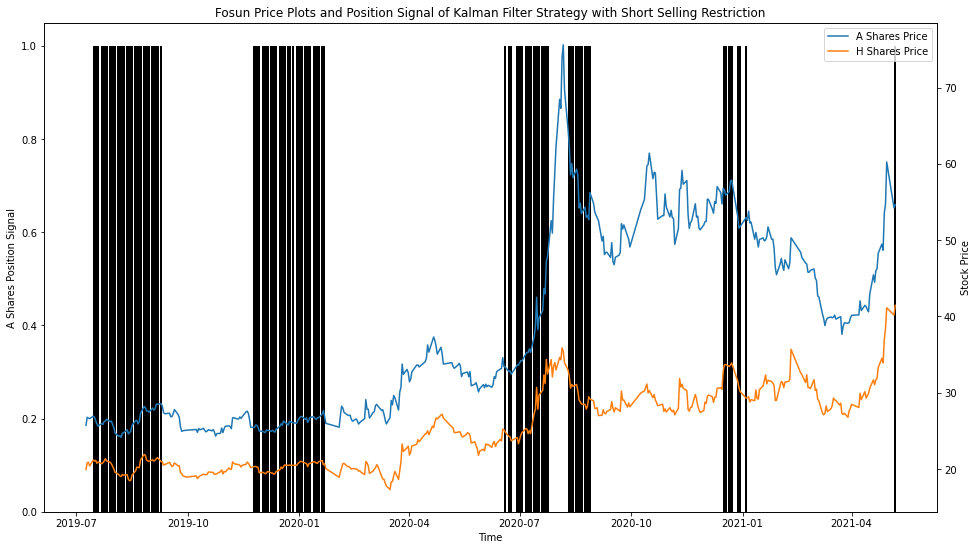

In [400]:
fig, ax1 = plt.subplots(figsize=(16,9))
ax2 = ax1.twinx()
ax1.bar(Fosun_kf_True_res.index, Fosun_kf_True_res['Signal'].values, label='Position Signal',color='black',width=2)
ax2.plot(Fosun_kf_True_res.index, Fosun_kf_True_res['A Shares'].values, label='A Shares Price')
ax2.plot(Fosun_kf_True_res.index, Fosun_kf_True_res['H Shares in RMB'].values, label='H Shares Price')
ax2.legend()
ax1.set_xlabel('Time')
ax1.set_ylabel('A Shares Position Signal')
ax2.set_ylabel('Stock Price')
ax1.set_title("Fosun Price Plots and Position Signal of Kalman Filter Strategy with Short Selling Restriction")

plt.show()

### Daily Returns

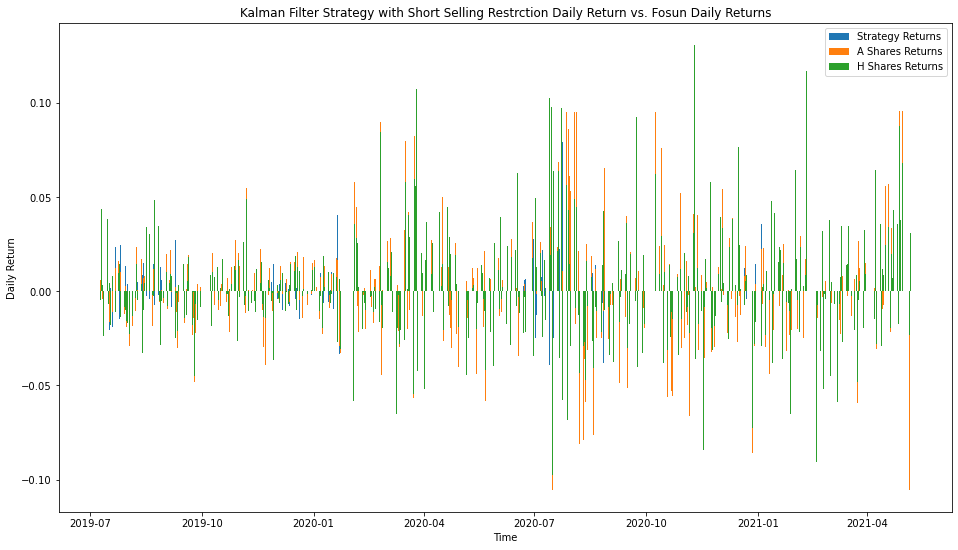

In [401]:
figure(figsize=(16,9))
plt.bar(Fosun_kf_True_res.index,Fosun_kf_True_res['Portfolio Log Return'],label='Strategy Returns')
plt.bar(Fosun_kf_True_res.index,Fosun_kf_True_res['A Shares Log Return'],label='A Shares Returns')
plt.bar(Fosun_kf_True_res.index,Fosun_kf_True_res['H Shares Log Return'],label='H Shares Returns')
plt.xlabel("Time")
plt.ylabel("Daily Return")
plt.title("Kalman Filter Strategy with Short Selling Restrction Daily Return vs. Fosun Daily Returns")
plt.legend()
plt.show()

### NAV

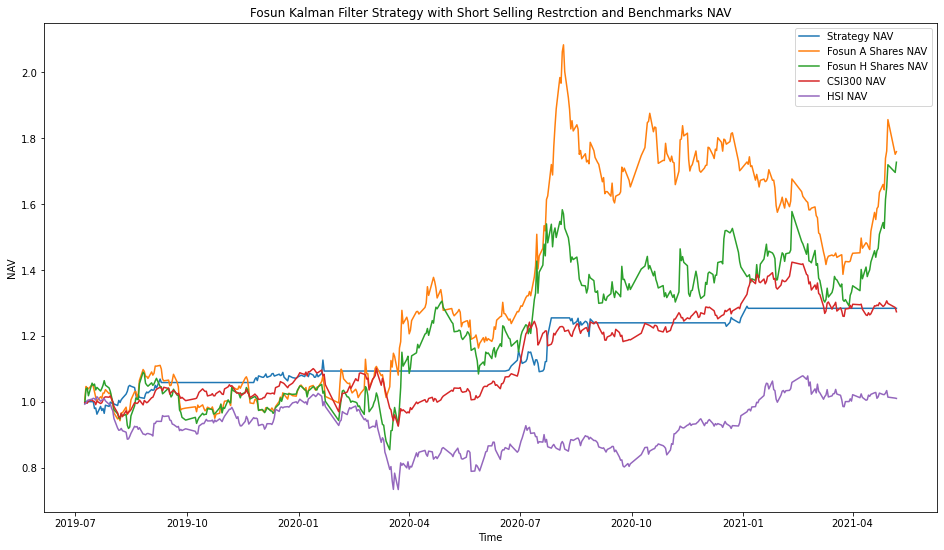

In [406]:
figure(figsize=(16,9))
plt.plot(Fosun_kf_True_res.index, (1+Fosun_kf_True_res['Portfolio Cumulative Return']).values, label='Strategy NAV')
plt.plot(Fosun_kf_True_res.index, (1+Fosun_kf_True_res['A Shares Cumulative Return']).values, label='Fosun A Shares NAV')
plt.plot(Fosun_kf_True_res.index, (1+Fosun_kf_True_res['H Shares Cumulative Return']).values, label='Fosun H Shares NAV')
plt.plot(Fosun_kf_True_res.index, (1+Fosun_kf_True_res['CSI300 Cumulative Return']).values, label='CSI300 NAV')
plt.plot(Fosun_kf_True_res.index, (1+Fosun_kf_True_res['HSI Cumulative Return'].values), label='HSI NAV')
plt.legend()
plt.ylabel('NAV')
plt.xlabel('Time')
plt.title('Fosun Kalman Filter Strategy with Short Selling Restrction and Benchmarks NAV')
plt.show()

### Drawdown

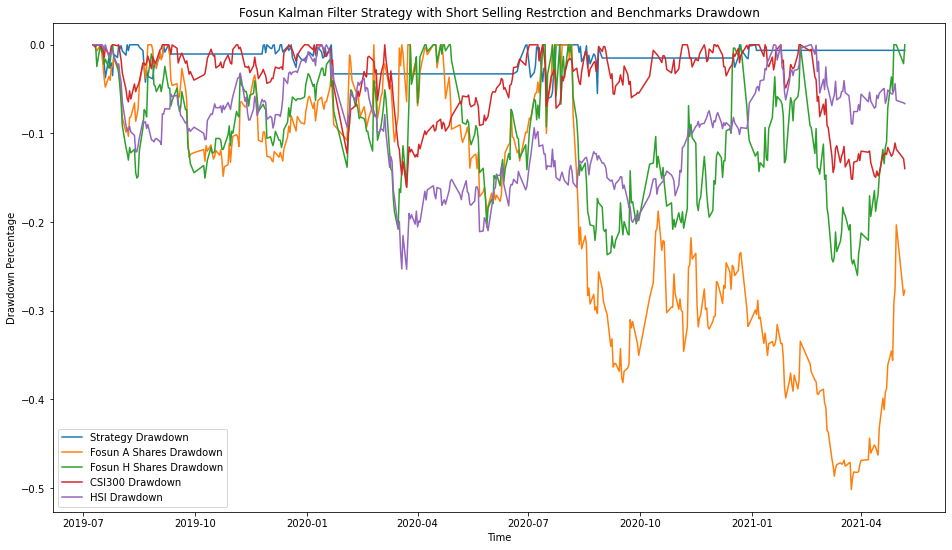

In [407]:
figure(figsize=(16,9))
plt.plot(Fosun_kf_True_res.index, (Fosun_kf_True_res['Drawdown']).values, label='Strategy Drawdown')
plt.plot(Fosun_kf_True_res.index, (Fosun_kf_True_res['A Shares Drawdown']).values, label='Fosun A Shares Drawdown')
plt.plot(Fosun_kf_True_res.index, (Fosun_kf_True_res['H Shares Drawdown']).values, label='Fosun H Shares Drawdown')
plt.plot(Fosun_kf_True_res.index, (Fosun_kf_True_res['CSI300 Drawdown']).values, label='CSI300 Drawdown')
plt.plot(Fosun_kf_True_res.index, (Fosun_kf_True_res['HSI Drawdown'].values), label='HSI Drawdown')
plt.legend()
plt.ylabel('Drawdown Percentage')
plt.xlabel('Time')
plt.title('Fosun Kalman Filter Strategy with Short Selling Restrction and Benchmarks Drawdown')
plt.show()

### Max Drawdown

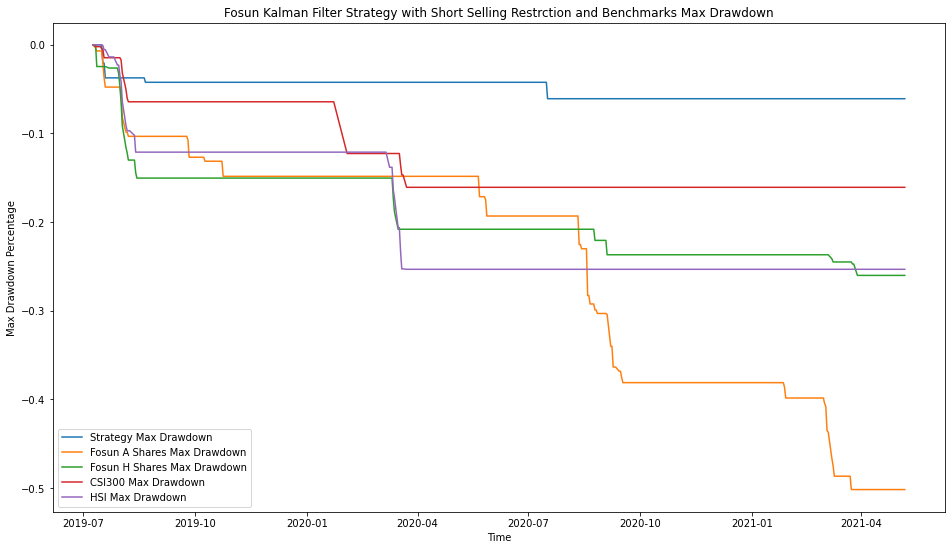

In [408]:
figure(figsize=(16,9))
plt.plot(Fosun_kf_True_res.index, (Fosun_kf_True_res['Max Drawdown']).values, label='Strategy Max Drawdown')
plt.plot(Fosun_kf_True_res.index, (Fosun_kf_True_res['A Shares Max Drawdown']).values, label='Fosun A Shares Max Drawdown')
plt.plot(Fosun_kf_True_res.index, (Fosun_kf_True_res['H Shares Max Drawdown']).values, label='Fosun H Shares Max Drawdown')
plt.plot(Fosun_kf_True_res.index, (Fosun_kf_True_res['CSI300 Max Drawdown']).values, label='CSI300 Max Drawdown')
plt.plot(Fosun_kf_True_res.index, (Fosun_kf_True_res['HSI Max Drawdown'].values), label='HSI Max Drawdown')
plt.legend()
plt.ylabel('Max Drawdown Percentage')
plt.xlabel('Time')
plt.title('Fosun Kalman Filter Strategy with Short Selling Restrction and Benchmarks Max Drawdown')
plt.show()

### Spread

Text(0.5, 1.0, 'Fosun Kalman Filter Strategy Spread Plot')

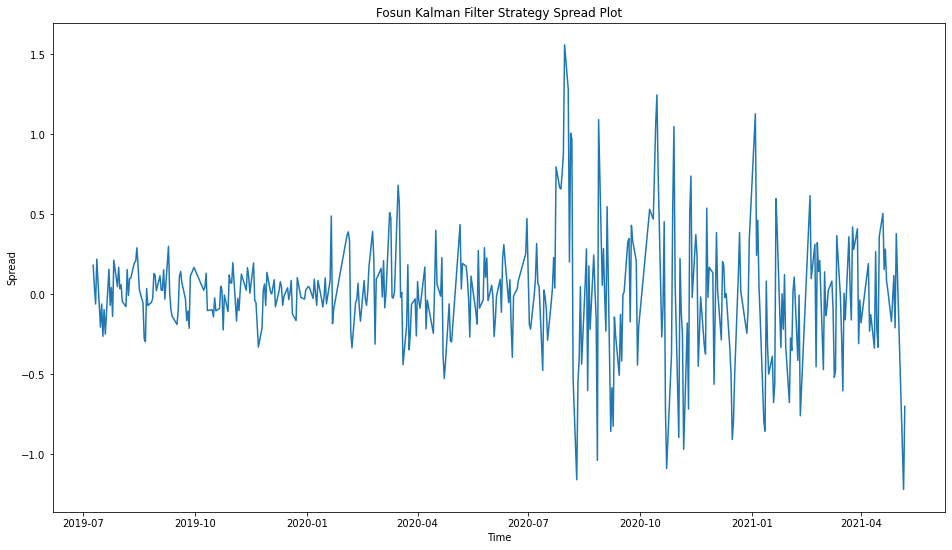

In [424]:
figure(figsize=(16,9))
plt.plot(Fosun_kf_True_res['Error'])
plt.xlabel('Time')
plt.ylabel('Spread')
plt.title('Fosun Kalman Filter Strategy Spread Plot')

## Worst Strategy Visualization
### Price Plots and Position Signal

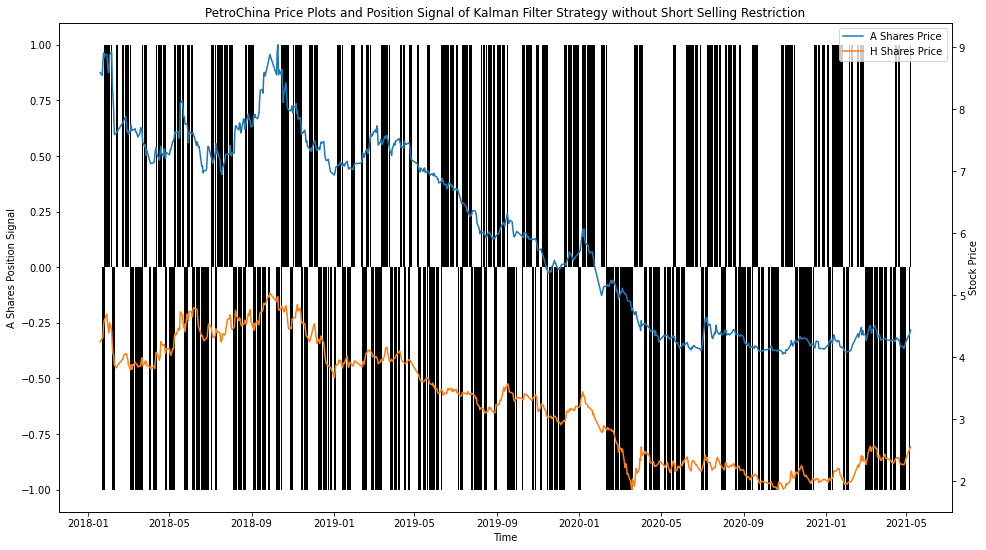

In [409]:
fig, ax1 = plt.subplots(figsize=(16,9))
ax2 = ax1.twinx()
ax1.bar(PetroChina_kf_False_res.index, PetroChina_kf_False_res['Signal'].values, label='Position Signal',color='black',width=2)
ax2.plot(PetroChina_kf_False_res.index, PetroChina_kf_False_res['A Shares'].values, label='A Shares Price')
ax2.plot(PetroChina_kf_False_res.index, PetroChina_kf_False_res['H Shares in RMB'].values, label='H Shares Price')
ax2.legend()
ax1.set_xlabel('Time')
ax1.set_ylabel('A Shares Position Signal')
ax2.set_ylabel('Stock Price')
ax1.set_title("PetroChina Price Plots and Position Signal of Kalman Filter Strategy without Short Selling Restriction")

plt.show()

### Daily Returns

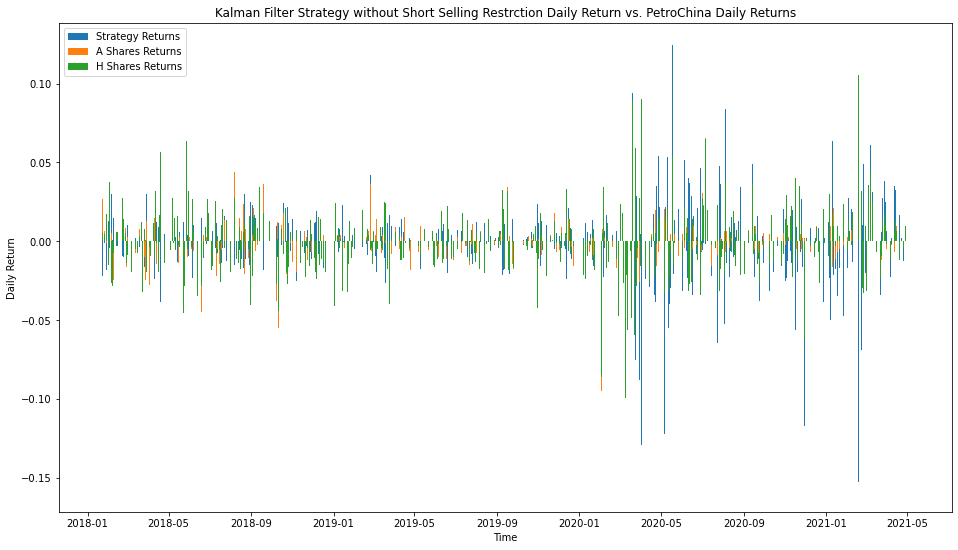

In [410]:
figure(figsize=(16,9))
plt.bar(PetroChina_kf_False_res.index,PetroChina_kf_False_res['Portfolio Log Return'],label='Strategy Returns')
plt.bar(PetroChina_kf_False_res.index,PetroChina_kf_False_res['A Shares Log Return'],label='A Shares Returns')
plt.bar(PetroChina_kf_False_res.index,PetroChina_kf_False_res['H Shares Log Return'],label='H Shares Returns')
plt.xlabel("Time")
plt.ylabel("Daily Return")
plt.title("Kalman Filter Strategy without Short Selling Restrction Daily Return vs. PetroChina Daily Returns")
plt.legend()
plt.show()

### NAV

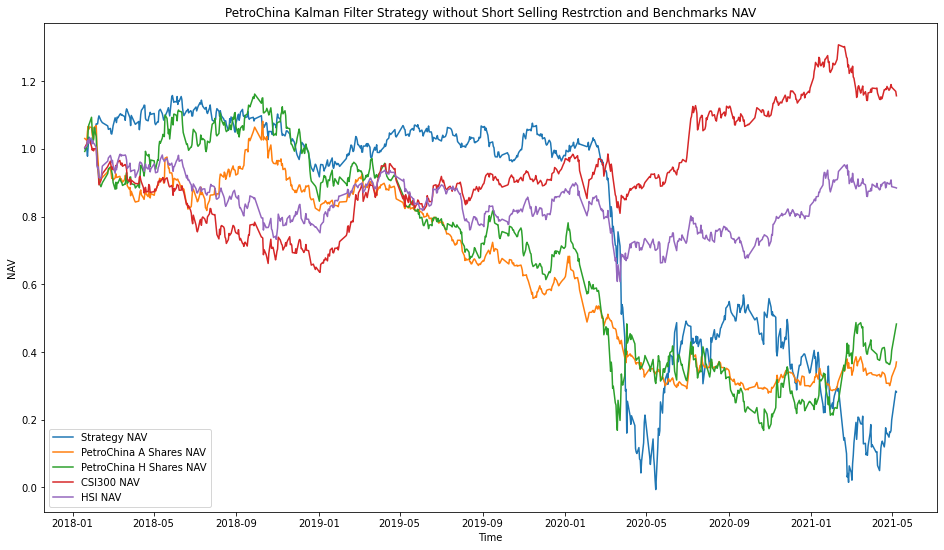

In [412]:
figure(figsize=(16,9))
plt.plot(PetroChina_kf_False_res.index, (1+PetroChina_kf_False_res['Portfolio Cumulative Return']).values, label='Strategy NAV')
plt.plot(PetroChina_kf_False_res.index, (1+PetroChina_kf_False_res['A Shares Cumulative Return']).values, label='PetroChina A Shares NAV')
plt.plot(PetroChina_kf_False_res.index, (1+PetroChina_kf_False_res['H Shares Cumulative Return']).values, label='PetroChina H Shares NAV')
plt.plot(PetroChina_kf_False_res.index, (1+PetroChina_kf_False_res['CSI300 Cumulative Return']).values, label='CSI300 NAV')
plt.plot(PetroChina_kf_False_res.index, (1+PetroChina_kf_False_res['HSI Cumulative Return'].values), label='HSI NAV')
plt.legend()
plt.ylabel('NAV')
plt.xlabel('Time')
plt.title('PetroChina Kalman Filter Strategy without Short Selling Restrction and Benchmarks NAV')
plt.show()

### Drawdown

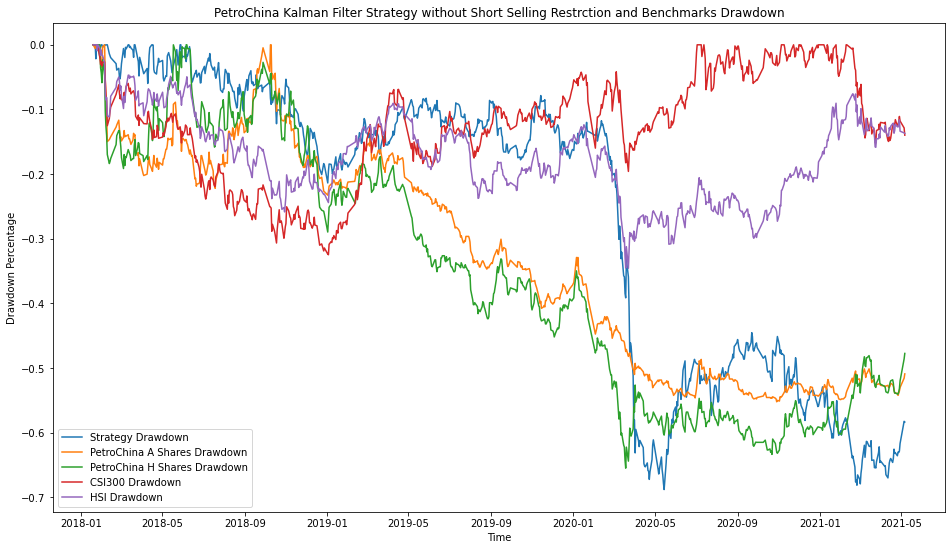

In [425]:
figure(figsize=(16,9))
plt.plot(PetroChina_kf_False_res.index, (PetroChina_kf_False_res['Drawdown']).values, label='Strategy Drawdown')
plt.plot(PetroChina_kf_False_res.index, (PetroChina_kf_False_res['A Shares Drawdown']).values, label='PetroChina A Shares Drawdown')
plt.plot(PetroChina_kf_False_res.index, (PetroChina_kf_False_res['H Shares Drawdown']).values, label='PetroChina H Shares Drawdown')
plt.plot(PetroChina_kf_False_res.index, (PetroChina_kf_False_res['CSI300 Drawdown']).values, label='CSI300 Drawdown')
plt.plot(PetroChina_kf_False_res.index, (PetroChina_kf_False_res['HSI Drawdown'].values), label='HSI Drawdown')
plt.legend()
plt.ylabel('Drawdown Percentage')
plt.xlabel('Time')
plt.title('PetroChina Kalman Filter Strategy without Short Selling Restrction and Benchmarks Drawdown')
plt.show()

### Max Drawdown

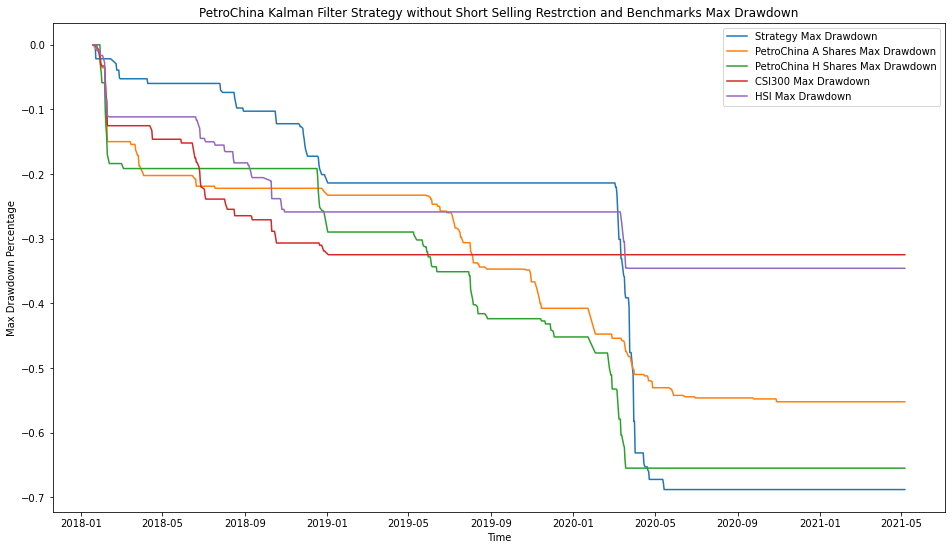

In [426]:
figure(figsize=(16,9))
plt.plot(PetroChina_kf_False_res.index, (PetroChina_kf_False_res['Max Drawdown']).values, label='Strategy Max Drawdown')
plt.plot(PetroChina_kf_False_res.index, (PetroChina_kf_False_res['A Shares Max Drawdown']).values, label='PetroChina A Shares Max Drawdown')
plt.plot(PetroChina_kf_False_res.index, (PetroChina_kf_False_res['H Shares Max Drawdown']).values, label='PetroChina H Shares Max Drawdown')
plt.plot(PetroChina_kf_False_res.index, (PetroChina_kf_False_res['CSI300 Max Drawdown']).values, label='CSI300 Max Drawdown')
plt.plot(PetroChina_kf_False_res.index, (PetroChina_kf_False_res['HSI Max Drawdown'].values), label='HSI Max Drawdown')
plt.legend()
plt.ylabel('Max Drawdown Percentage')
plt.xlabel('Time')
plt.title('PetroChina Kalman Filter Strategy without Short Selling Restrction and Benchmarks Max Drawdown')
plt.show()

Text(0.5, 1.0, 'PetroChina Kalman Filter Strategy Spread Plot')

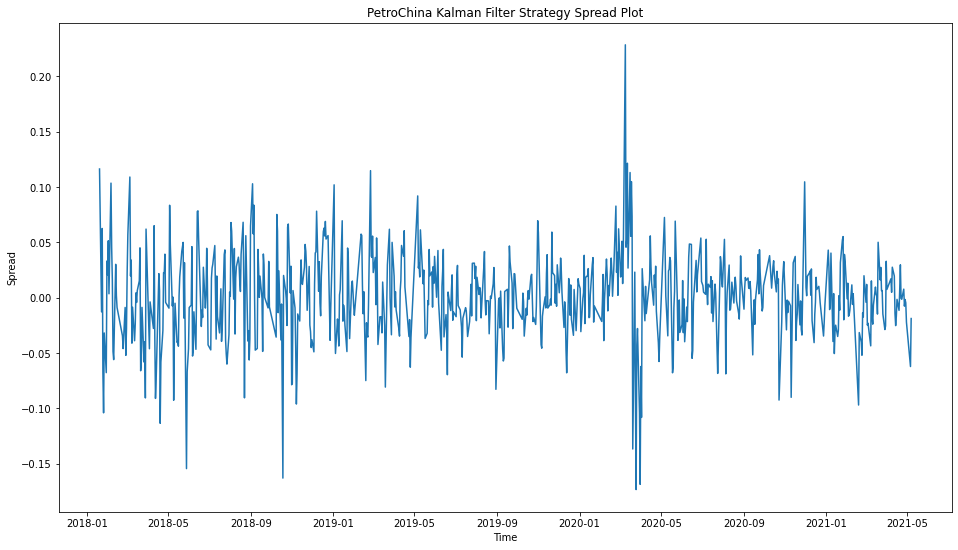

In [427]:
figure(figsize=(16,9))
plt.plot(PetroChina_kf_False_res['Error'])
plt.xlabel('Time')
plt.ylabel('Spread')
plt.title('PetroChina Kalman Filter Strategy Spread Plot')

## A/H Premium

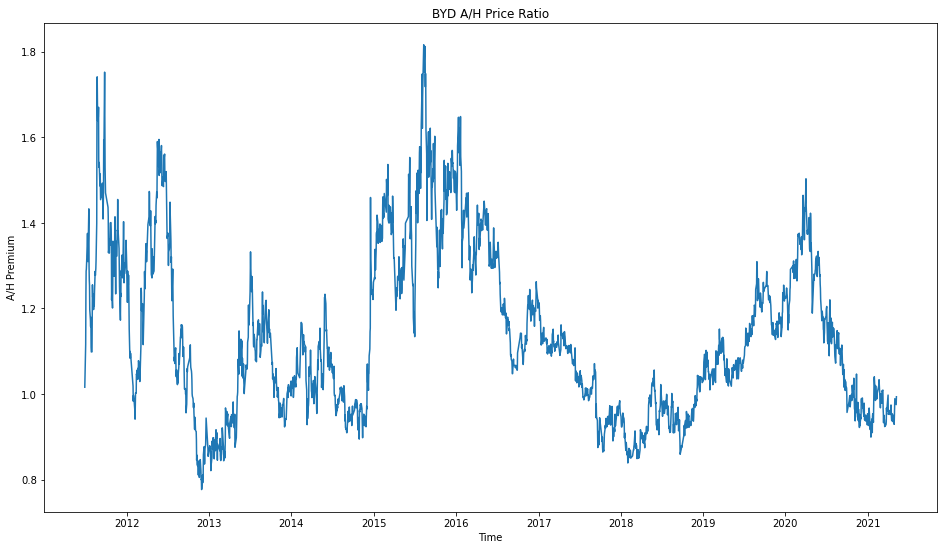

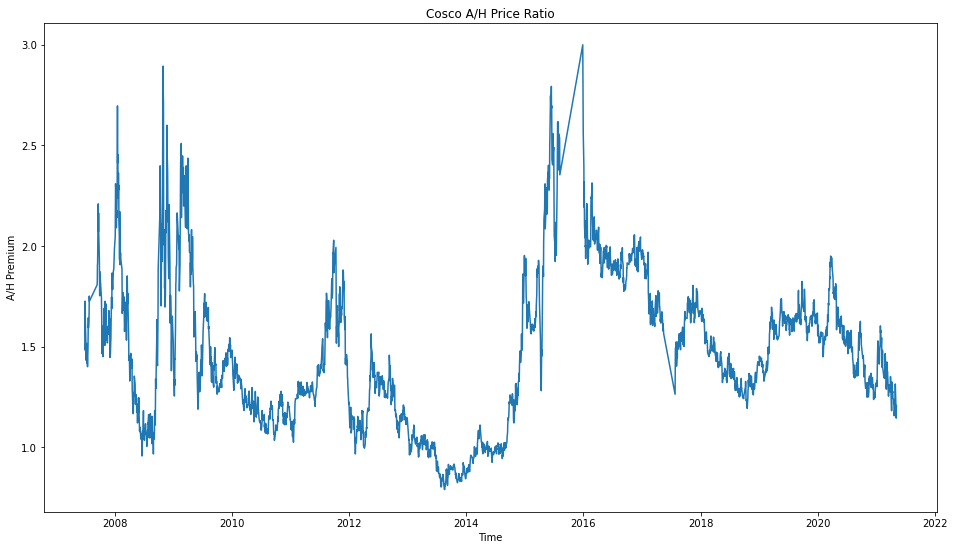

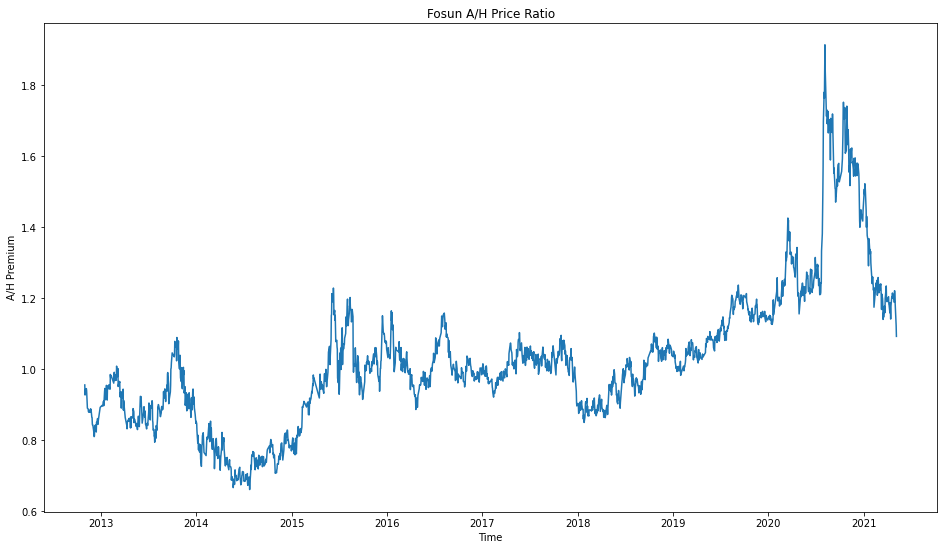

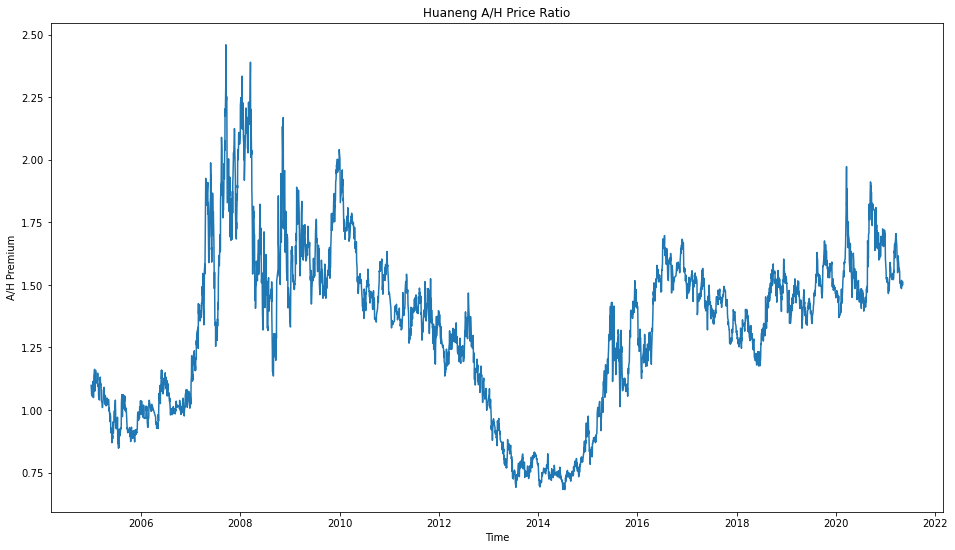

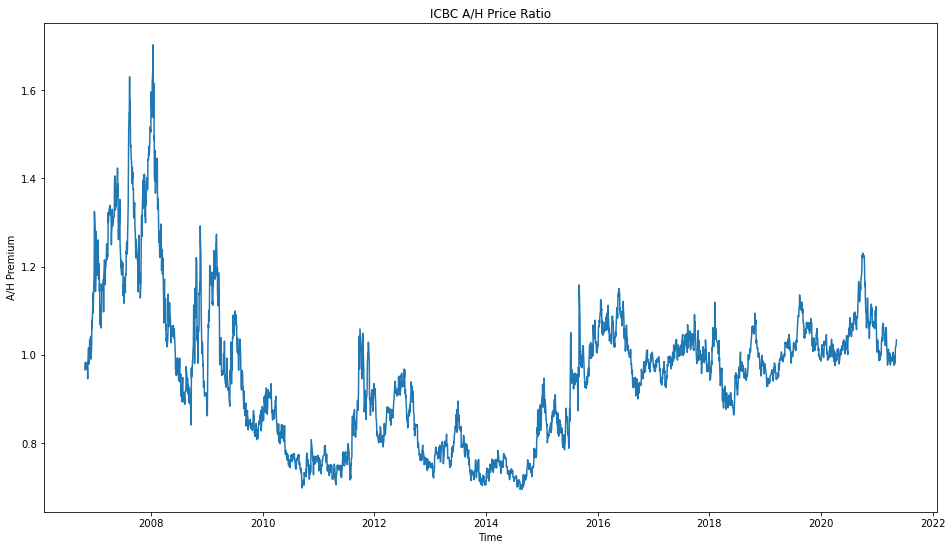

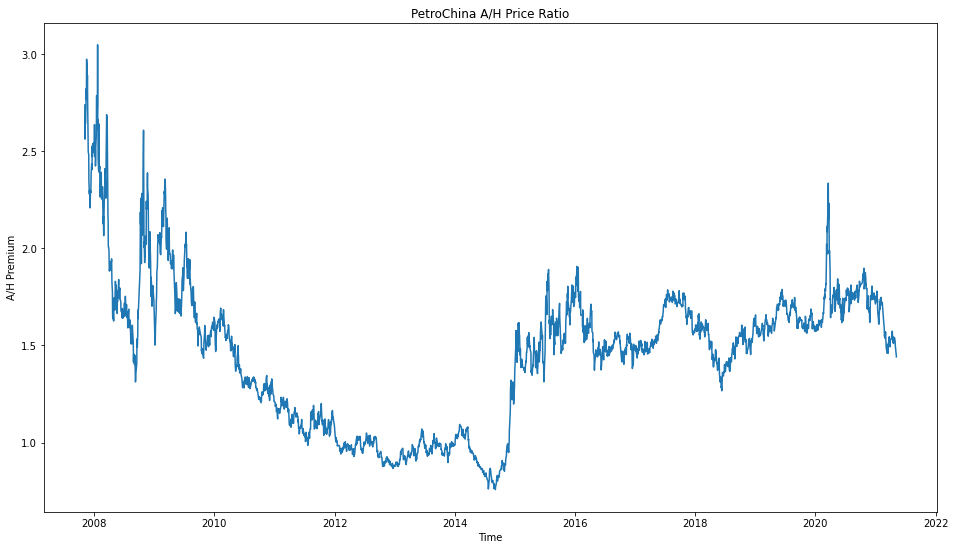

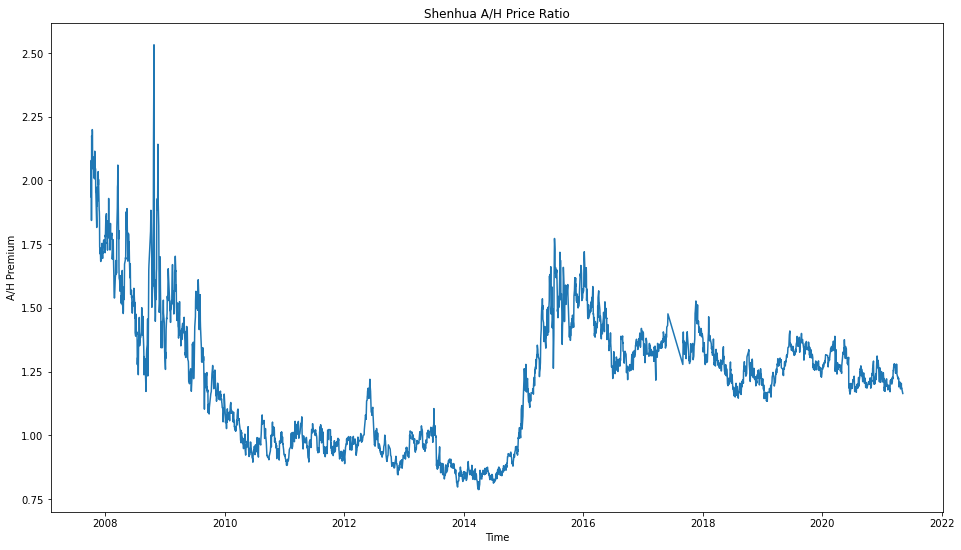

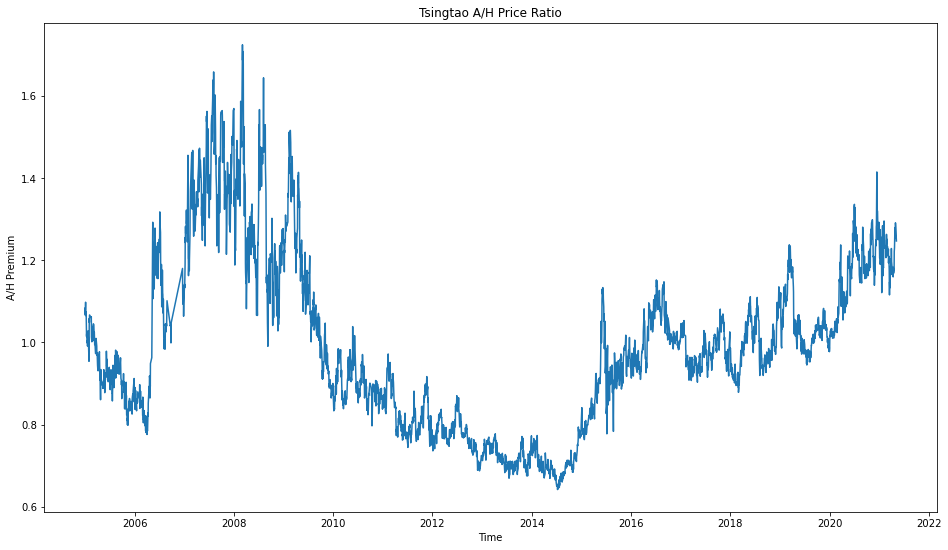

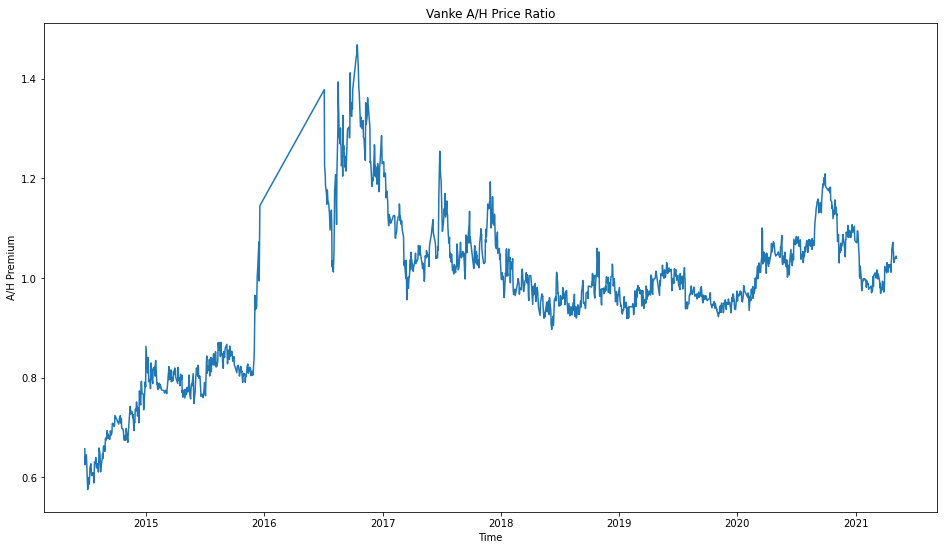

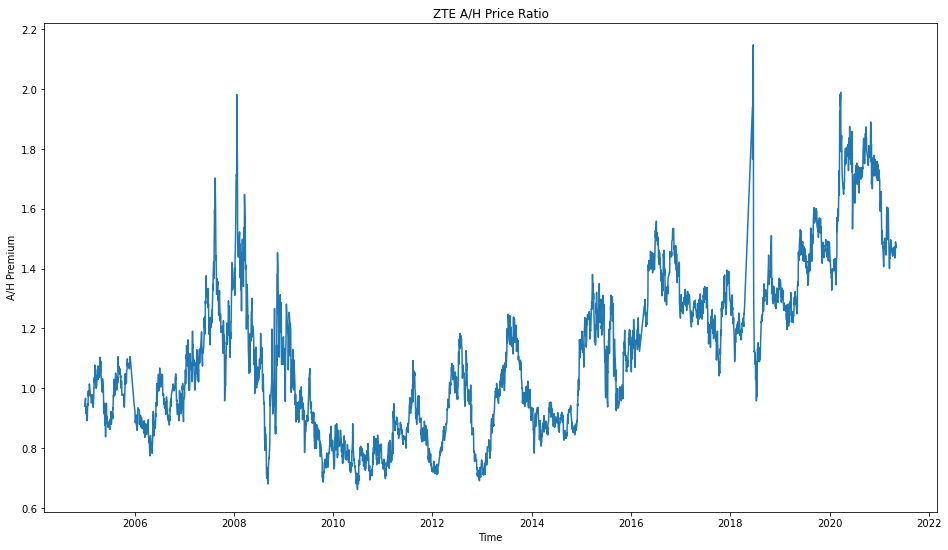

In [431]:
for i in range(len(stock_list)):
    figure(figsize=(16,9))
    plt.plot(df_list[i]['A Shares']/df_list[i]['H Shares'])
    plt.xlabel('Time')
    plt.ylabel('A/H Premium')
    plt.title(stock_list[i]+' A/H Price Ratio')
    plt.plot()